In [ ]:
!pip install yfinance
!pip install fredapi

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 948.2/948.2 kB 15.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.2/102.2 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.4/117.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.0/5.0 MB 77.8 MB/s eta 0:00:00
  Created wheel for peewee: filename=peewee-3.17.8-cp310-cp310-linux_x86_64.whl size=843018 sha256=94693c9b7d49d52131e310a4c695e9796c9891591549cd13ef768efd5a1663b7
  Stored in directory: /root/.cache/pip/wheels/75/79/e5/8838db0594cc6c587142fd2563356392ade6255c5930411069
Successfully built peewee


# Python Modules

Mục đích import các Module
- Module `yfinance`: Lấy các dữ liệu giao dịch, trong đó bao gồm giá đóng cửa (Close), giá mở cửa (Open) và khối lượng giao dịch của các ngày trước đó (Volume)
- Module `fredapi`: Lấy các chỉ số kinh tế vĩ mô.  
- Các Module `pandas`, `numpy`, `matplotlib.pyplot` phục vụ cho phần tiền xử lý và trực quan hóa dữ liệu

In [ ]:
import yfinance as yf
import fredapi
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
from sklearn.model_selection import train_test_split # Chia dữ liệu thành train và test
from sklearn.preprocessing import MinMaxScaler # Sử dụng thư viện MinMaxScaler để chuẩn hóa dữ liệu về dạng [0, 1]
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from tensorflow.keras.layers import Dense, Dropout # Sử dụng Dropout để tránh overfitting
from tensorflow.keras.callbacks  import EarlyStopping # Sử dụng EarlyStopping để tránh overfitting
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score # Đánh giá bằng các thang đo MAE MSE RMSE R^2 MAPE

# Data

Nhóm lấy dữ liệu cổ phiếu của Yahoo Finance mà Yahoo Finance không có danh sách chính thức và cố định về *loại ngành của cổ phiếu* (Industry type of the stock) mà họ sử dụng hệ thống phân loại ngành dựa trên Global Industry Classification Standard (GICS), một tiêu chuẩn phân loại ngành toàn cầu được phát triển bởi MSCI và Standard & Poor's.  

Trong các lĩnh vực theo GICS thì nhóm có chọn ra **02** lĩnh vực và các công ty/tập đoàn thuộc lĩnh vực tương ứng là:   

1. **Tiêu dùng thường xuyên (Consumer Staples)**:
- Coca-Cola (KO)
- Nestle (NESN.SW)
- PepsiCo (PEP)  

2. **Viễn thông (Communication Services)**:  
- Walt Disney (DIS)
- Netflix (NFLX)
- Meta Platforms (META)


Đồng thời nhóm đã chọn các *chỉ số kinh tế vĩ mô* (macroeconomic indicators) cho các doanh nghiệp trên và các chỉ số này đóng góp vào việc train & test model. Các chỉ số nhóm đã chọn là:
- GDP
- CPI (Lạm phát)
- Tỷ lệ thất nghiệp
- Lãi suất

Tất cả các dữ liệu về chỉ số kinh tế nhóm đều lấy nguồn từ FRED (fredapi) - Federal Reserve Economic Data: https://fred.stlouisfed.org

## Data connection

Tạo một danh sách mã cổ phiếu và tải toàn bộ data của nó

In [ ]:
# Lĩnh vực: Tiêu dùng thường xuyên (Consumer Staples)
customer_staples = ["KO", "NESN.SW", "PEP"]

# Lĩnh vực: Viễn thông (Communication Services)
communication_services = ["DIS", "NFLX", "META"]

In [ ]:
# Định nghĩa thời gian quan sát: Từ ngày 1/4/2014 đến ngày 31/10/2024
observation_start = '2014-04-01'
observation_end = '2024-10-31'

### Dữ liệu cổ phiếu

In [ ]:
# Kết hợp tất cả các mã cổ phiếu
tickers = customer_staples + communication_services

# Tạo dictionary để lưu trữ dữ liệu của các mã cổ phiếu
# Sử dụng thư viện yfinance để lấy dữ liệu từ Yahoo Finance
# Lấy dữ liệu trong khoảng 10 năm từ 2014-01-01 đến 2024-10-31
stock_data = {}
for ticker in tickers:
    stock_data[ticker] = yf.download(ticker, start=observation_start, end=observation_end)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


### Các chỉ số kinh tế vĩ mô

In [ ]:
# Khởi tạo API của FRED
fred = fredapi.Fred(api_key='e0bafc711878fc681fdfd4dc214dc1e8')

In [ ]:
# Tải dữ liệu từ FRED
gdp = fred.get_series('GDPC1', observation_start=observation_start, observation_end=observation_end)  # Real GDP
cpi = fred.get_series('CPIAUCSL', observation_start=observation_start, observation_end=observation_end)  # Consumer Price Index (CPI)
unemployment = fred.get_series('UNRATE', observation_start=observation_start, observation_end=observation_end)  # Unemployment Rate
fed_funds_rate = fred.get_series('FEDFUNDS', observation_start=observation_start, observation_end=observation_end)  # Federal Funds Rate

# Chuyển đổi thành DataFrame
macro_data = pd.DataFrame({
    'GDP': gdp,
    'CPI': cpi,
    'Unemployment_Rate': unemployment,
    'Fed_Funds_Rate': fed_funds_rate
})

In [ ]:
macro_data.tail(10)

GDP      CPI  Unemployment_Rate  Fed_Funds_Rate
2024-01-01  23053.545  309.685                3.7            5.33
2024-02-01        NaN  311.054                3.9            5.33
2024-03-01        NaN  312.230                3.8            5.33
2024-04-01  23223.906  313.207                3.9            5.33
2024-05-01        NaN  313.225                4.0            5.33
2024-06-01        NaN  313.049                4.1            5.33
2024-07-01  23386.733  313.534                4.3            5.33
2024-08-01        NaN  314.121                4.2            5.33
2024-09-01        NaN  314.686                4.1            5.13
2024-10-01        NaN  315.454                4.1            4.83

Nhìn vào 10 dòng đầu tiên của dữ liệu kinh tế vĩ mô thì ta có thế thấy ngoại trừ `GDP` được tính theo **quý** (1 quý = 3 tháng) thì các chỉ số còn lại đều tính theo tháng. Dữ liệu của `GDP` sẽ được xử lý sau thông qua phần ***Data Preprocessing - Tiền xử lý dữ liệu***

## Data information

In [ ]:
# Hiển thị 5 dòng đầu tiên của bộ dữ liệu của mã cổ phiếu KO
stock_data["KO"].head()

Price       Adj Close      Close       High        Low       Open    Volume
Ticker             KO         KO         KO         KO         KO        KO
Date                                                                       
2014-04-01  27.349781  38.410000  38.889999  38.310001  38.529999  20515700
2014-04-02  27.292810  38.330002  38.540001  38.299999  38.490002  15709100
2014-04-03  27.107676  38.070000  38.490002  38.040001  38.389999  18114000
2014-04-04  27.214499  38.220001  38.480000  38.139999  38.240002  15453600
2014-04-07  27.499311  38.619999  38.889999  38.259998  38.270000  17295700

In [ ]:
# Hiển thị thông tin của bộ dữ liệu của mã cổ phiếu WMT
stock_data["KO"].columns

MultiIndex([('Adj Close', 'KO'),
            (    'Close', 'KO'),
            (     'High', 'KO'),
            (      'Low', 'KO'),
            (     'Open', 'KO'),
            (   'Volume', 'KO')],
           names=['Price', 'Ticker'])

Dữ liệu cột đang bị lỗi format do nó đang ở dạng ['Price', 'Ticker']. Convert nó về dạng ['Price']

In [ ]:
# Loại bỏ level 1 của multi-index, giữ lại level 0
for ticker in tickers:
    stock_data[ticker].columns = stock_data[ticker].columns.droplevel(1)

Mỗi cột đang bị dính với Date, tiến hành tách cột Date thành một cột riêng biệt.

In [ ]:
# Sử dụng hàm reset_index() để chuyển cột ngày thành cột dữ liệu
for ticker in tickers:
    stock_data[ticker] = stock_data[ticker].reset_index()

In [ ]:
# Đổi tên cột Adj Close thành Adj_Close
for ticker in tickers:
    stock_data[ticker] = stock_data[ticker].rename(columns={"Adj Close": "Adj_Close"})

In [ ]:
stock_data['DIS'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2665 entries, 0 to 2664
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2665 non-null   datetime64[ns]
 1   Adj_Close  2665 non-null   float64       
 2   Close      2665 non-null   float64       
 3   High       2665 non-null   float64       
 4   Low        2665 non-null   float64       
 5   Open       2665 non-null   float64       
 6   Volume     2665 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 145.9 KB


Tổng quan về các cột dữ liệu trong từng ticker
- `Date`: Ngày giao dịch.
- `Open`: Giá mở cửa.
- `High`: Giá cao nhất.
- `Low`: Giá thấp nhất.
- `Close`: Giá đóng cửa.
- `Adj_Close`: Giá điều chỉnh (sau chia cổ tức hoặc tách cổ phiếu).
- `Volume`: Khối lượng giao dịch.

## Exploratory Data Analysis

Vẽ các biểu đồ để trực quan hóa dữ liệu

### Biểu đồ đường của giá Mở qua các năm

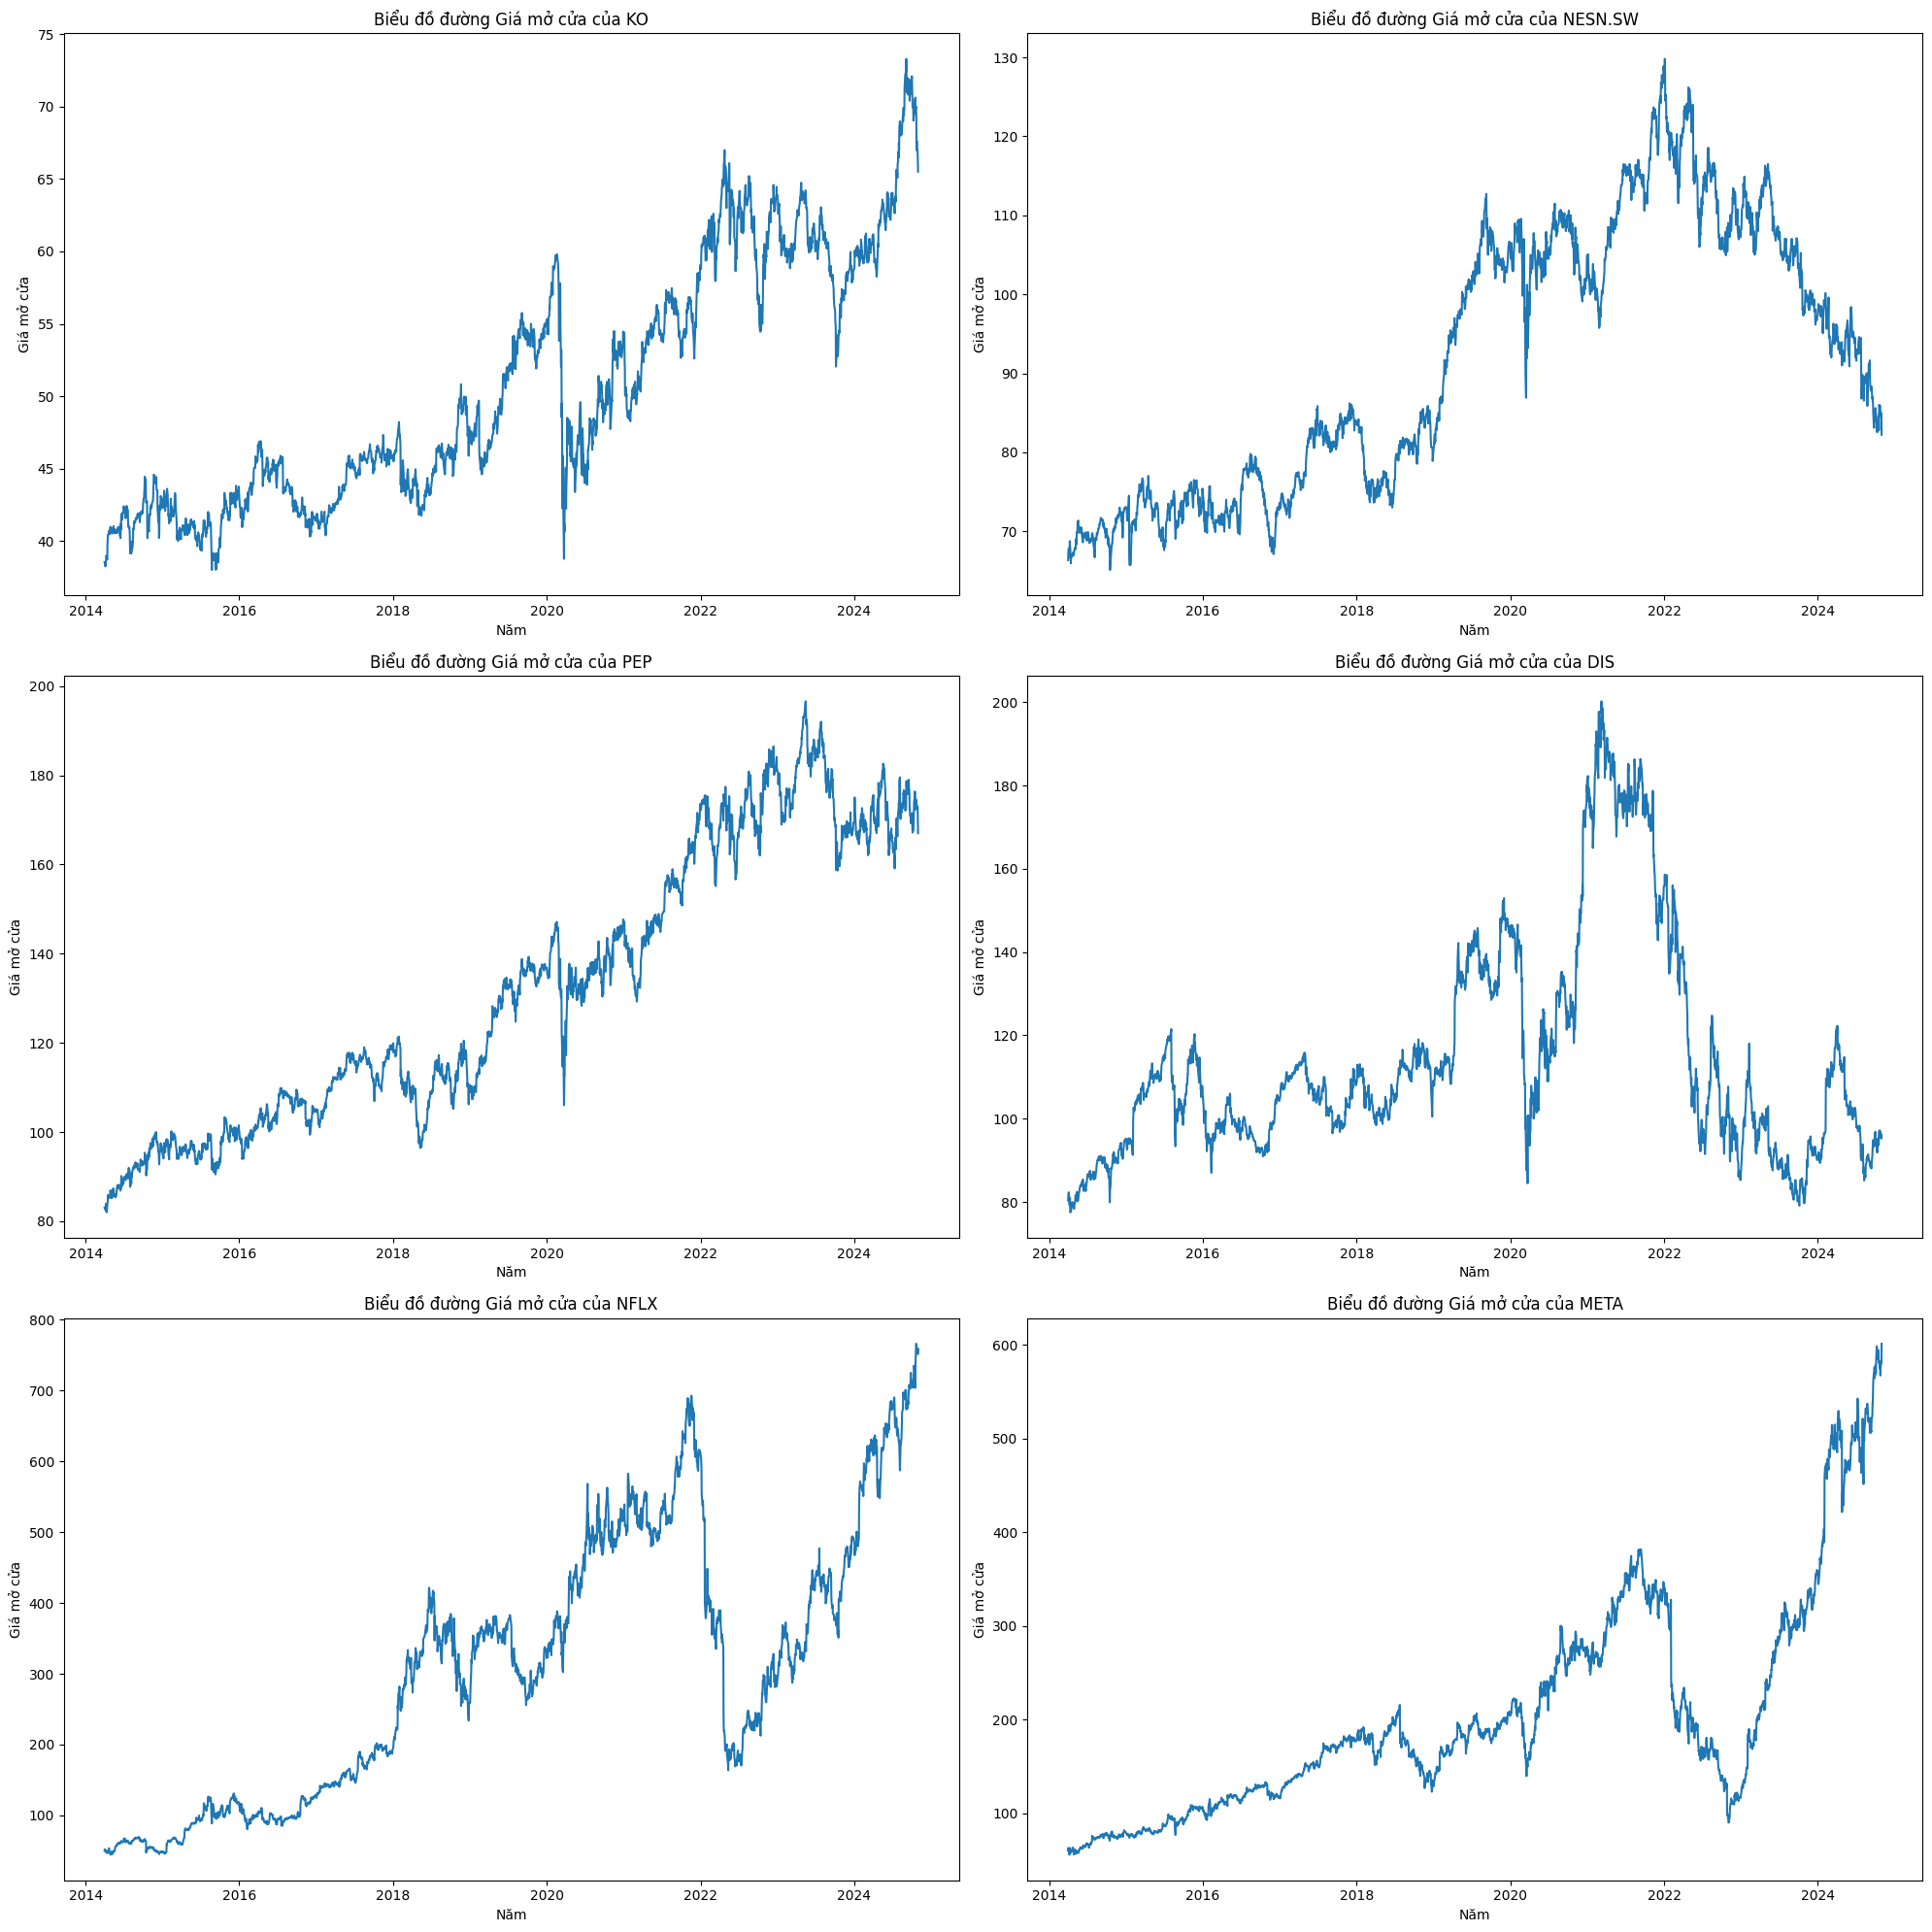

In [ ]:
plt.figure(figsize=(20, 20))
i = 1
for ticker in tickers:
    plt.subplot(3, 2, i) # Chia cửa sổ hiển thị thành 5 hàng và 2 cột
    plt.plot(stock_data[ticker]["Date"], stock_data[ticker]["Open"]) # Vẽ biểu đồ đường với trục x là ngày, trục y là giá mở cửa
    plt.title(f'Biểu đồ đường Giá mở cửa của {ticker}') # Đặt tiêu đề cho biểu đồ
    plt.xlabel('Năm') # Đặt tên cho trục x
    plt.ylabel('Giá mở cửa') # Đặt tên cho trục y
    plt.tight_layout() # Xét khoảng cách giữa các hàng
    i += 1 # Tăng i lên 1 để chuyển sang vẽ biểu đồ của mã cổ phiếu tiếp theo

### Biểu đồ đường biểu thị sự tương quan của giá Đóng cửa và giá Mở cửa

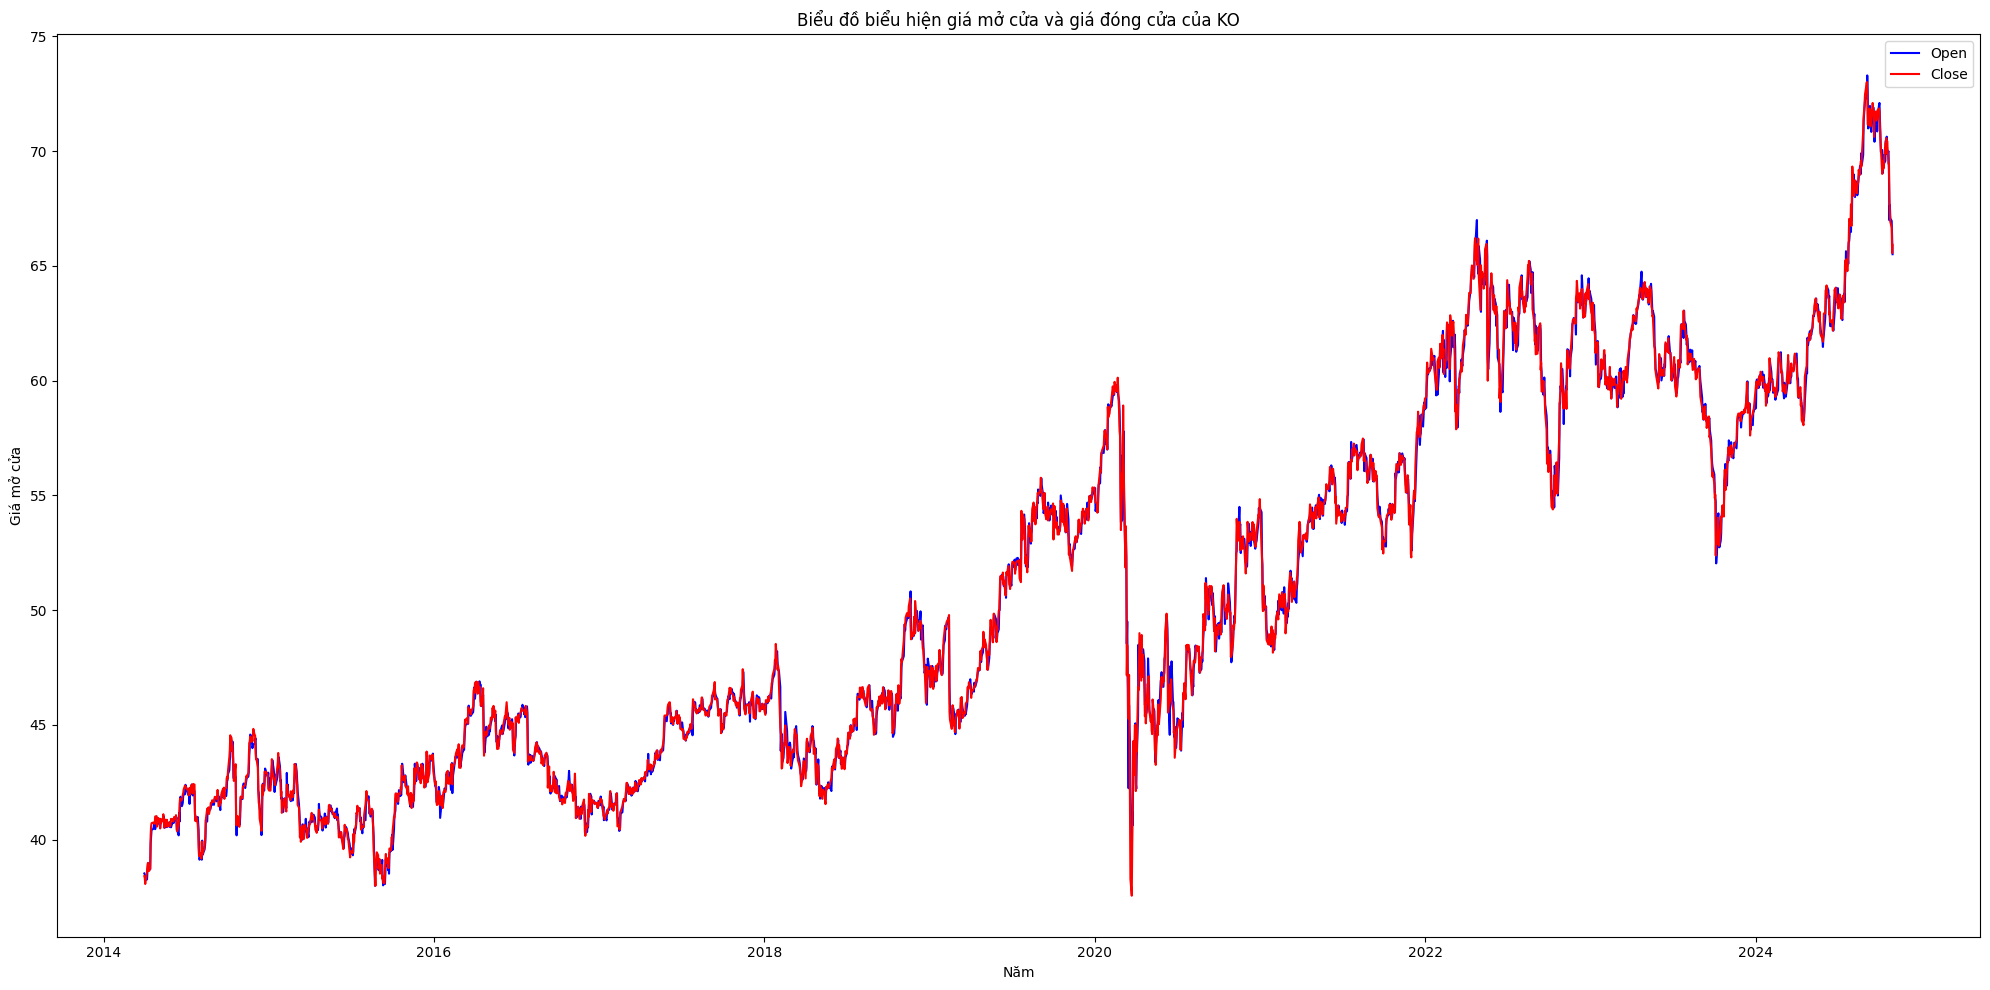

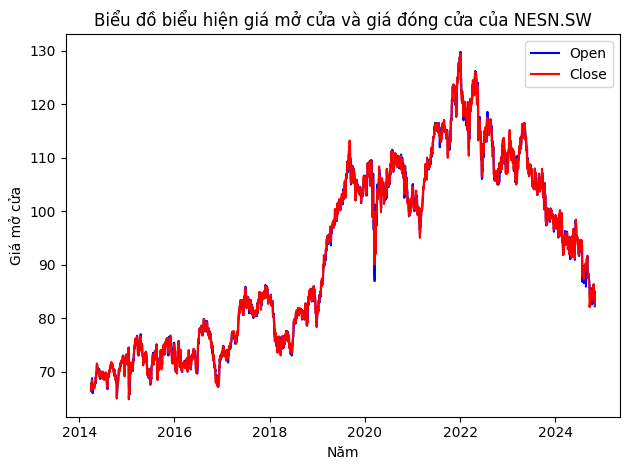

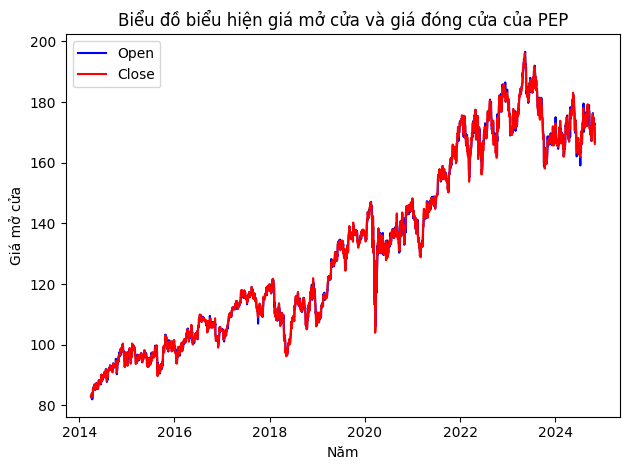

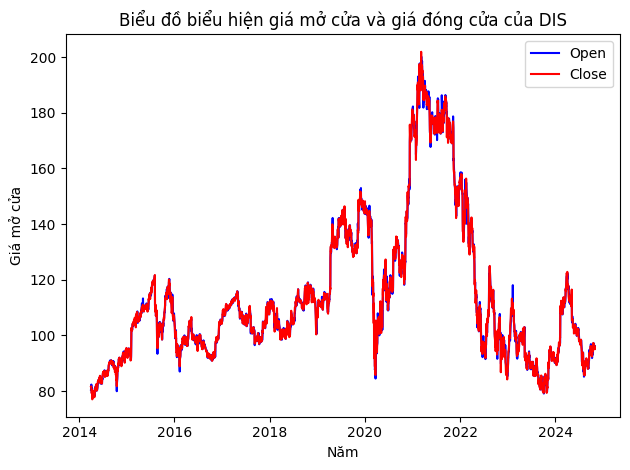

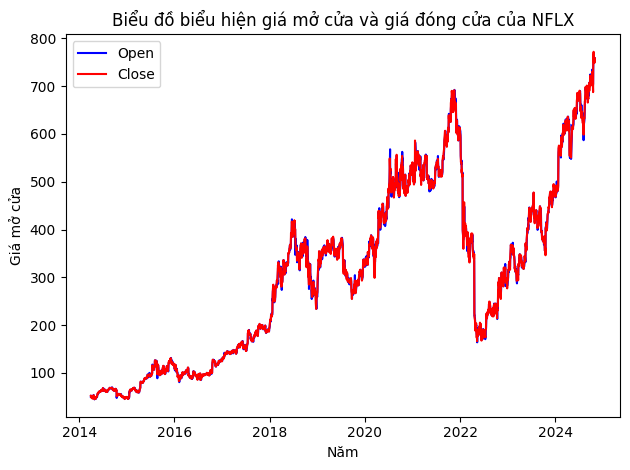

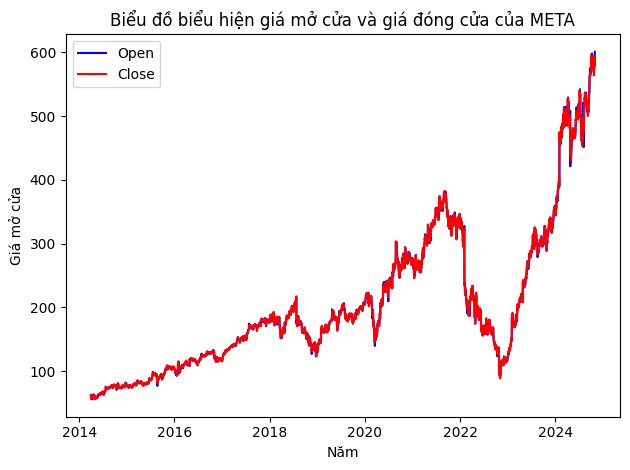

In [ ]:
plt.figure(figsize=(20, 10))
for ticker in tickers:
    plt.plot(stock_data[ticker]["Date"], stock_data[ticker]["Open"], color='b', label='Open') # Vẽ biểu đồ đường với trục x là ngày, trục y là giá mở cửa
    plt.plot(stock_data[ticker]["Date"], stock_data[ticker]["Close"], color='r', label='Close')
    plt.title(f'Biểu đồ biểu hiện giá mở cửa và giá đóng cửa của {ticker}') # Đặt tiêu đề cho biểu đồ
    plt.xlabel('Năm') # Đặt tên cho trục x
    plt.ylabel('Giá mở cửa') # Đặt tên cho trục y
    plt.tight_layout() # Xét khoảng cách giữa các hàng
    plt.legend()
    plt.show()

### Biểu đồ biểu đạt số lượng giao dịch qua các năm

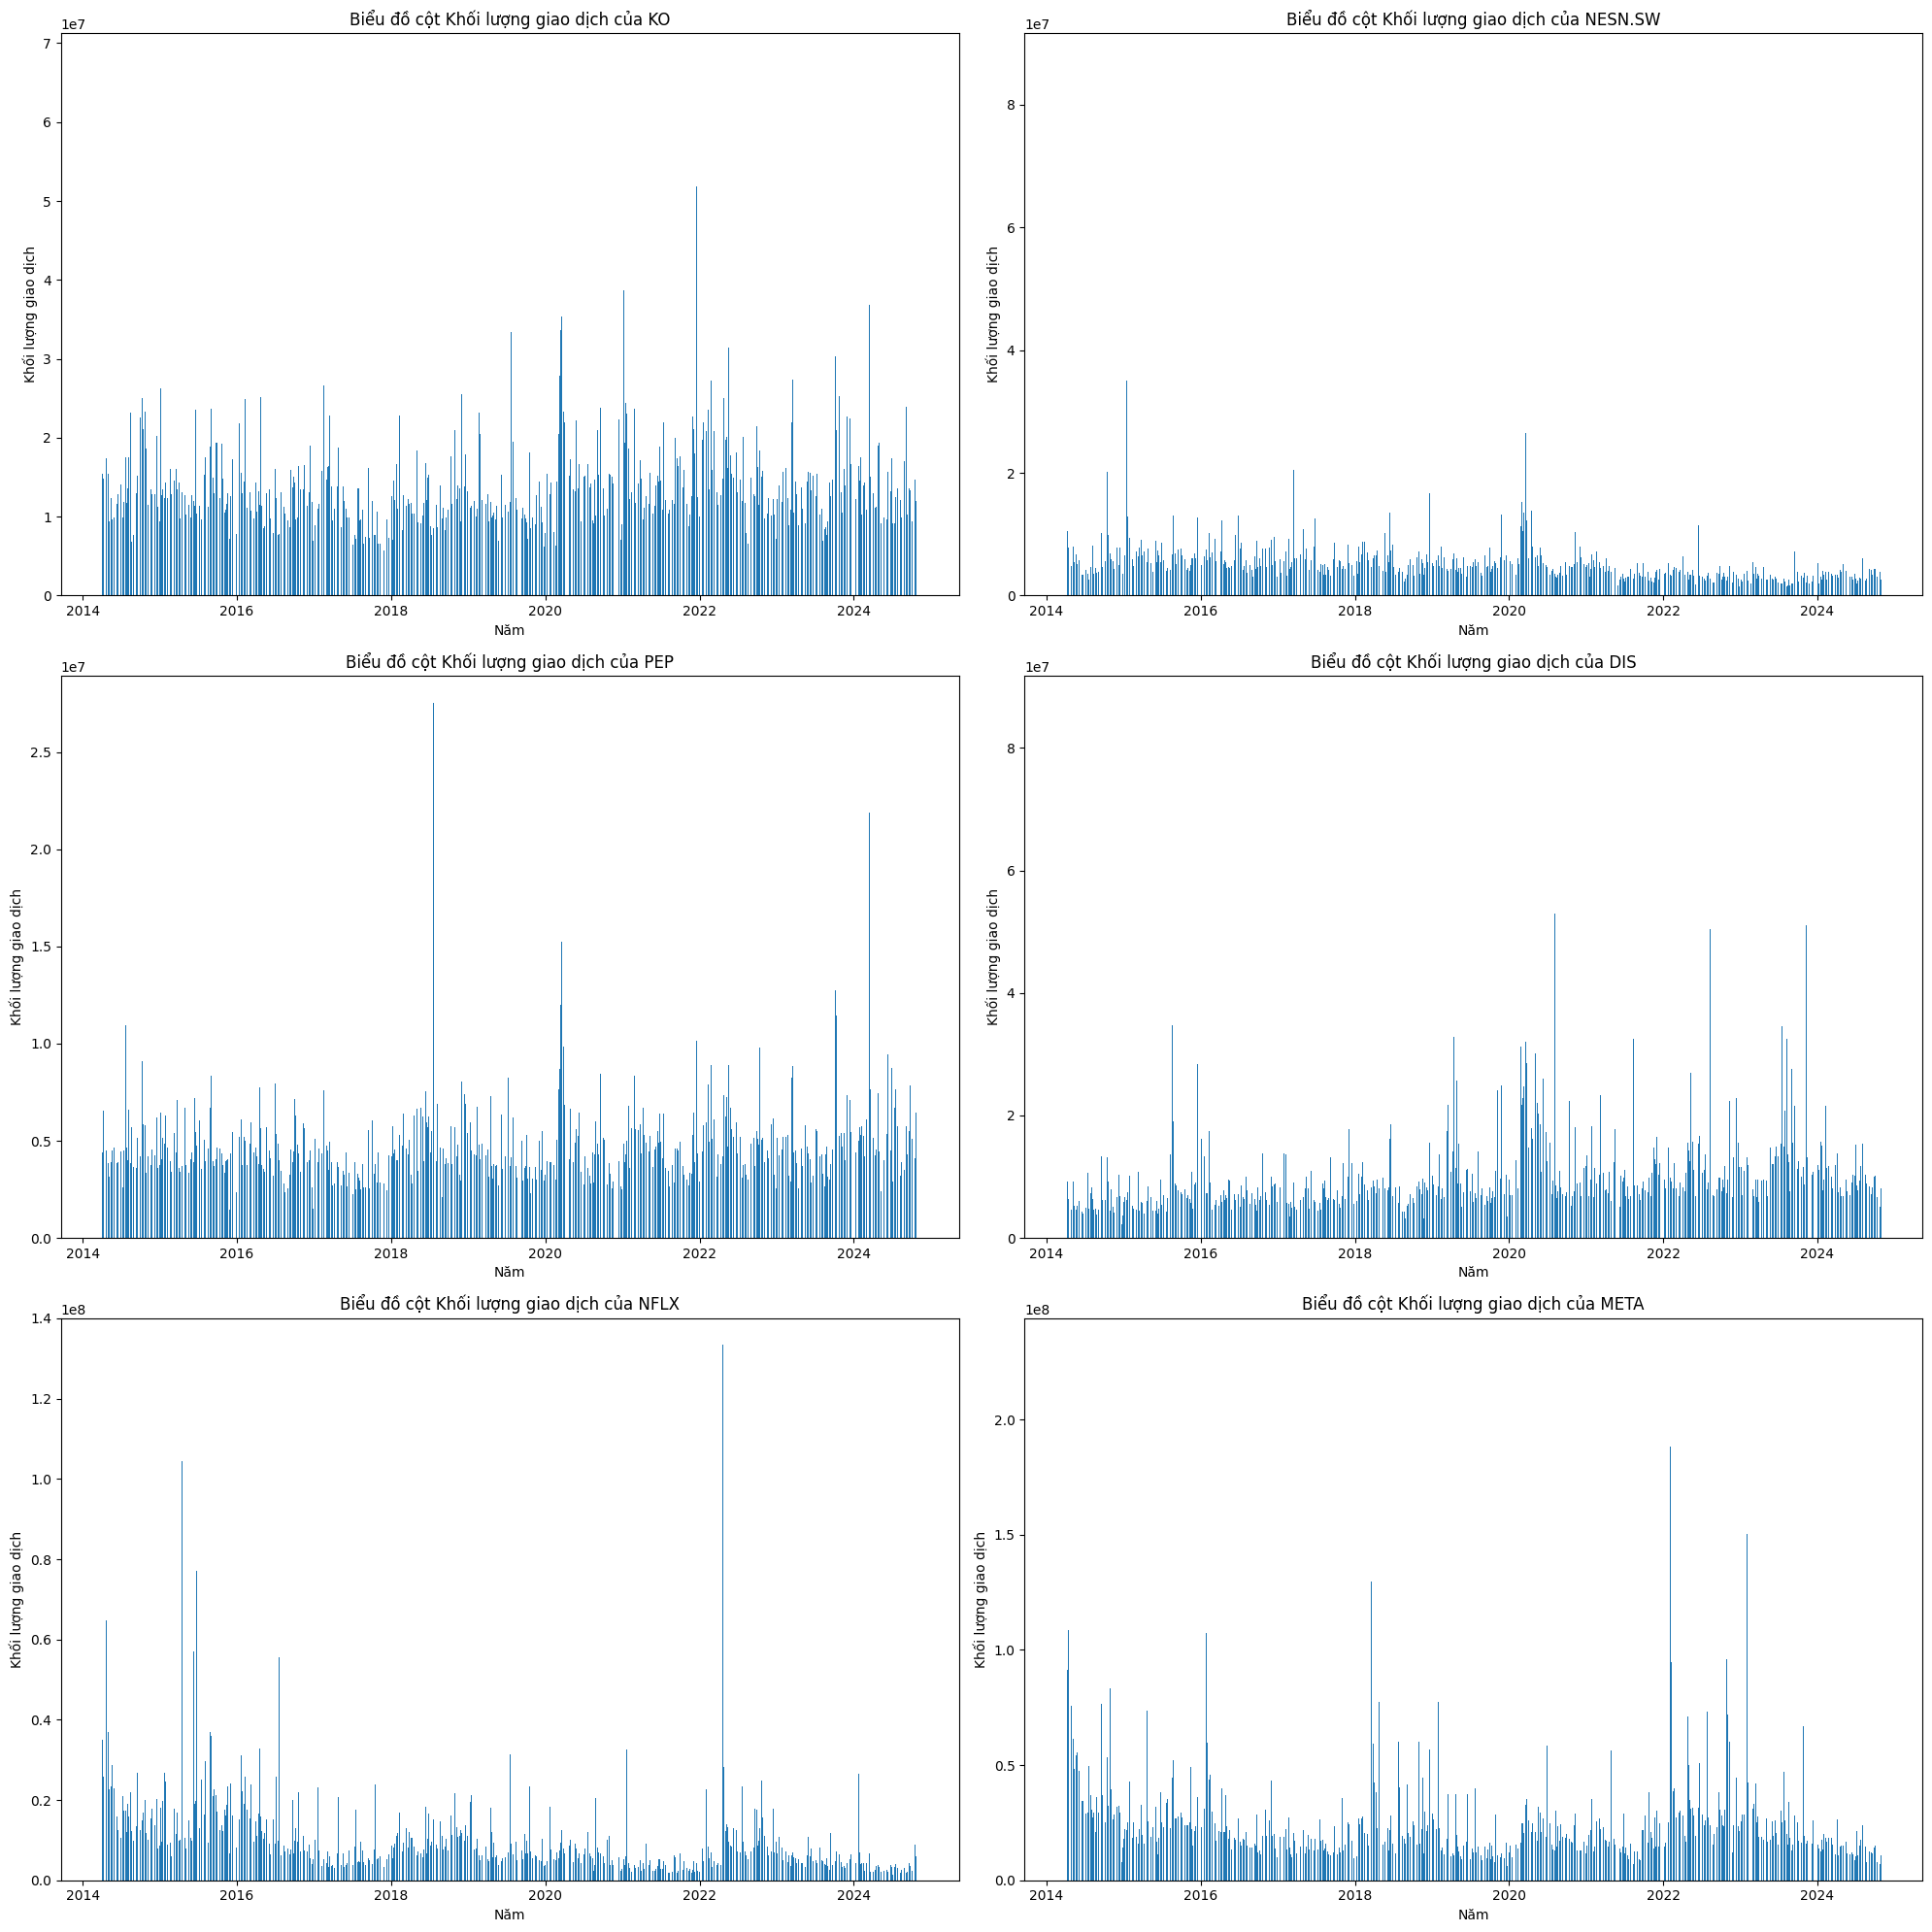

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=(20, 20))
i = 1
for ticker in tickers:
    plt.subplot(3, 2, i) # Chia cửa sổ hiển thị thành 5 hàng và 2 cột
    plt.bar(stock_data[ticker]["Date"], stock_data[ticker]["Volume"])
    plt.title(f'Biểu đồ cột Khối lượng giao dịch của {ticker}') # Đặt tiêu đề cho biểu đồ
    plt.xlabel('Năm') # Đặt tên cho trục x
    plt.ylabel('Khối lượng giao dịch') # Đặt tên cho trục y
    plt.tight_layout() # Xét khoảng cách giữa các hàng
    i += 1 # Tăng i lên 1 để chuyển sang vẽ biểu đồ của mã cổ phiếu tiếp theo


## Data preprocessing

### Missing value

In [ ]:
# Duyệt qua toàn bộ mã cổ phiếu trong tickers để kiểm tra xem có giá trị thiếu không
total_missing_values = 0
for ticker in tickers:
    total_missing_values += stock_data[ticker].isnull().sum()
print(total_missing_values)

Price
Date         0
Adj_Close    0
Close        0
High         0
Low          0
Open         0
Volume       0
dtype: int64


Bộ dữ liệu không có missing value

### Xử lý dữ liệu của `macro_data`
Nội suy tuyến tính để fill các giá trị trống đối từ quý sang tháng đổi với GDP


In [ ]:
# Chuyển Date thành một cột dữ liệu
macro_data = macro_data.reset_index()

In [ ]:
# Đổi tên cột index thành Date
macro_data = macro_data.rename(columns={"index": "Date"})

In [ ]:
macro_data.head()

Date        GDP      CPI  Unemployment_Rate  Fed_Funds_Rate
0 2014-04-01  18185.911  236.468                6.2            0.09
1 2014-05-01        NaN  236.918                6.3            0.09
2 2014-06-01        NaN  237.231                6.1            0.10
3 2014-07-01  18406.941  237.498                6.2            0.09
4 2014-08-01        NaN  237.460                6.1            0.09

In [ ]:
# Nội suy tuyến tính dữ liệu GDP
macro_data['GDP'] = macro_data['GDP'].interpolate(method='linear')

In [ ]:
macro_data.head()

Date           GDP      CPI  Unemployment_Rate  Fed_Funds_Rate
0 2014-04-01  18185.911000  236.468                6.2            0.09
1 2014-05-01  18259.587667  236.918                6.3            0.09
2 2014-06-01  18333.264333  237.231                6.1            0.10
3 2014-07-01  18406.941000  237.498                6.2            0.09
4 2014-08-01  18437.971000  237.460                6.1            0.09

In [ ]:
df = macro_data.copy()

### Hợp nhất 2 bộ dữ liệu

In [ ]:
stock_data['KO'].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2665 entries, 0 to 2664
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2665 non-null   datetime64[ns]
 1   Adj_Close  2665 non-null   float64       
 2   Close      2665 non-null   float64       
 3   High       2665 non-null   float64       
 4   Low        2665 non-null   float64       
 5   Open       2665 non-null   float64       
 6   Volume     2665 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 145.9 KB


In [ ]:
merge_data = {}
for ticker in tickers:
    # Hợp nhất dữ liệu với outer join
    merge_data[ticker] = pd.merge(stock_data[ticker], macro_data, on='Date', how='outer')

In [ ]:
# Nội suy để fill các missing value
# vì date của macro_data theo tháng và date của stock_data theo ngày
for ticker in tickers:
    merge_data[ticker] = merge_data[ticker].interpolate(method='linear')

In [ ]:
merge_data['META'].head()

Date  Adj_Close      Close       High        Low       Open  \
0 2014-04-01  62.381706  62.619999  62.660000  60.240002  60.459999   
1 2014-04-02  62.481327  62.720001  63.910000  62.209999  63.209999   
2 2014-04-03  59.263622  59.490002  63.169998  59.130001  62.549999   
3 2014-04-04  56.534046  56.750000  60.200001  56.320000  59.939999   
4 2014-04-07  56.733284  56.950001  58.000000  55.439999  55.900002   

        Volume           GDP         CPI  Unemployment_Rate  Fed_Funds_Rate  
0   59291000.0  18185.911000  236.468000           6.200000            0.09  
1   66277000.0  18189.419413  236.489429           6.204762            0.09  
2   83859000.0  18192.927825  236.510857           6.209524            0.09  
3  125214400.0  18196.436238  236.532286           6.214286            0.09  
4  108488000.0  18199.944651  236.553714           6.219048            0.09

In [ ]:
# Kiểm tra lại lần nữa xem còn giá trị nào bị thiếu không
total_missing_values = 0
for ticker in tickers:
    total_missing_values += merge_data[ticker].isnull().sum()
print(total_missing_values)

Date                 0
Adj_Close            0
Close                0
High                 0
Low                  0
Open                 0
Volume               0
GDP                  0
CPI                  0
Unemployment_Rate    0
Fed_Funds_Rate       0
dtype: int64


### Tạo dữ liệu đặc trưng (Time Features)
- Ngày trong tuần (Monday = 0, Sunday = 6)
- Tháng trong năm (1 đến 12)
- Quý (Quarter: 1 đến 4)

In [ ]:
# Tạo các đặc trưng thời gian
for ticker in tickers:
    merge_data[ticker]['Day_of_Week'] = merge_data[ticker]['Date'].dt.dayofweek
    merge_data[ticker]['Month'] = merge_data[ticker]['Date'].dt.month
    merge_data[ticker]['Quarter'] = merge_data[ticker]['Date'].dt.quarter

In [ ]:
merge_data["META"].tail()

Date   Adj_Close       Close        High         Low        Open  \
2702 2024-10-24  567.322388  567.780029  568.880005  561.520020  567.130005   
2703 2024-10-25  572.787964  573.250000  581.289978  571.719971  573.929993   
2704 2024-10-28  577.693970  578.159973  583.750000  574.119995  582.000000   
2705 2024-10-29  592.801880  593.280029  593.669983  575.400024  580.150024   
2706 2024-10-30  591.322998  591.799988  601.200012  589.380005  600.979980   

          Volume        GDP      CPI  Unemployment_Rate  Fed_Funds_Rate  \
2702   7184700.0  23386.733  315.454                4.1            4.83   
2703  11337900.0  23386.733  315.454                4.1            4.83   
2704  10925100.0  23386.733  315.454                4.1            4.83   
2705  13019100.0  23386.733  315.454                4.1            4.83   
2706  26864900.0  23386.733  315.454                4.1            4.83   

      Day_of_Week  Month  Quarter  
2702            3     10        4  
2703            4     10        4  
2704            0     10        4  
2705            1     10        4  
2706            2     10        4

### Chia dữ liệu train/test
Nhóm chọn dấu mốc chia là ngày 1/1/2024

In [ ]:
train_data = {} # Chọn dữ liệu từ 2014-04-01 đến 2022-01-01 để train
test_data = {} # Chọn dữ liệu từ 2022-01-01 đến 2024-10-31 để test

In [ ]:
for ticker in tickers:
    train_data[ticker] = merge_data[ticker][merge_data[ticker]['Date'] < '2022-01-01']
    test_data[ticker] = merge_data[ticker][merge_data[ticker]['Date'] >= '2022-01-01']

In [ ]:
# Tạo các biến đầu vào và đầu ra
x_train = {}
x_test = {}
y_train = {}
y_test = {}
x_val = {}
y_val = {}
y_date = {}

In [ ]:
for ticker in tickers:
    x_train[ticker] = train_data[ticker][['Adj_Close', 'Close', 'High', 'Low', 'Volume', 'GDP', 'CPI', 'Unemployment_Rate', 'Fed_Funds_Rate', 'Day_of_Week', 'Month', 'Quarter']]
    y_train[ticker] = train_data[ticker]['Open']
    x_test[ticker] = test_data[ticker][['Adj_Close', 'Close', 'High', 'Low', 'Volume', 'GDP', 'CPI', 'Unemployment_Rate', 'Fed_Funds_Rate', 'Day_of_Week', 'Month', 'Quarter']]
    y_test[ticker] = test_data[ticker]['Open']
    y_date[ticker] = test_data[ticker]['Date']

for ticker in tickers:
    _, x_val[ticker], _, y_val[ticker] = train_test_split(x_train[ticker], y_train[ticker], test_size=0.2, random_state=42)

for ticker in tickers:
    _, x, _, y = train_test_split(x_test[ticker], y_test[ticker], test_size=0.2, random_state=42)
    x_val[ticker] = pd.concat([x_val[ticker], x], axis=0, ignore_index=False)
    y_val[ticker] = pd.concat([y_val[ticker], y], axis=0, ignore_index=False)
    x_val[ticker] = x_val[ticker].sort_index()
    y_val[ticker] = y_val[ticker].sort_index()

In [ ]:
print(stock_data["META"].shape)
for ticker in tickers:
  print(f"{ticker}: {y_train[ticker].shape}")
  print(f"{ticker}: {y_test[ticker].shape}")

(2665, 7)
KO: (1986, 1)
KO: (721, 1)
NESN.SW: (1990, 1)
NESN.SW: (731, 1)
PEP: (1986, 1)
PEP: (721, 1)
DIS: (1986, 1)
DIS: (721, 1)
NFLX: (1986, 1)
NFLX: (721, 1)
META: (1986, 1)
META: (721, 1)


In [ ]:
train_data["META"].tail()

Date   Adj_Close       Close        High         Low        Open  \
1981 2021-12-27  344.862640  346.179993  347.869995  338.010010  338.850006   
1982 2021-12-28  344.902496  346.220001  352.709991  345.200012  346.630005   
1983 2021-12-29  341.634979  342.940002  349.690002  341.640015  346.910004   
1984 2021-12-30  343.049561  344.359985  347.230011  343.220001  344.000000   
1985 2021-12-31  335.070099  336.350006  343.440002  336.269989  343.019989   

          Volume           GDP         CPI  Unemployment_Rate  Fed_Funds_Rate  \
1981  17795000.0  21908.133182  282.030455           3.977273            0.08   
1982  16637600.0  21907.276545  282.102364           3.981818            0.08   
1983  10747000.0  21906.419909  282.174273           3.986364            0.08   
1984  10593300.0  21905.563273  282.246182           3.990909            0.08   
1985  12870500.0  21904.706636  282.318091           3.995455            0.08   

      Day_of_Week  Month  Quarter  
1981            0     12        4  
1982            1     12        4  
1983            2     12        4  
1984            3     12        4  
1985            4     12        4

In [ ]:
# Khởi tạo MinMaxScaler để scale dữ liệu
scaler_train = MinMaxScaler()
scaler_test = MinMaxScaler()
scaler_val = MinMaxScaler()

x_train_scaled = {}
x_test_scaled = {}
x_val_scaled = {}

for ticker in tickers:
    x_train_scaled[ticker] = pd.DataFrame(
        scaler_train.fit_transform(x_train[ticker][x_train[ticker].columns]),
        columns=x_train[ticker].columns,
        index=x_train[ticker].index
    )

    y_train[ticker] = pd.DataFrame(
        scaler_train.fit_transform(y_train[ticker].values.reshape(-1, 1)),
        columns=['Open'],
        index=train_data[ticker].index
    )

    x_test_scaled[ticker] = pd.DataFrame(
        scaler_test.fit_transform(x_test[ticker][x_test[ticker].columns]),
        columns=x_test[ticker].columns,
        index=x_test[ticker].index
    )

    y_test[ticker] = pd.DataFrame(
        scaler_test.fit_transform(y_test[ticker].values.reshape(-1, 1)),
        columns=['Open'],
        index=test_data[ticker].index
    )

    x_val_scaled[ticker] = pd.DataFrame(
        scaler_val.fit_transform(x_val[ticker][x_val[ticker].columns]),
        columns=x_val[ticker].columns,
        index=x_val[ticker].index
    )

    y_val[ticker] = pd.DataFrame(
        scaler_val.fit_transform(y_val[ticker].values.reshape(-1, 1)),
        columns=['Open'],
        index=y_val[ticker].index
    )

In [ ]:
x_train_scaled["META"].head()

Adj_Close     Close      High       Low    Volume       GDP       CPI  \
0   0.019875  0.019875  0.015336  0.017214  0.325692  0.000000  0.036177   
1   0.020182  0.020182  0.019162  0.023292  0.368318  0.000930  0.036628   
2   0.010275  0.010275  0.016897  0.013790  0.475597  0.001859  0.037078   
3   0.001871  0.001871  0.007806  0.005121  0.727933  0.002789  0.037529   
4   0.002484  0.002484  0.001071  0.002406  0.625874  0.003718  0.037979   

   Unemployment_Rate  Fed_Funds_Rate  Day_of_Week     Month   Quarter  
0           0.238938        0.016878     0.166667  0.272727  0.333333  
1           0.239359        0.016878     0.333333  0.272727  0.333333  
2           0.239781        0.016878     0.500000  0.272727  0.333333  
3           0.240202        0.016878     0.666667  0.272727  0.333333  
4           0.240624        0.016878     0.000000  0.272727  0.333333

In [ ]:
x_test_scaled["META"].head()

Adj_Close     Close      High       Low    Volume       GDP       CPI  \
1986   0.488450  0.490178  0.491327  0.495427  0.036309  0.000000  0.000000   
1987   0.490602  0.492338  0.489024  0.496344  0.039984  0.000165  0.003089   
1988   0.486651  0.488373  0.492946  0.485743  0.046421  0.000329  0.006178   
1989   0.462360  0.463996  0.478643  0.469743  0.066551  0.000494  0.009268   
1990   0.478652  0.480346  0.485297  0.467511  0.099164  0.000658  0.012357   

      Unemployment_Rate  Fed_Funds_Rate  Day_of_Week  Month  Quarter  
1986           0.666667             0.0     0.833333    0.0      0.0  
1987           0.656085             0.0     0.000000    0.0      0.0  
1988           0.645503             0.0     0.166667    0.0      0.0  
1989           0.634921             0.0     0.333333    0.0      0.0  
1990           0.624339             0.0     0.500000    0.0      0.0

In [ ]:
x_val_scaled["META"].head()

Adj_Close     Close      High       Low    Volume       GDP       CPI  \
23   0.005929  0.005949  0.005354  0.003511  0.222223  0.000000  0.027269   
29   0.003354  0.003365  0.004505  0.004130  0.235735  0.004111  0.028377   
30   0.002242  0.002249  0.003692  0.003079  0.229734  0.004797  0.028562   
32   0.000000  0.000000  0.000000  0.000000  0.232494  0.006167  0.028931   
44   0.008986  0.009016  0.009176  0.009406  0.146450  0.014327  0.031079   

    Unemployment_Rate  Fed_Funds_Rate  Day_of_Week     Month   Quarter  
23           0.251731        0.007756     0.000000  0.363636  0.333333  
29           0.246711        0.008297     0.166667  0.363636  0.333333  
30           0.245875        0.008387     0.333333  0.363636  0.333333  
32           0.244202        0.008568     0.666667  0.363636  0.333333  
44           0.236635        0.009298     0.166667  0.454545  0.333333

# Train, Test & Đánh giá model

## Feedforward Neural Network (FNN)

Dạng đầu vào của mô hình FNN là một mảng 2D, với (số lượng mẫu, số lượng đặc trưng). Mà dữ liệu đầu vào đang ở dạng 2D và khớp với đầu vào của mô hình nên không cần xử lý gì thêm

### Xây dựng mô hình FNN dự đoán giá mở của của các mã cổ phiếu

In [ ]:
fnn_model = {}
for ticker in tickers:
    fnn_model[ticker] = Sequential([
        Dense(150, activation='tanh', input_shape=(x_train_scaled[ticker].shape[1],)),  # Input layer
        Dropout(0.2),
        Dense(150, activation='tanh'),  # Hidden layer
        Dropout(0.2),
        Dense(1)  # Output layer
    ])

In [ ]:
# Compile mô hình
for ticker in tickers:
    fnn_model[ticker].compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# Huấn luyện mô hình
history_fnn = {}
for ticker in tickers:
    history_fnn[ticker] = fnn_model[ticker].fit(
        x_train_scaled[ticker], y_train[ticker],
        epochs=30,
        batch_size=16,
        validation_data=(x_val_scaled[ticker], y_val[ticker]),
        callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)]
    )

Epoch 1/30
125/125 [==============================] - 1s 4ms/step - loss: 0.0278 - mae: 0.1170 - val_loss: 7.2117e-04 - val_mae: 0.0225
Epoch 2/30
125/125 [==============================] - 0s 2ms/step - loss: 0.0075 - mae: 0.0657 - val_loss: 0.0047 - val_mae: 0.0658
Epoch 3/30
125/125 [==============================] - 0s 2ms/step - loss: 0.0051 - mae: 0.0532 - val_loss: 2.6119e-04 - val_mae: 0.0130
Epoch 4/30
125/125 [==============================] - 0s 2ms/step - loss: 0.0038 - mae: 0.0474 - val_loss: 0.0031 - val_mae: 0.0515
Epoch 5/30
125/125 [==============================] - 0s 2ms/step - loss: 0.0034 - mae: 0.0440 - val_loss: 8.4305e-04 - val_mae: 0.0224
Epoch 6/30
125/125 [==============================] - 0s 2ms/step - loss: 0.0028 - mae: 0.0404 - val_loss: 0.0036 - val_mae: 0.0535
Epoch 7/30
125/125 [==============================] - 0s 3ms/step - loss: 0.0026 - mae: 0.0389 - val_loss: 7.5291e-04 - val_mae: 0.0247
Epoch 8/30
125/125 [==============================] - 0s 2ms

In [ ]:
# Hàm vẽ biểu đồ dự đoán giá mở của cổ phiếu
def plot_prediction_fnn(ticker):
    plt.figure(figsize=(20, 10))
    plt.plot(y_date[ticker], y_test[ticker], label='Giá thực tế', color='b')
    plt.plot(y_date[ticker], fnn_model[ticker].predict(x_test_scaled[ticker]), label='Giá dự đoán FNN', color='r')
    plt.title(f'Biểu đồ dự đoán giá mở cửa của {ticker} - FNN')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá cổ phiếu (USD)')
    plt.legend()
    plt.show()

23/23 [==============================] - 0s 1ms/step


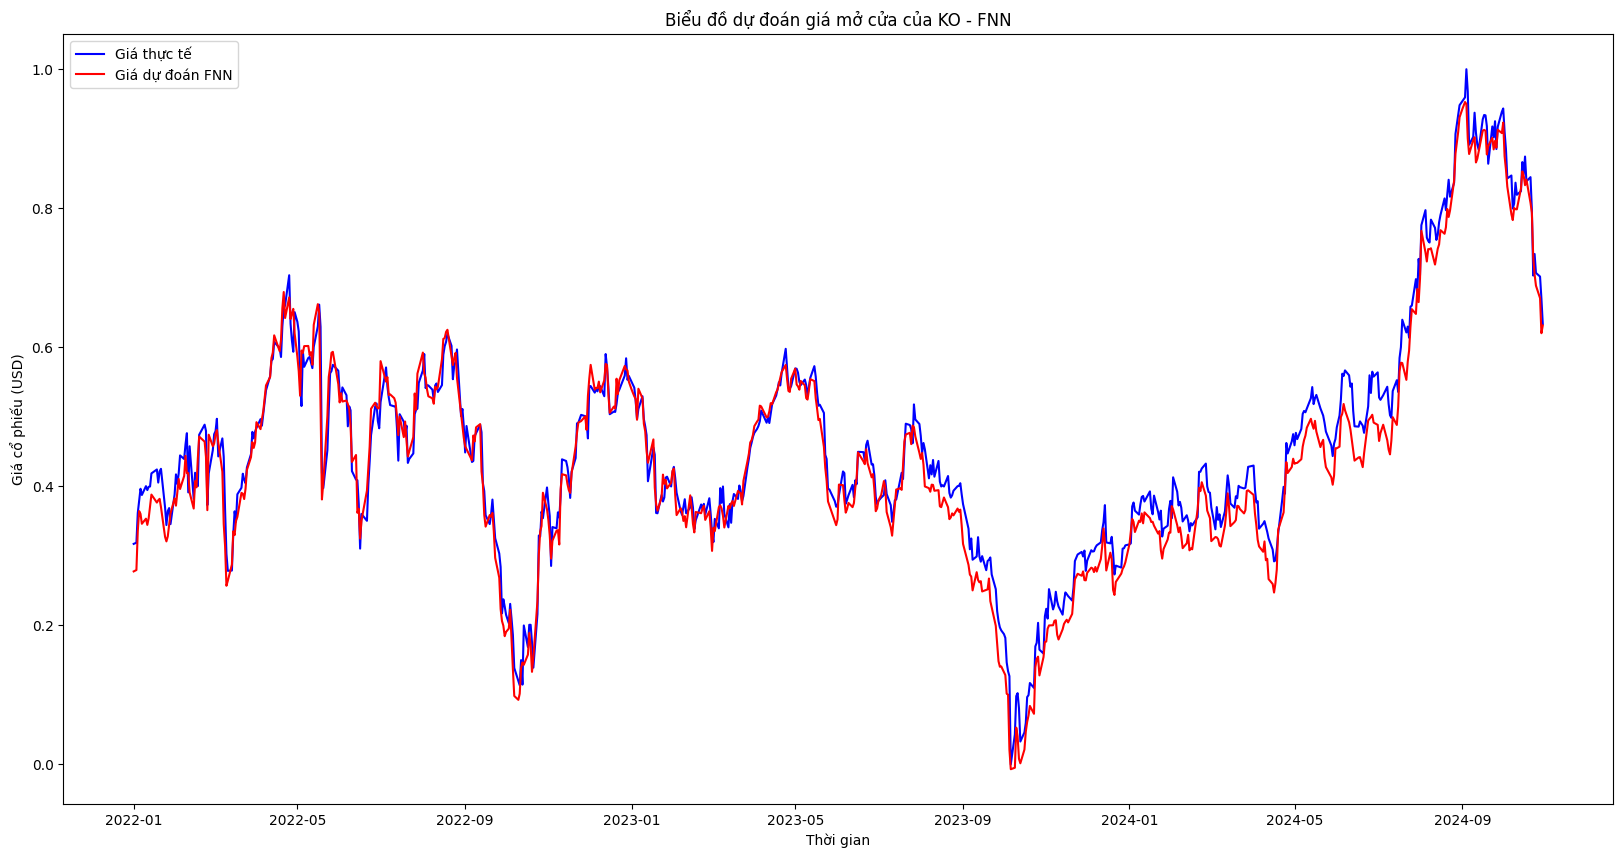

23/23 [==============================] - 0s 1ms/step


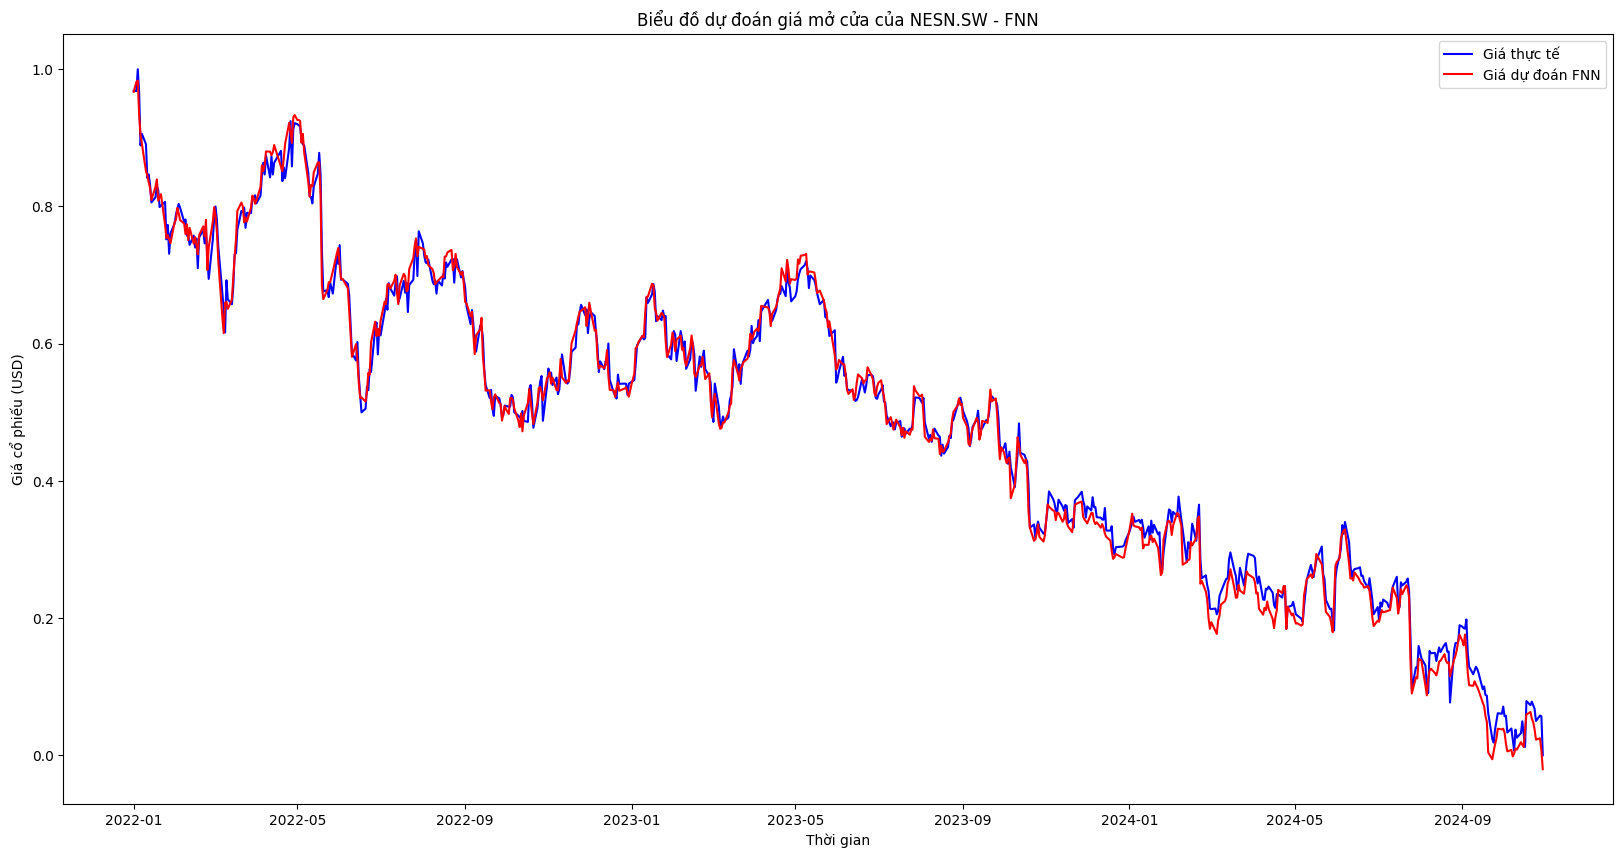

23/23 [==============================] - 0s 1ms/step


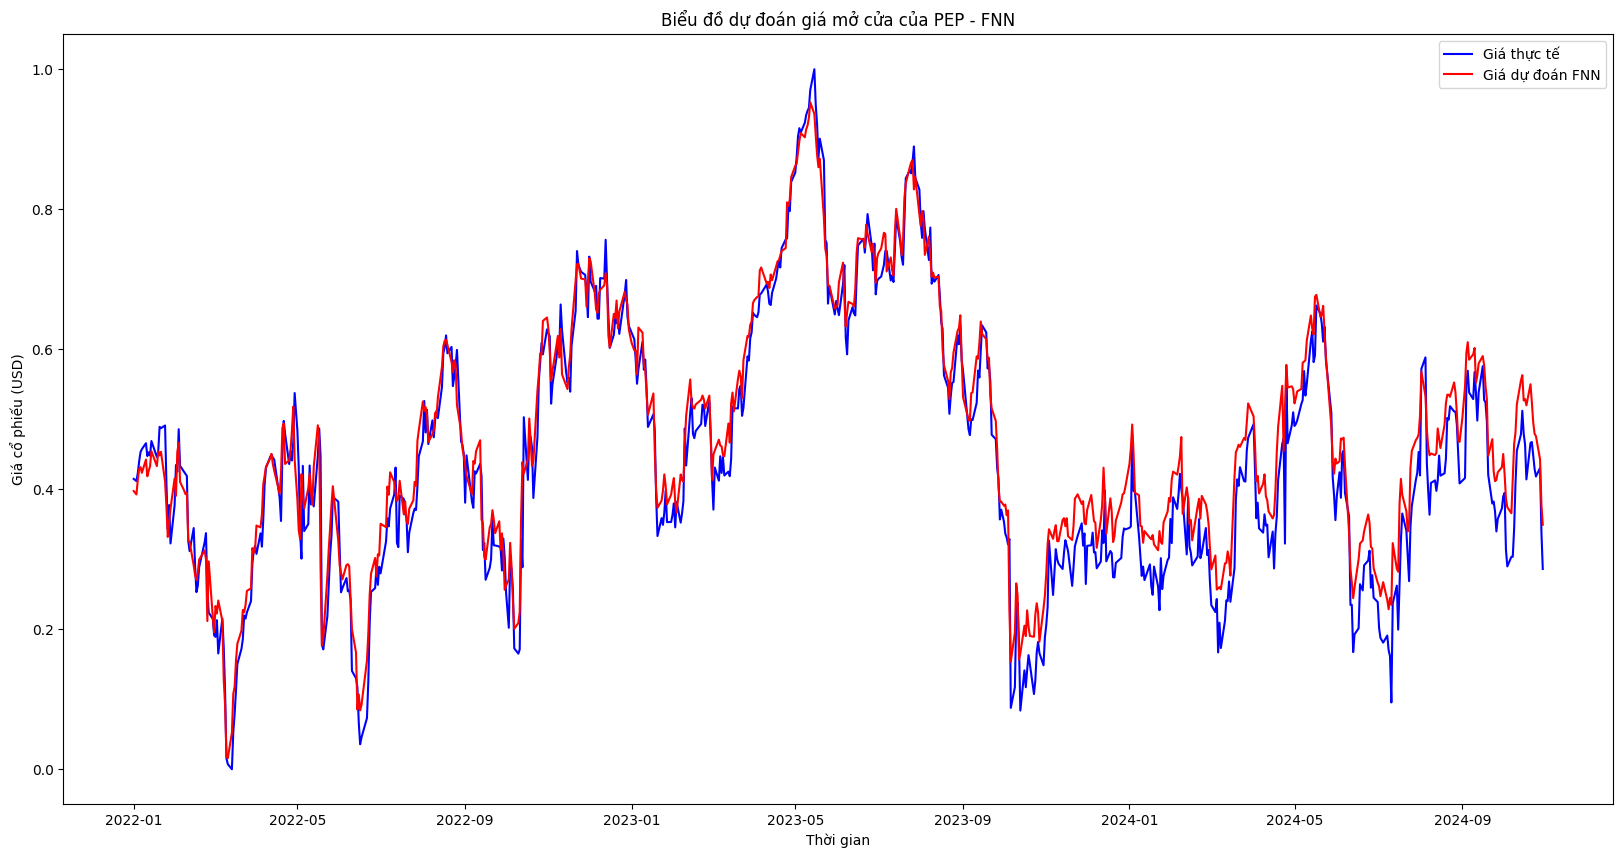

23/23 [==============================] - 0s 1ms/step


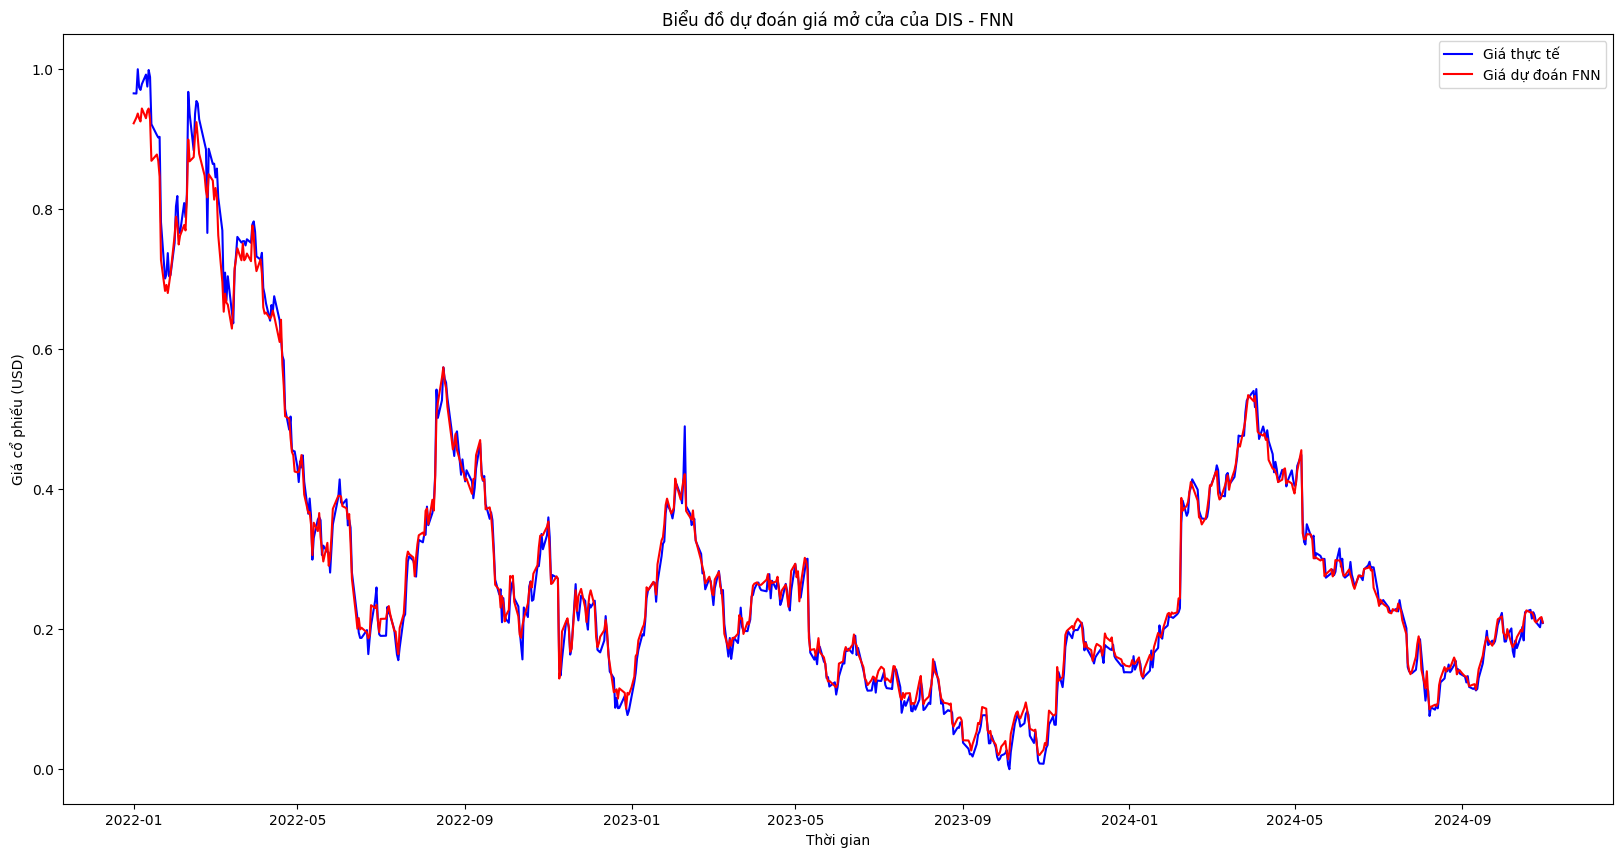

23/23 [==============================] - 0s 1ms/step


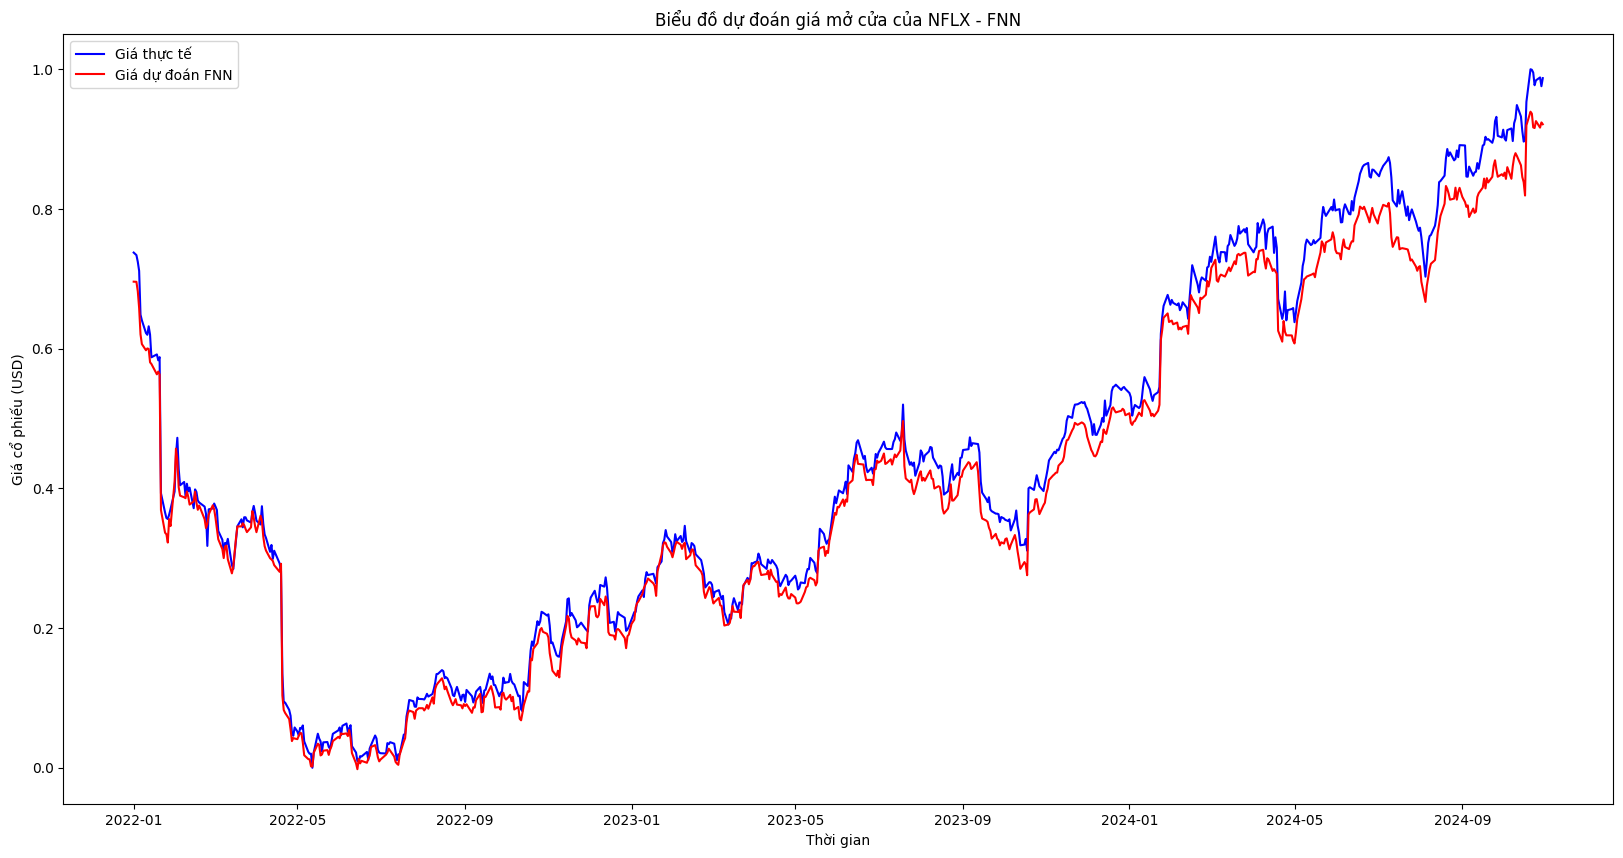

23/23 [==============================] - 0s 1ms/step


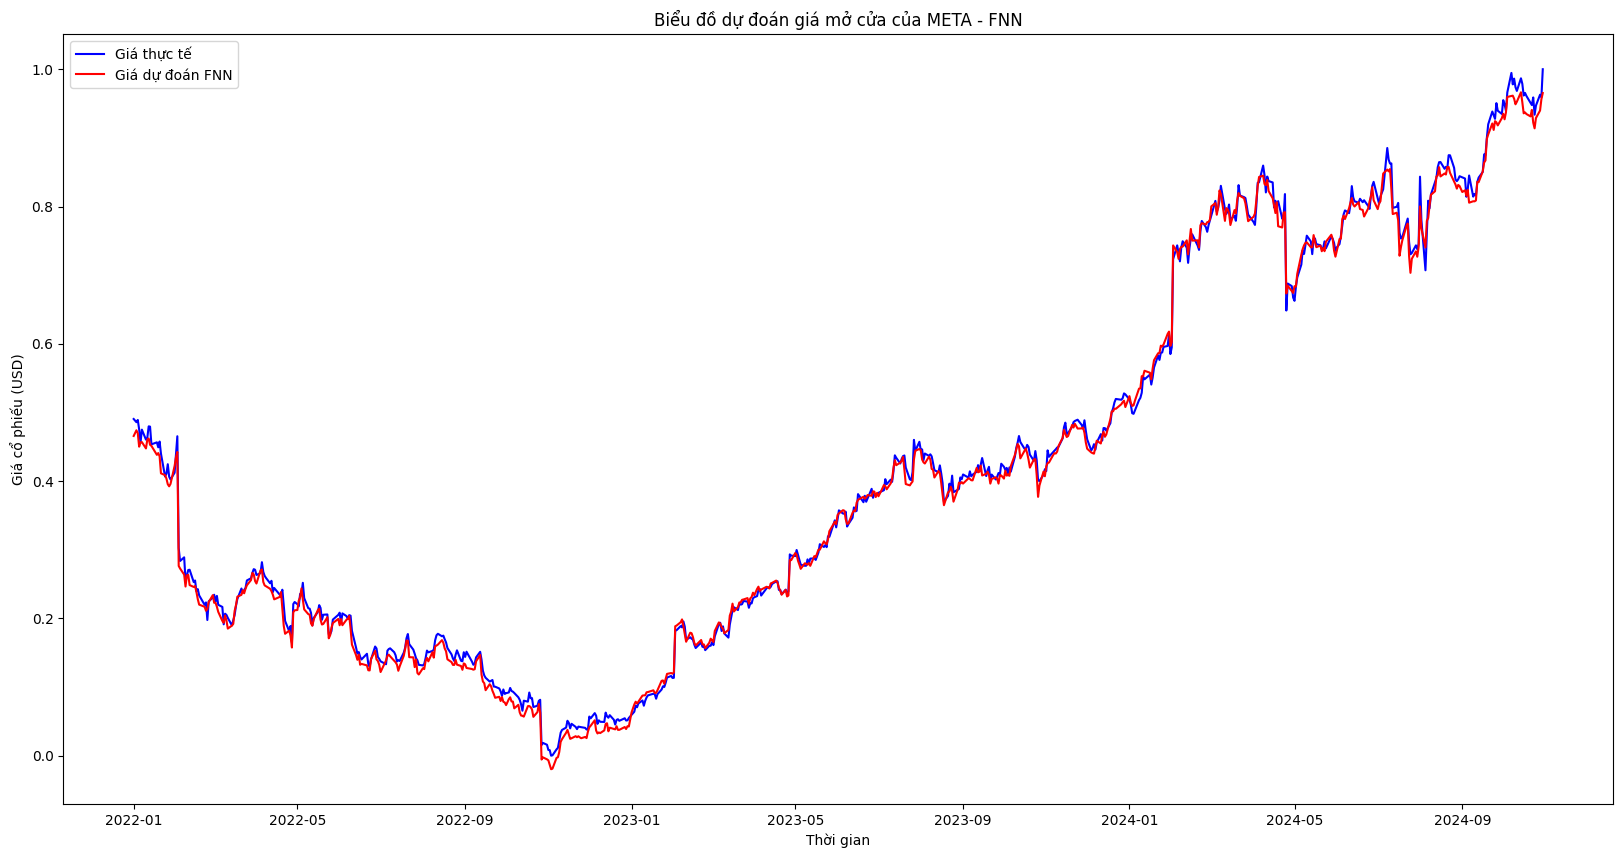

In [ ]:
# Vẽ biểu đồ dự đoán giá mở của cổ phiếu
for ticker in tickers:
    plot_prediction_fnn(ticker)

In [ ]:
# Hàm vẽ biểu đồ loss (train & validation) qua các epochs
def plot_loss_fnn(ticker):
    plt.figure(figsize=(12, 7))
    plt.plot(history_fnn[ticker].history['loss'], label='Training loss', color='b')
    plt.plot(history_fnn[ticker].history['val_loss'], label='Validation loss', color='r')
    plt.title(f'Biểu đồ loss qua các epochs của {ticker} (FNN)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


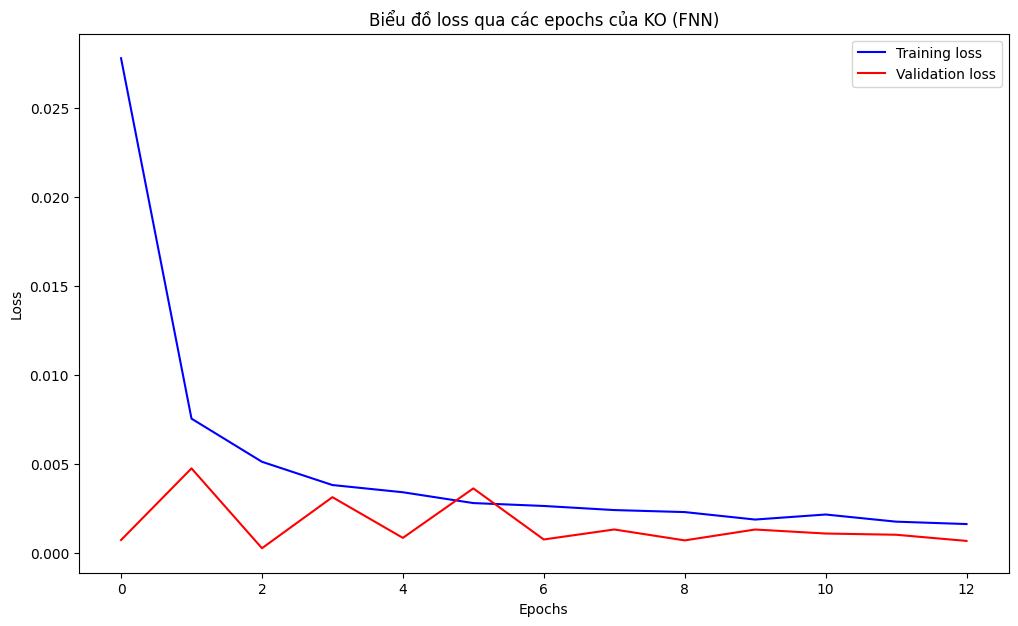

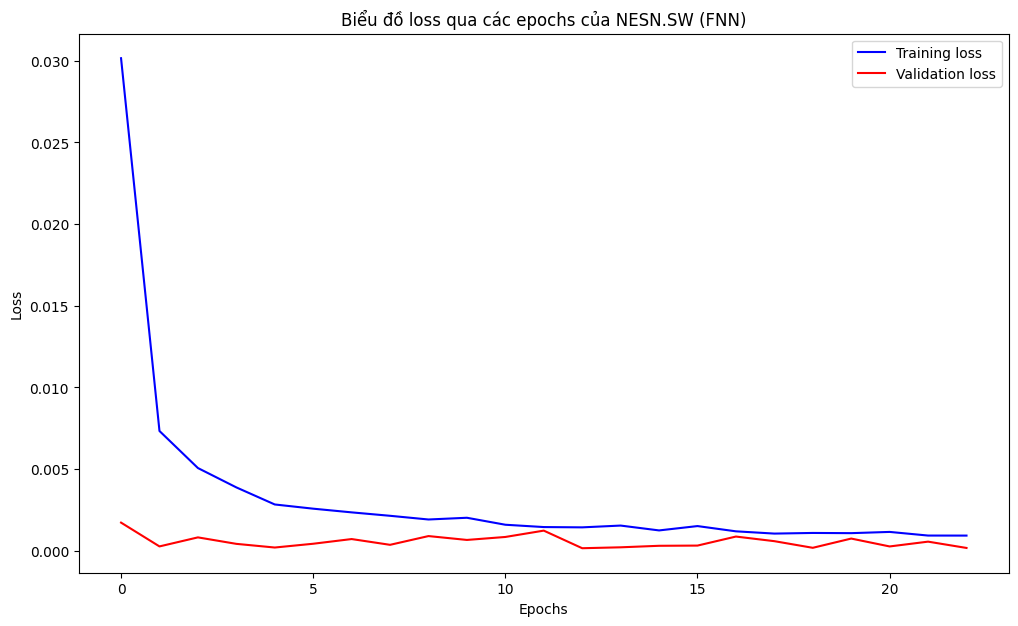

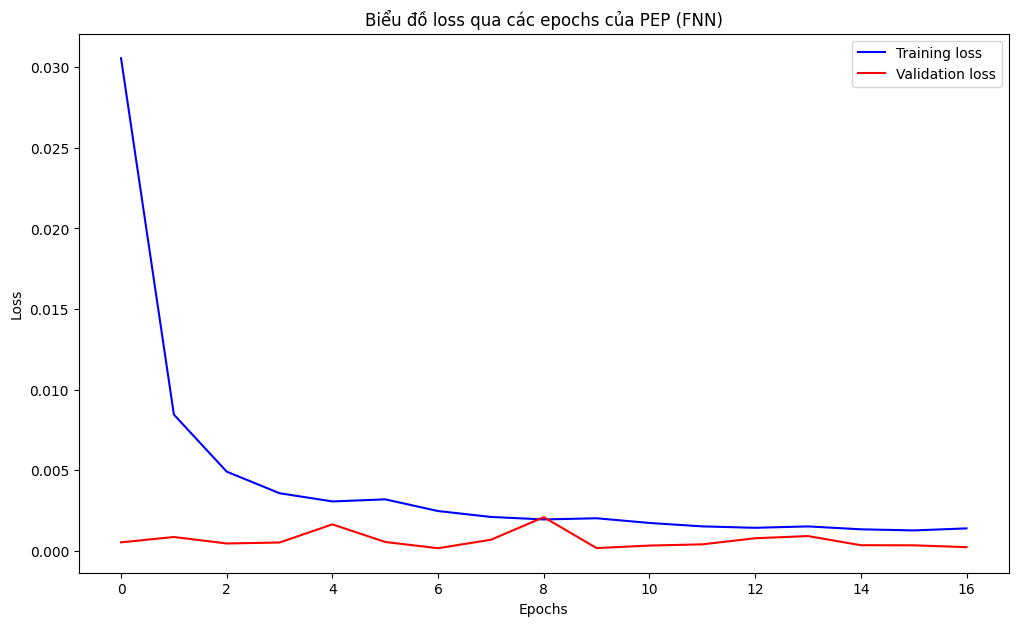

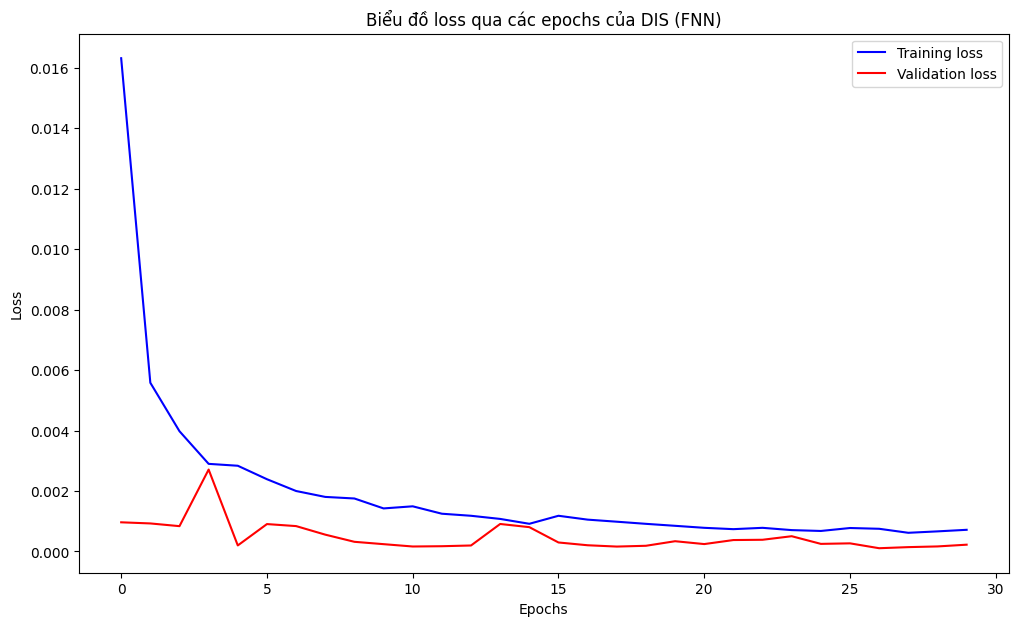

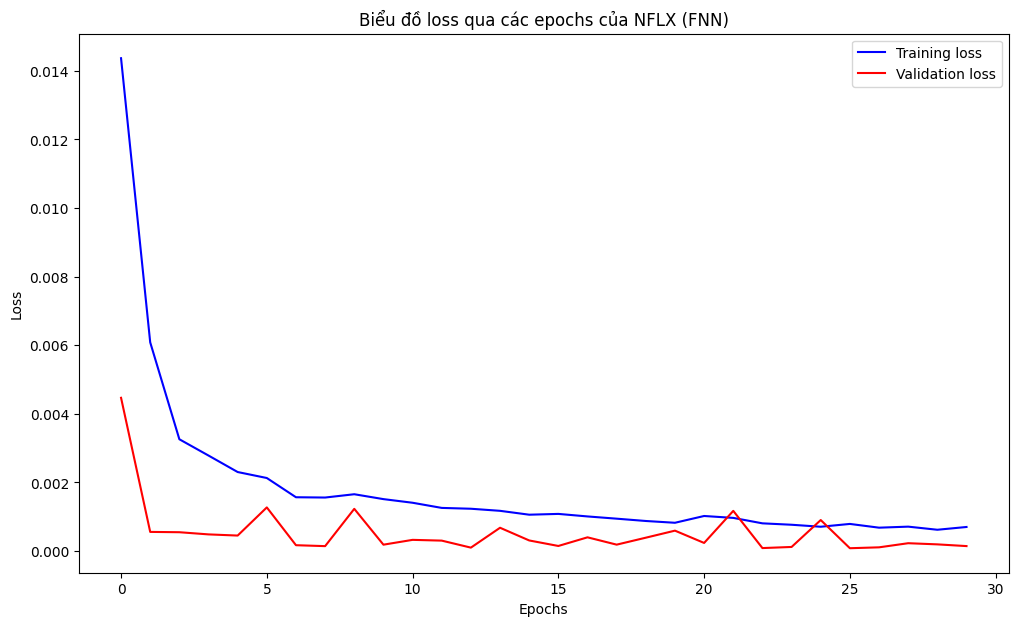

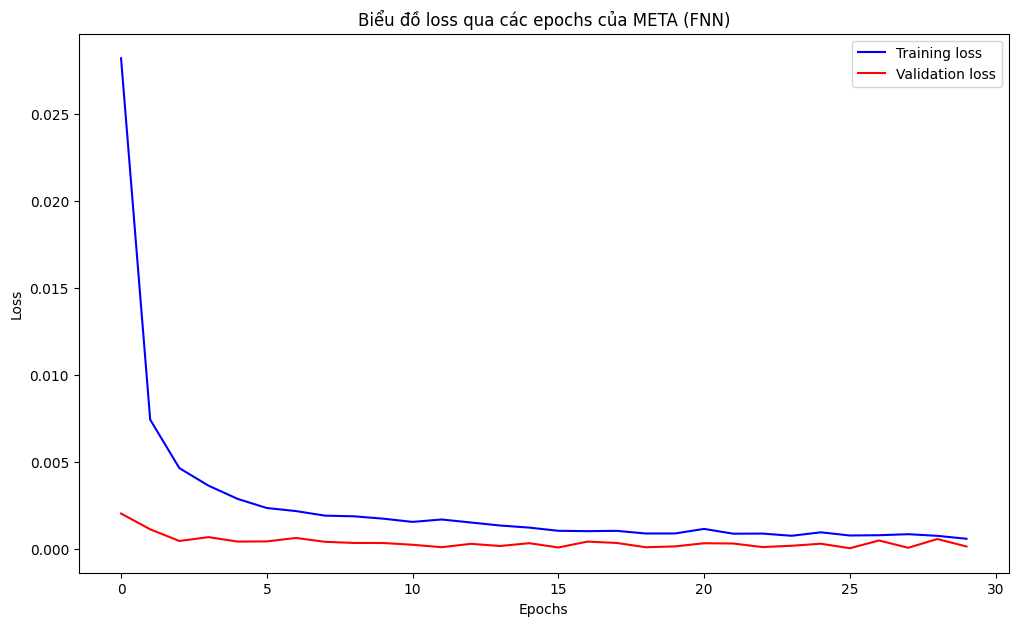

In [ ]:
# Vẽ biểu đồ loss qua các epochs
for ticker in tickers:
    plot_loss_fnn(ticker)

In [ ]:
# Hàm tính các thang đo đánh giá mô hình
def evaluate_model_fnn(ticker):
    y_pred = fnn_model[ticker].predict(x_test_scaled[ticker])
    mae = mean_absolute_error(y_test[ticker], y_pred)
    mse = mean_squared_error(y_test[ticker], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[ticker], y_pred)
    print(f'Thông số đánh giá mô hình FNN cho mã cổ phiếu {ticker}:')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R^2: {r2}')
    return mae, mse, rmse, r2

In [ ]:
evaluate_fnn = {}
# Đánh giá mô hình
for ticker in tickers:
    evaluate_fnn[ticker] = evaluate_model_fnn(ticker)

23/23 [==============================] - 0s 1ms/step
Thông số đánh giá mô hình FNN cho mã cổ phiếu KO:
MAE: 0.025761662051081657
MSE: 0.0009743323898874223
RMSE: 0.03121429784389555
R^2: 0.9657511711120605
23/23 [==============================] - 0s 1ms/step
Thông số đánh giá mô hình FNN cho mã cổ phiếu NESN.SW:
MAE: 0.014700616709887981
MSE: 0.00032896499033086
RMSE: 0.01813739204877206
R^2: 0.9931809902191162
23/23 [==============================] - 0s 1ms/step
Thông số đánh giá mô hình FNN cho mã cổ phiếu PEP:
MAE: 0.03757317736744881
MSE: 0.002156407805159688
RMSE: 0.04643713821026968
R^2: 0.9364314079284668
23/23 [==============================] - 0s 1ms/step
Thông số đánh giá mô hình FNN cho mã cổ phiếu DIS:
MAE: 0.012753287330269814
MSE: 0.0003015005786437541
RMSE: 0.01736377201657964
R^2: 0.9933639168739319
23/23 [==============================] - 0s 1ms/step
Thông số đánh giá mô hình FNN cho mã cổ phiếu NFLX:
MAE: 0.026822734624147415
MSE: 0.001028097583912313
RMSE: 0.03206396

## Recurrent Neural Network - RNN

Dạng đầu vào của RNN là một mảng 3D với kích thước (số mẫu, số bước thời gian, số đặc trưng)
Nhóm sẽ tiến hành thêm một bước thời gian vào dữ liệu đầu vào để tạo thành một chuỗi thời gian

In [ ]:
# Tạo bước thời gian time_step
def create_rnn_input(x, y, time_steps):
    x_rnn, y_rnn = [], []
    for i in range(time_steps, len(x)):
        x_rnn.append(x[i - time_steps: i])
        y_rnn.append(y[i])
    return np.array(x_rnn), np.array(y_rnn)

In [ ]:
# Tạo lại các tập train, test, validation riêng cho model rnn
x_train_rnn = {}
x_test_rnn = {}
x_val_rnn = {}
y_train_rnn = {}
y_test_rnn = {}
y_val_rnn = {}

time_steps = 1
for ticker in tickers:
    x_train_rnn[ticker], y_train_rnn[ticker] = create_rnn_input(x_train_scaled[ticker].values, y_train[ticker].values, time_steps)
    x_test_rnn[ticker], y_test_rnn[ticker] = create_rnn_input(x_test_scaled[ticker].values, y_test[ticker].values, time_steps)
    x_val_rnn[ticker], y_val_rnn[ticker] = create_rnn_input(x_val_scaled[ticker].values, y_val[ticker].values, time_steps)


In [ ]:
print(x_train_rnn["META"].shape, y_train_rnn["META"].shape)
print(x_test_rnn["META"].shape, y_test_rnn["META"].shape)
print(x_val_rnn["META"].shape, y_val_rnn["META"].shape)

(1985, 1, 12) (1985, 1)
(720, 1, 12) (720, 1)
(542, 1, 12) (542, 1)


### Xây dựng mô hình RNN dự đoán giá mở của của các mã cổ phiếu

In [ ]:
# Khởi tạo mô hình RNN cho từng ticker
rnn_model = {}
for ticker in tickers:
    rnn_model[ticker] = Sequential([
        SimpleRNN(150, activation='tanh', input_shape=(x_train_rnn[ticker].shape[1], x_train_rnn[ticker].shape[2]), return_sequences=True),  # Input layer
        Dropout(0.2),
        SimpleRNN(150, activation='tanh'),  # Hidden layer
        Dropout(0.2),
        Dense(1)  # Output layer
    ])

In [ ]:
# Compile mô hình
for ticker in tickers:
  rnn_model[ticker].compile(optimizer='adam', loss='mse', metrics=['mae'])

In [ ]:
# Huấn luyện mô hình
history_rnn = {}
for ticker in tickers:
    history_rnn[ticker] = rnn_model[ticker].fit(x_train_rnn[ticker], y_train_rnn[ticker],
                            validation_data=(x_val_rnn[ticker], y_val_rnn[ticker]),
                            epochs=30,
                            batch_size=16,
                            verbose=1,
                            callbacks=[EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)])


Epoch 1/30
125/125 [==============================] - 2s 5ms/step - loss: 0.0219 - mae: 0.1077 - val_loss: 0.0019 - val_mae: 0.0330
Epoch 2/30
125/125 [==============================] - 0s 3ms/step - loss: 0.0069 - mae: 0.0636 - val_loss: 0.0025 - val_mae: 0.0417
Epoch 3/30
125/125 [==============================] - 0s 3ms/step - loss: 0.0052 - mae: 0.0542 - val_loss: 0.0023 - val_mae: 0.0382
Epoch 4/30
125/125 [==============================] - 0s 3ms/step - loss: 0.0041 - mae: 0.0484 - val_loss: 0.0017 - val_mae: 0.0302
Epoch 5/30
125/125 [==============================] - 0s 3ms/step - loss: 0.0031 - mae: 0.0416 - val_loss: 0.0027 - val_mae: 0.0407
Epoch 6/30
125/125 [==============================] - 0s 3ms/step - loss: 0.0032 - mae: 0.0411 - val_loss: 0.0018 - val_mae: 0.0301
Epoch 7/30
125/125 [==============================] - 0s 3ms/step - loss: 0.0026 - mae: 0.0382 - val_loss: 0.0022 - val_mae: 0.0358
Epoch 8/30
125/125 [==============================] - 0s 3ms/step - loss: 0.

In [ ]:
# Hàm vẽ biểu đồ dự đoán giá mở của cổ phiếu
def plot_prediction_rnn(ticker):
    plt.figure(figsize=(20, 10))
    plt.plot(y_date[ticker][time_steps:], y_test[ticker][time_steps:], label='Giá thực tế', color='b')
    plt.plot(y_date[ticker][time_steps:], rnn_model[ticker].predict(x_test_rnn[ticker]), label='Giá dự đoán RNN', color='r')
    plt.title(f'Biểu đồ dự đoán giá mở cửa của {ticker} - RNN')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá cổ phiếu (USD)')
    plt.legend()
    plt.show()

23/23 [==============================] - 0s 2ms/step


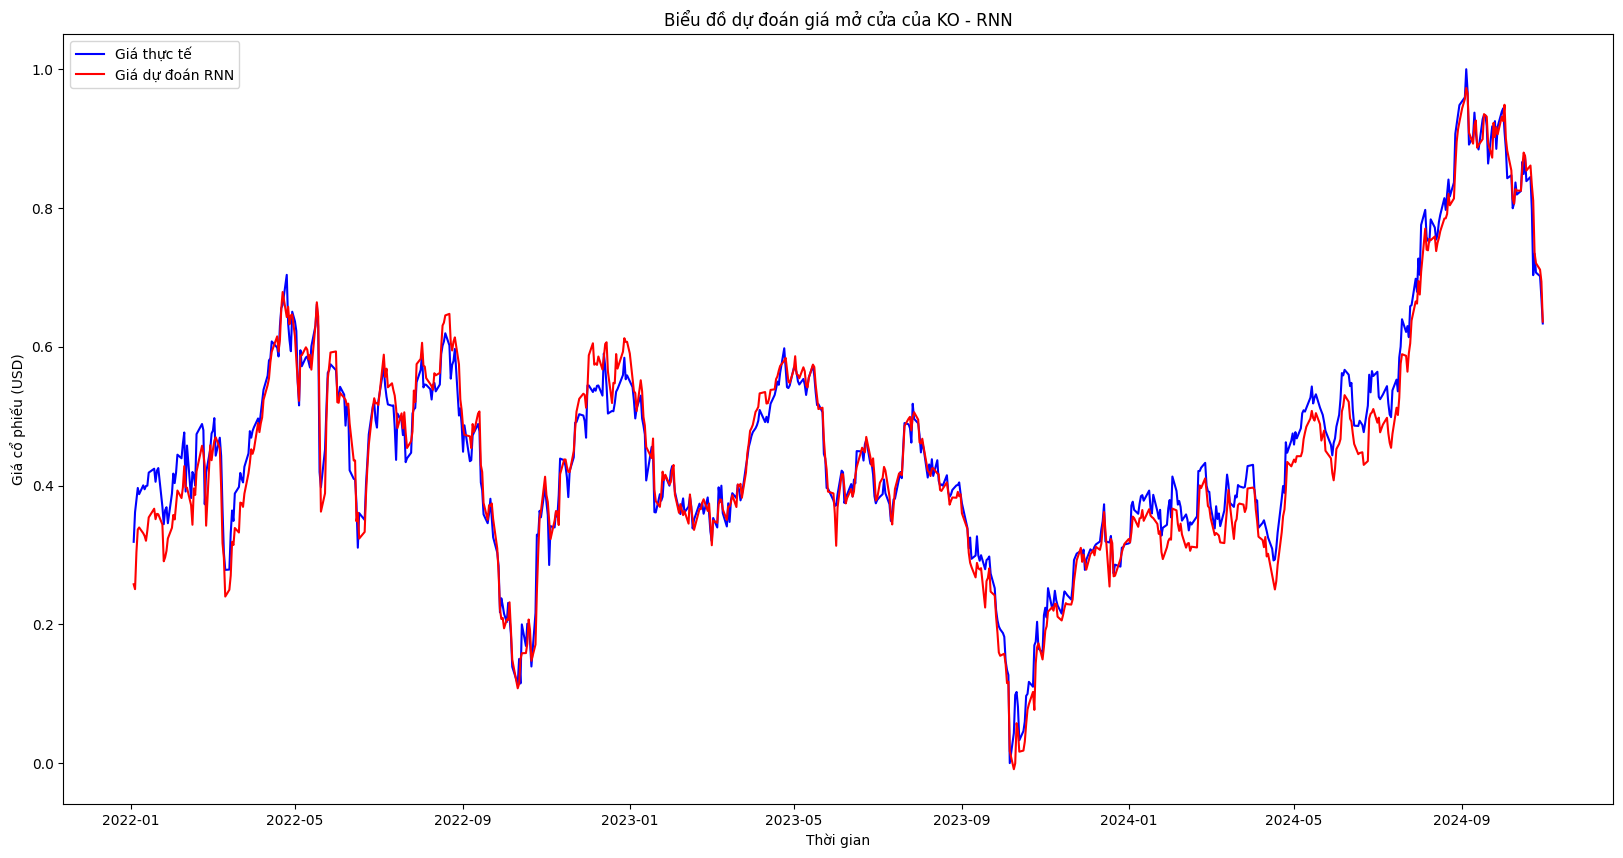

23/23 [==============================] - 0s 1ms/step


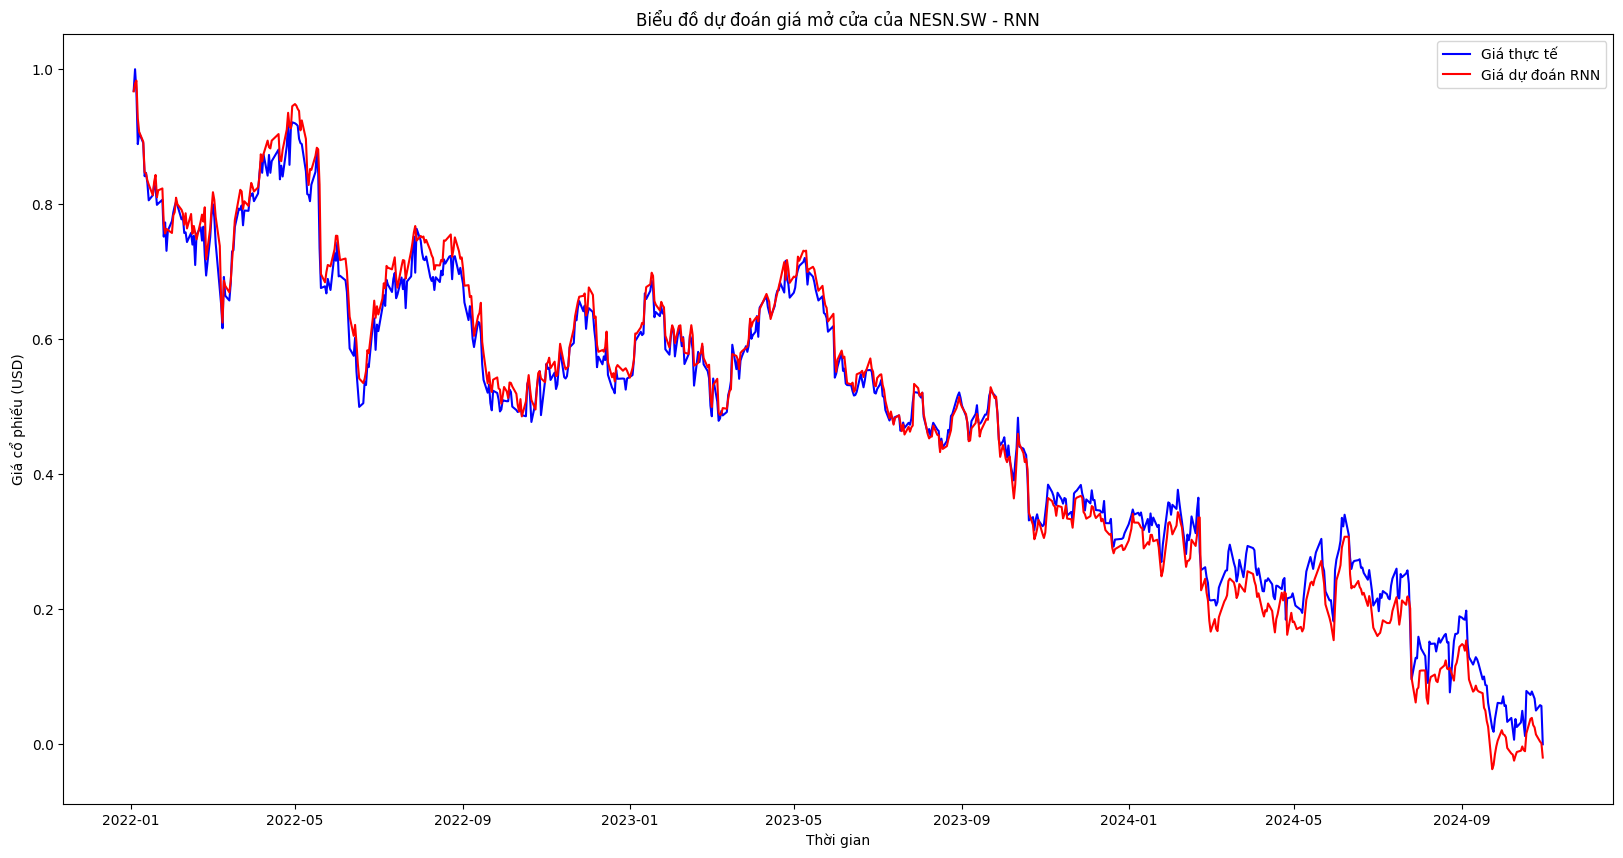

23/23 [==============================] - 0s 1ms/step


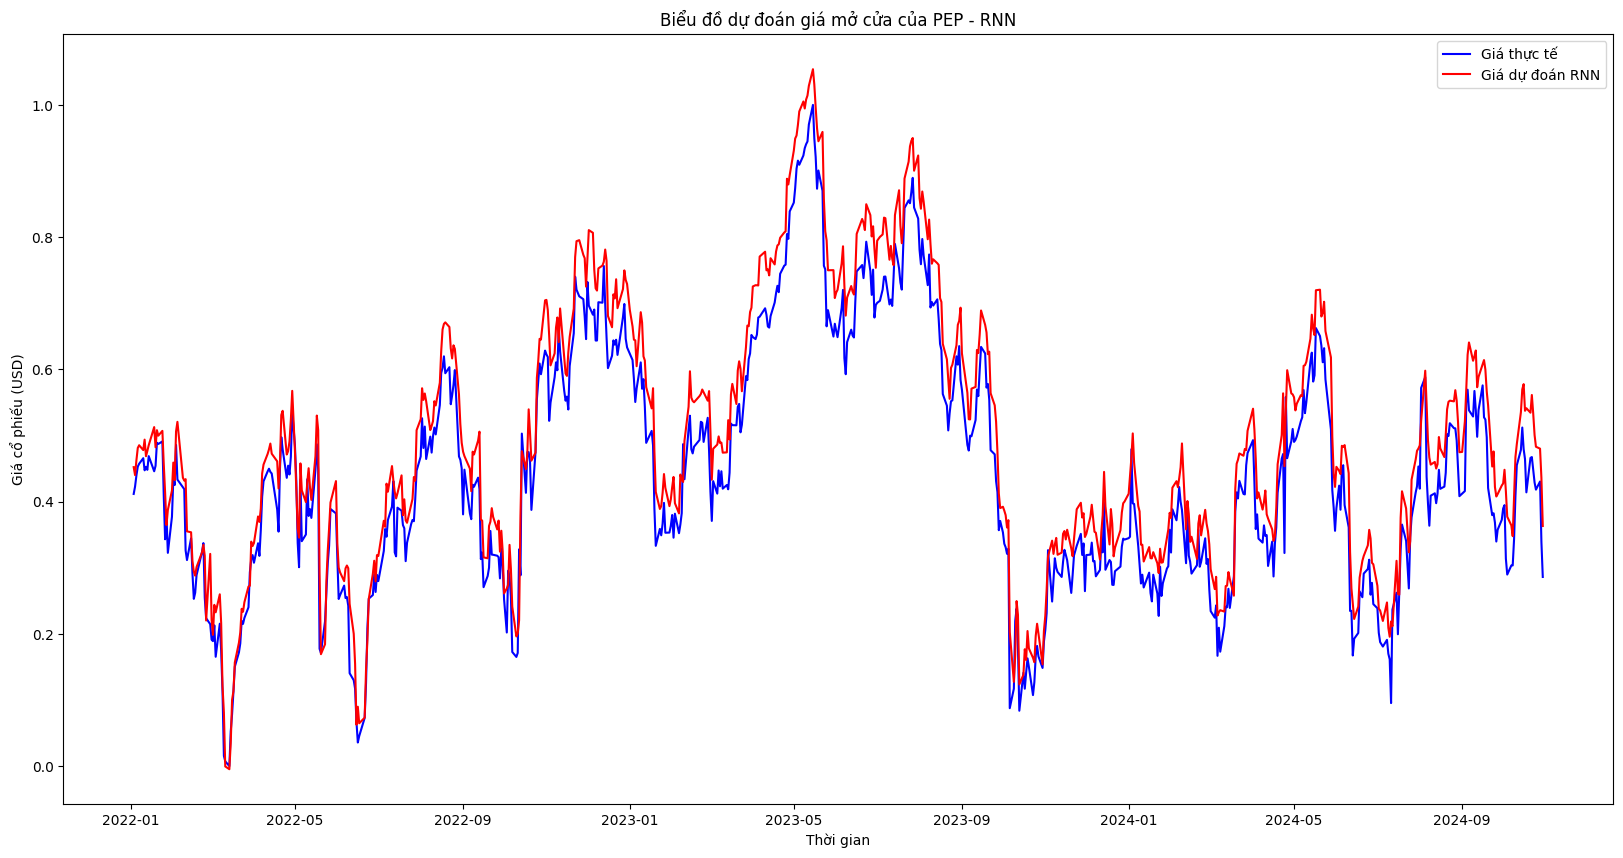

23/23 [==============================] - 0s 1ms/step


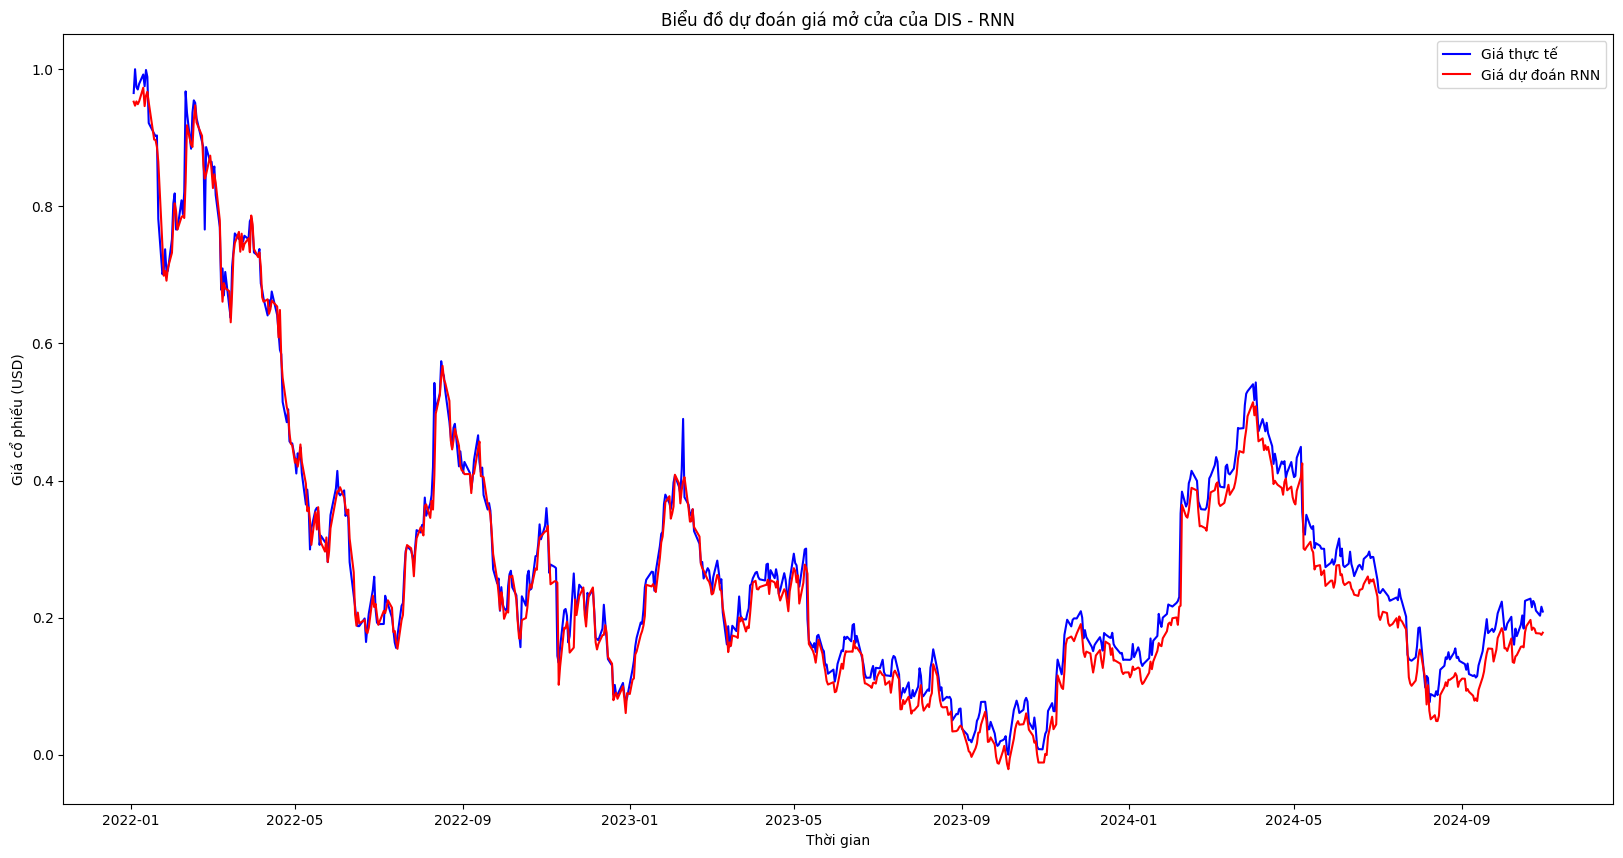

23/23 [==============================] - 0s 2ms/step


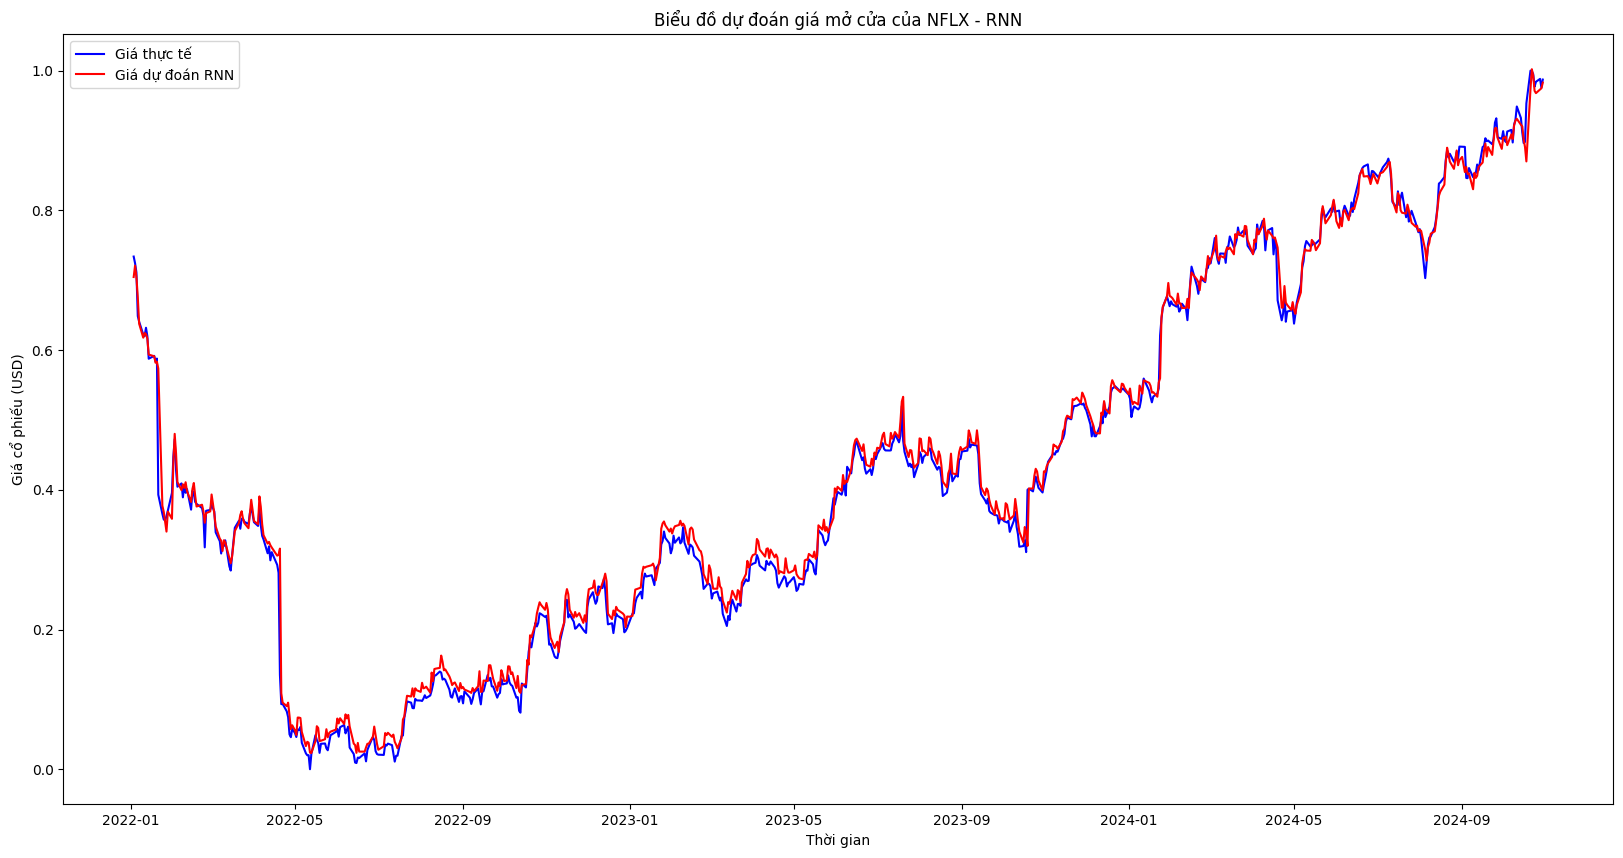

23/23 [==============================] - 0s 2ms/step


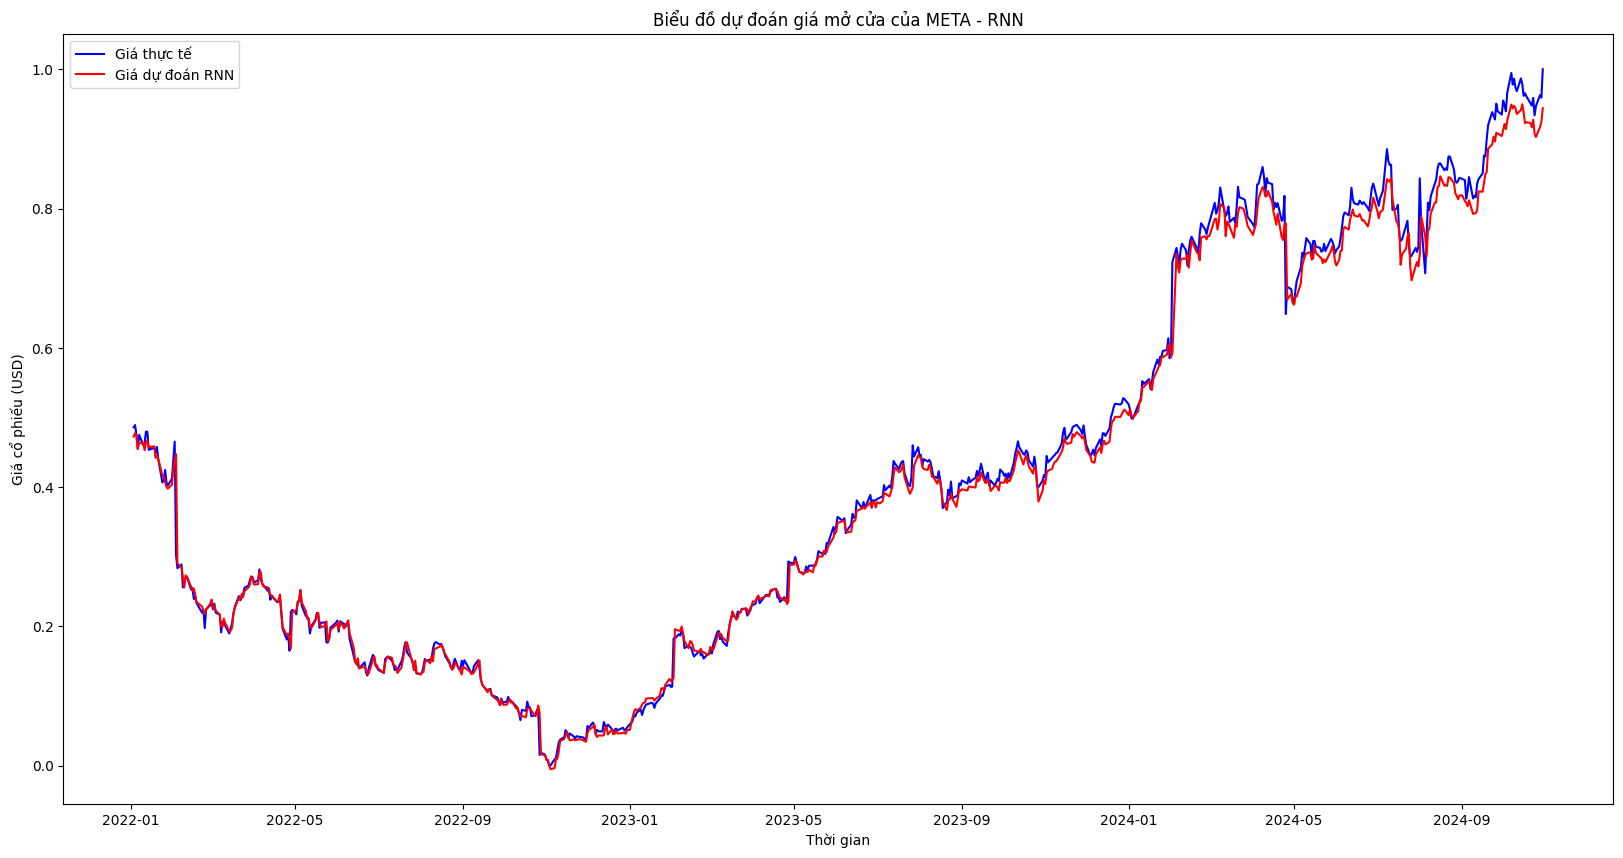

In [ ]:
# Vẽ biểu đồ dự đoán giá mở của cổ phiếu model RNN
for ticker in tickers:
    plot_prediction_rnn(ticker)

In [ ]:
# Hàm vẽ biểu đồ loss (train & validation) qua các epochs
def plot_loss_rnn(ticker):
    plt.figure(figsize=(12, 7))
    plt.plot(history_rnn[ticker].history['loss'], label='Training loss', color='b')
    plt.plot(history_rnn[ticker].history['val_loss'], label='Validation loss', color='r')
    plt.title(f'Biểu đồ loss qua các epochs của {ticker} (RNN)')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

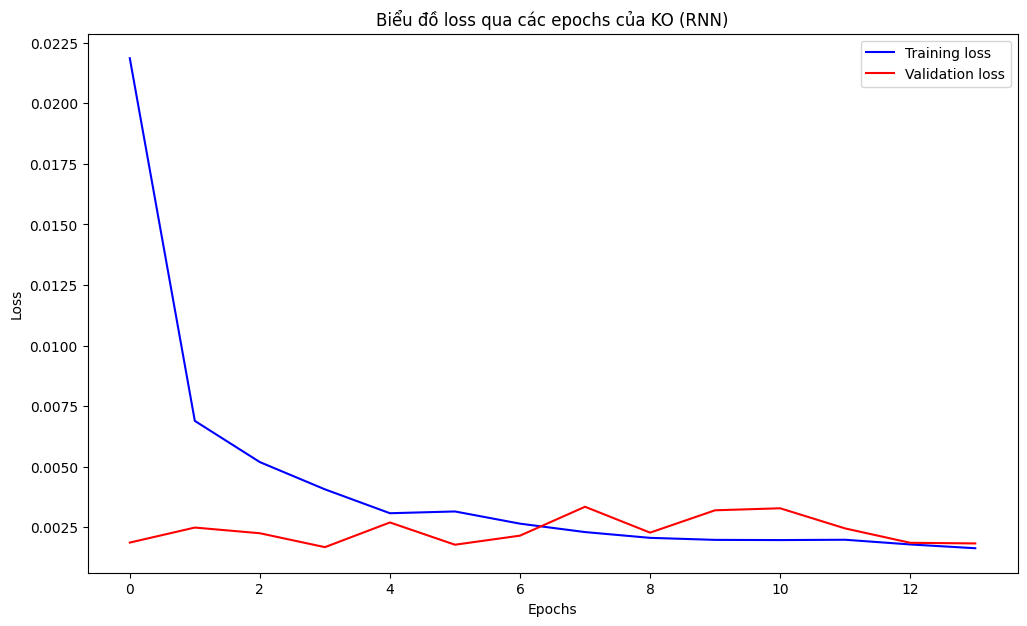

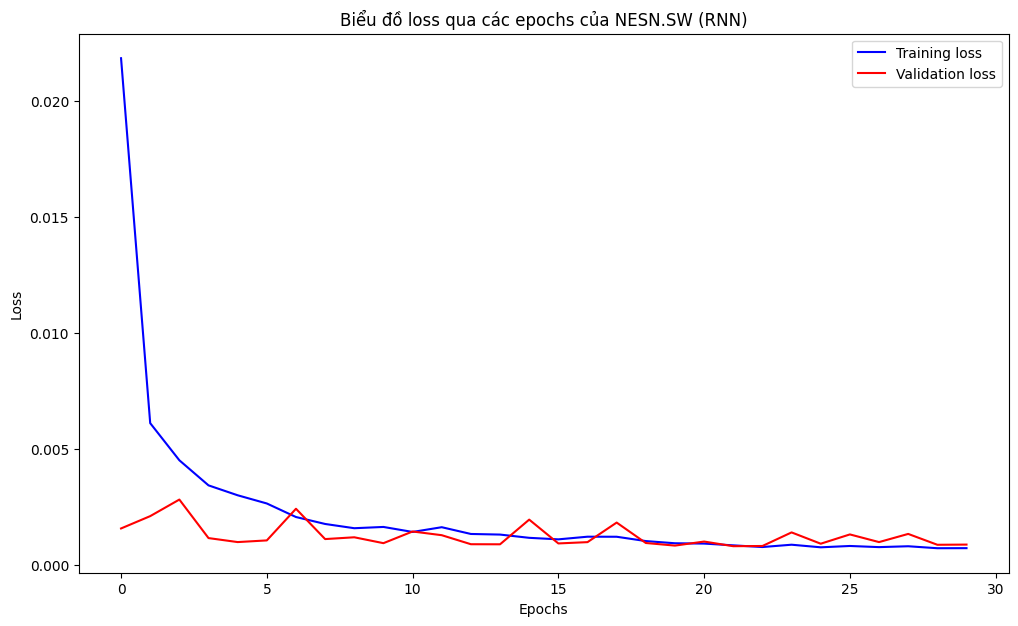

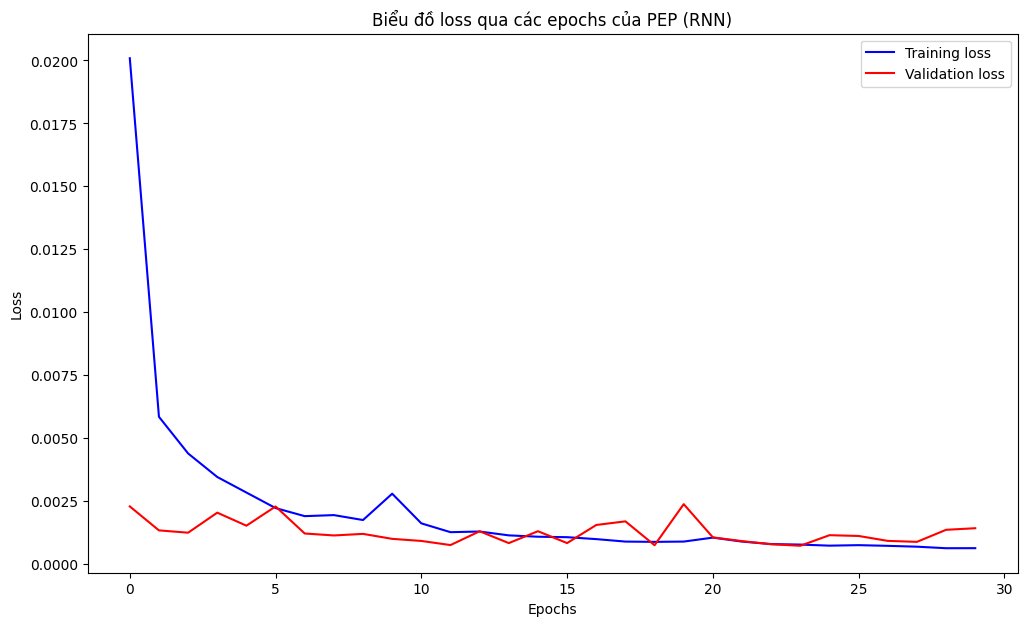

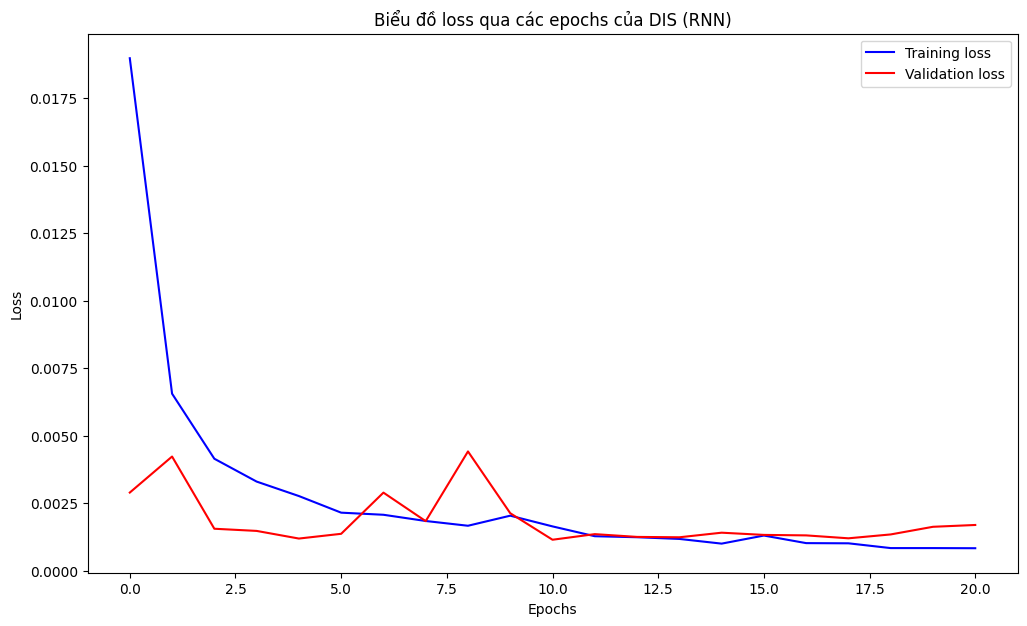

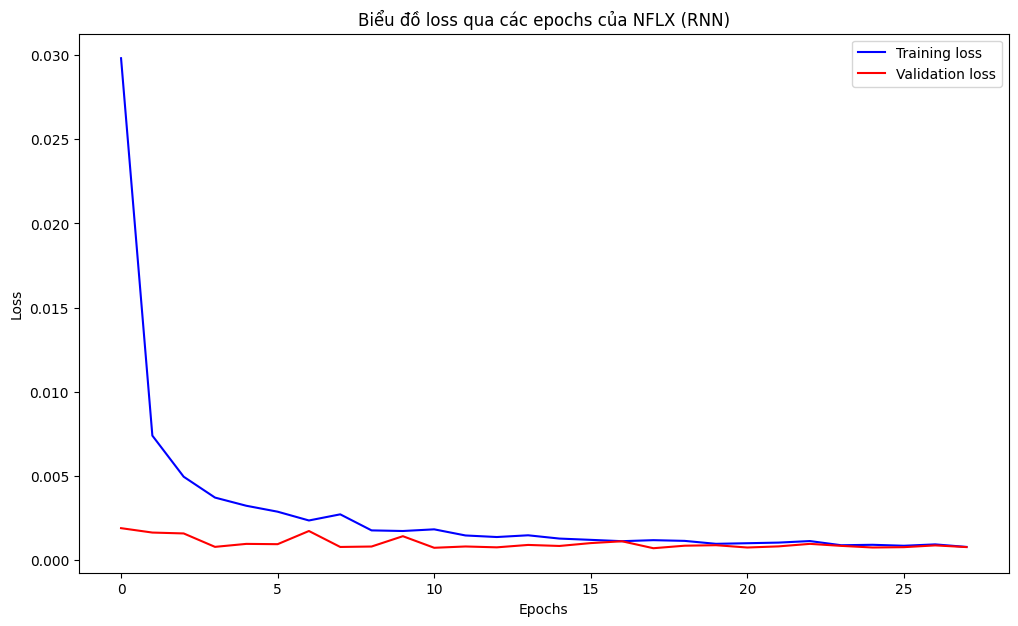

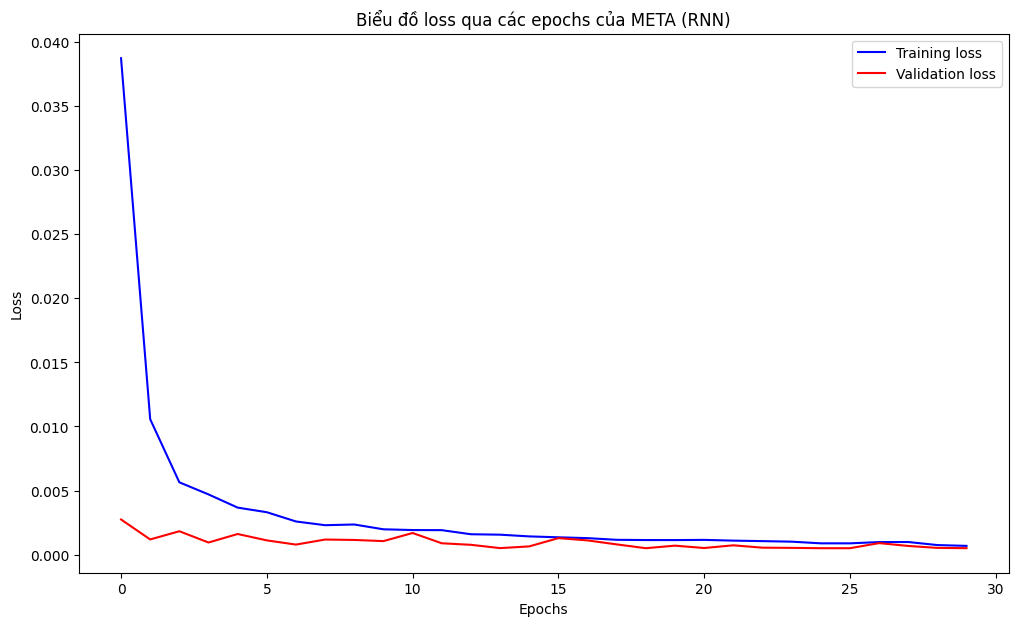

In [ ]:
for ticker in tickers:
    plot_loss_rnn(ticker)

In [ ]:
# Hàm tính các thang đo đánh giá mô hình
def evaluate_model_rnn(ticker):
    y_pred = rnn_model[ticker].predict(x_test_rnn[ticker])
    mae = mean_absolute_error(y_test_rnn[ticker], y_pred)
    mse = mean_squared_error(y_test_rnn[ticker], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[ticker][time_steps:], y_pred)
    print(f'Thông số đánh giá mô hình RNN cho mã cổ phiếu {ticker}:')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R^2: {r2}')
    return mae, mse, rmse, r2

In [ ]:
# Lưu lại các thang đo để đánh giá mô hình
evaluate_rnn = {}
for ticker in tickers:
    evaluate_rnn[ticker] = evaluate_model_rnn(ticker)

23/23 [==============================] - 0s 2ms/step
Thông số đánh giá mô hình RNN cho mã cổ phiếu KO:
MAE: 0.02428190725550561
MSE: 0.0009328999379259662
RMSE: 0.0305434107120663
R^2: 0.9672216176986694
23/23 [==============================] - 0s 1ms/step
Thông số đánh giá mô hình RNN cho mã cổ phiếu NESN.SW:
MAE: 0.022003936180357273
MSE: 0.0007172106435239908
RMSE: 0.02678078870242605
R^2: 0.9850541949272156
23/23 [==============================] - 0s 1ms/step
Thông số đánh giá mô hình RNN cho mã cổ phiếu PEP:
MAE: 0.05280683290647371
MSE: 0.003479147572990345
RMSE: 0.05898429937695577
R^2: 0.897577166557312
23/23 [==============================] - 0s 1ms/step
Thông số đánh giá mô hình RNN cho mã cổ phiếu DIS:
MAE: 0.02269850310420253
MSE: 0.0007589497308739813
RMSE: 0.0275490422859667
R^2: 0.9830862283706665
23/23 [==============================] - 0s 1ms/step
Thông số đánh giá mô hình RNN cho mã cổ phiếu NFLX:
MAE: 0.012961605310923918
MSE: 0.00034089186856263784
RMSE: 0.018463257

## Các mô hình học máy khác

### Support Vector Machine

In [ ]:
# Khởi tạo model
svm_model = {}
for ticker in tickers:
    svm_model[ticker] = SVR(C=1, kernel='linear', gamma=1)

In [ ]:
# Huấn luyện mô hình
for ticker in tickers:
  svm_model[ticker].fit(x_train_scaled[ticker], y_train[ticker].values.ravel())

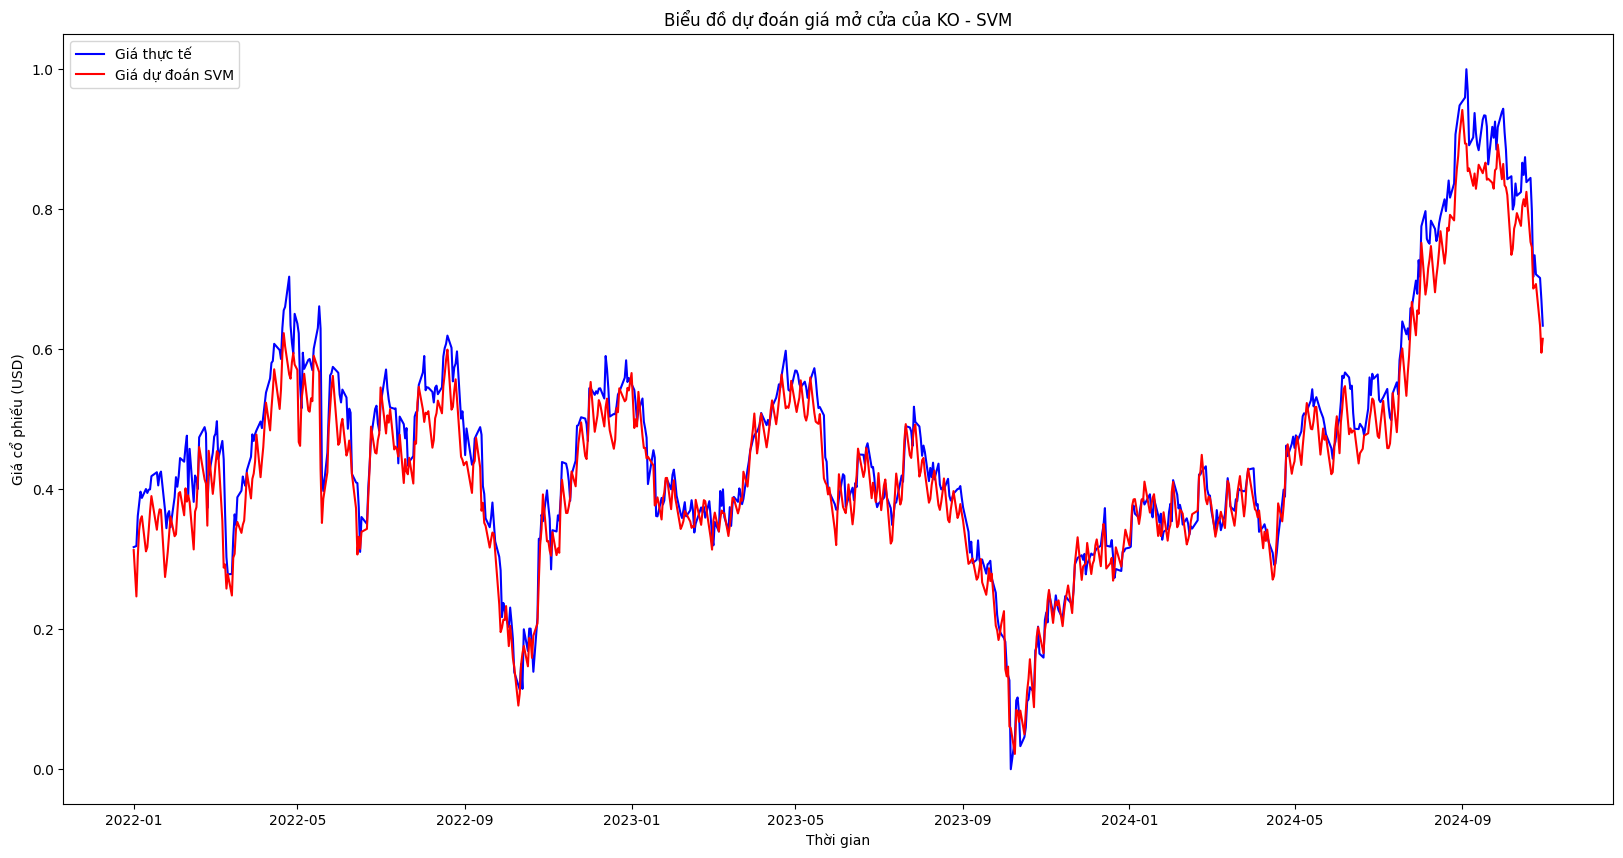

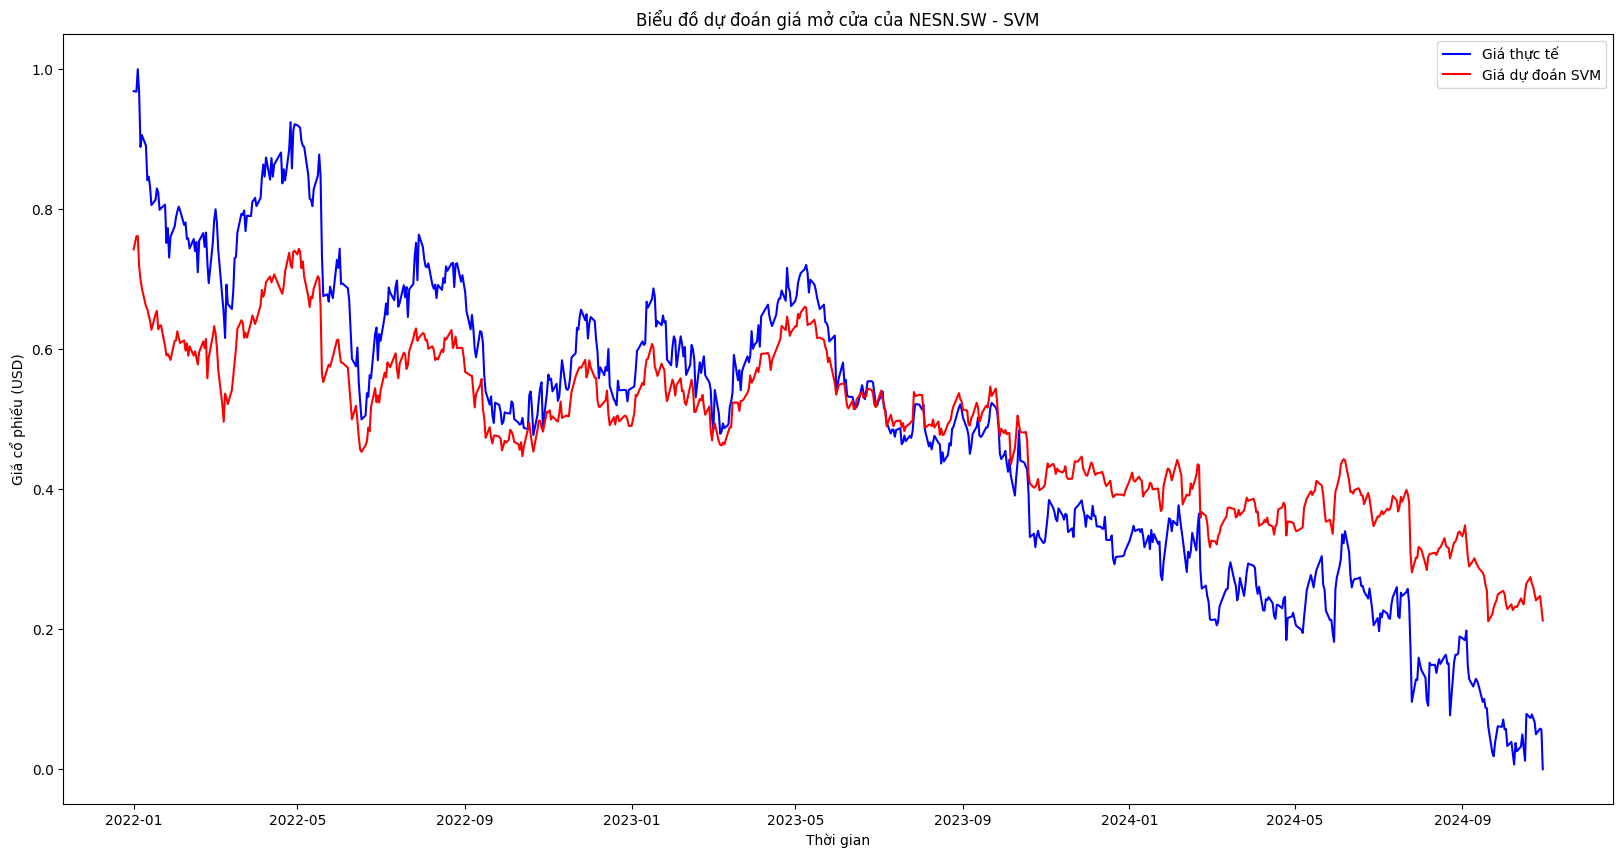

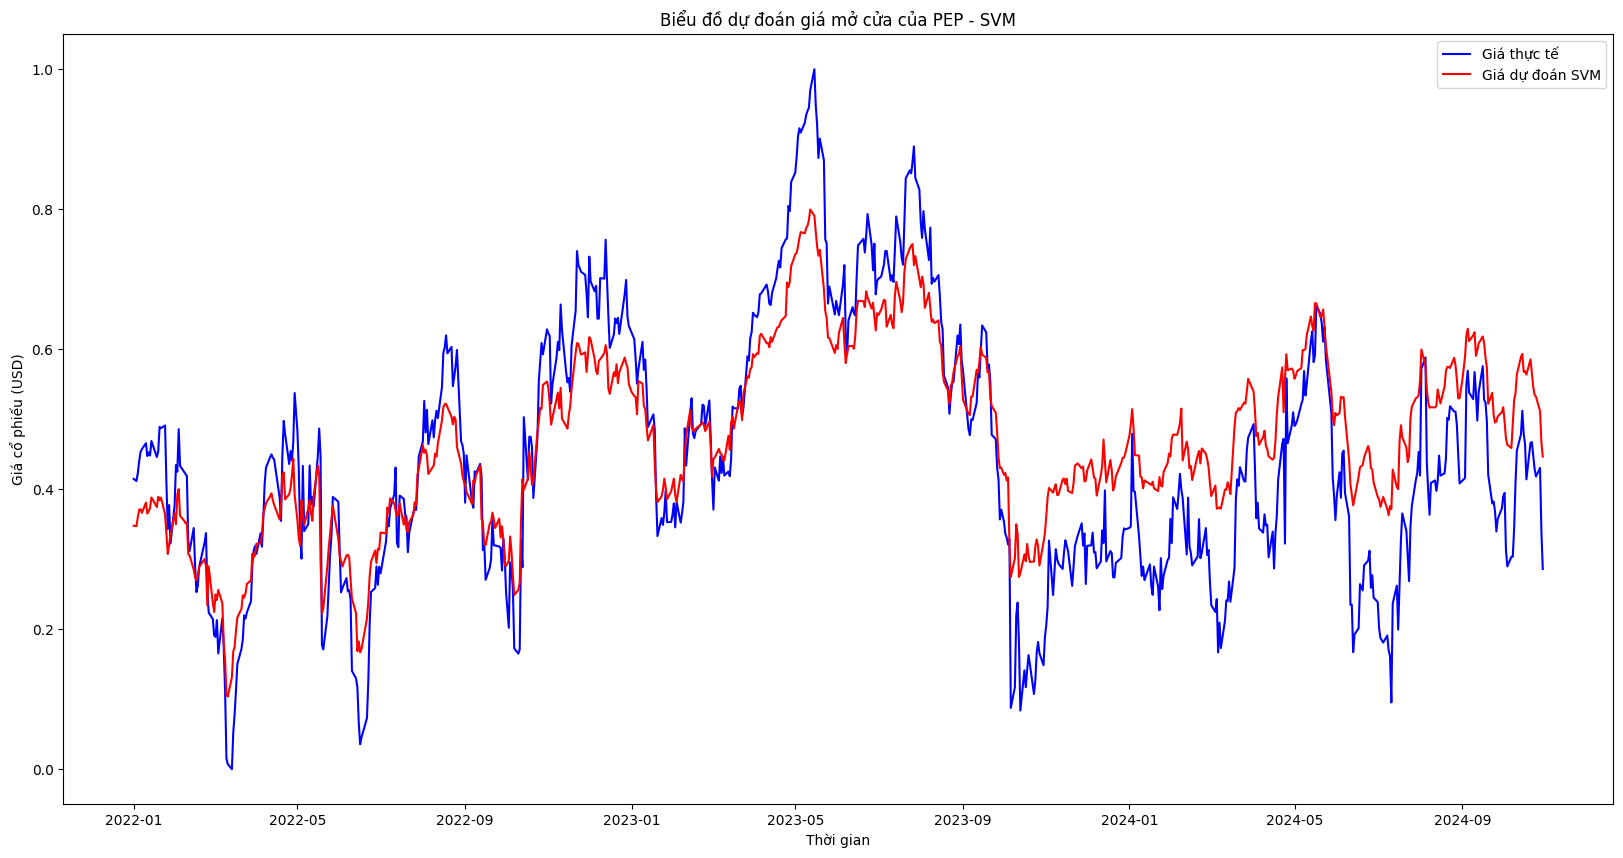

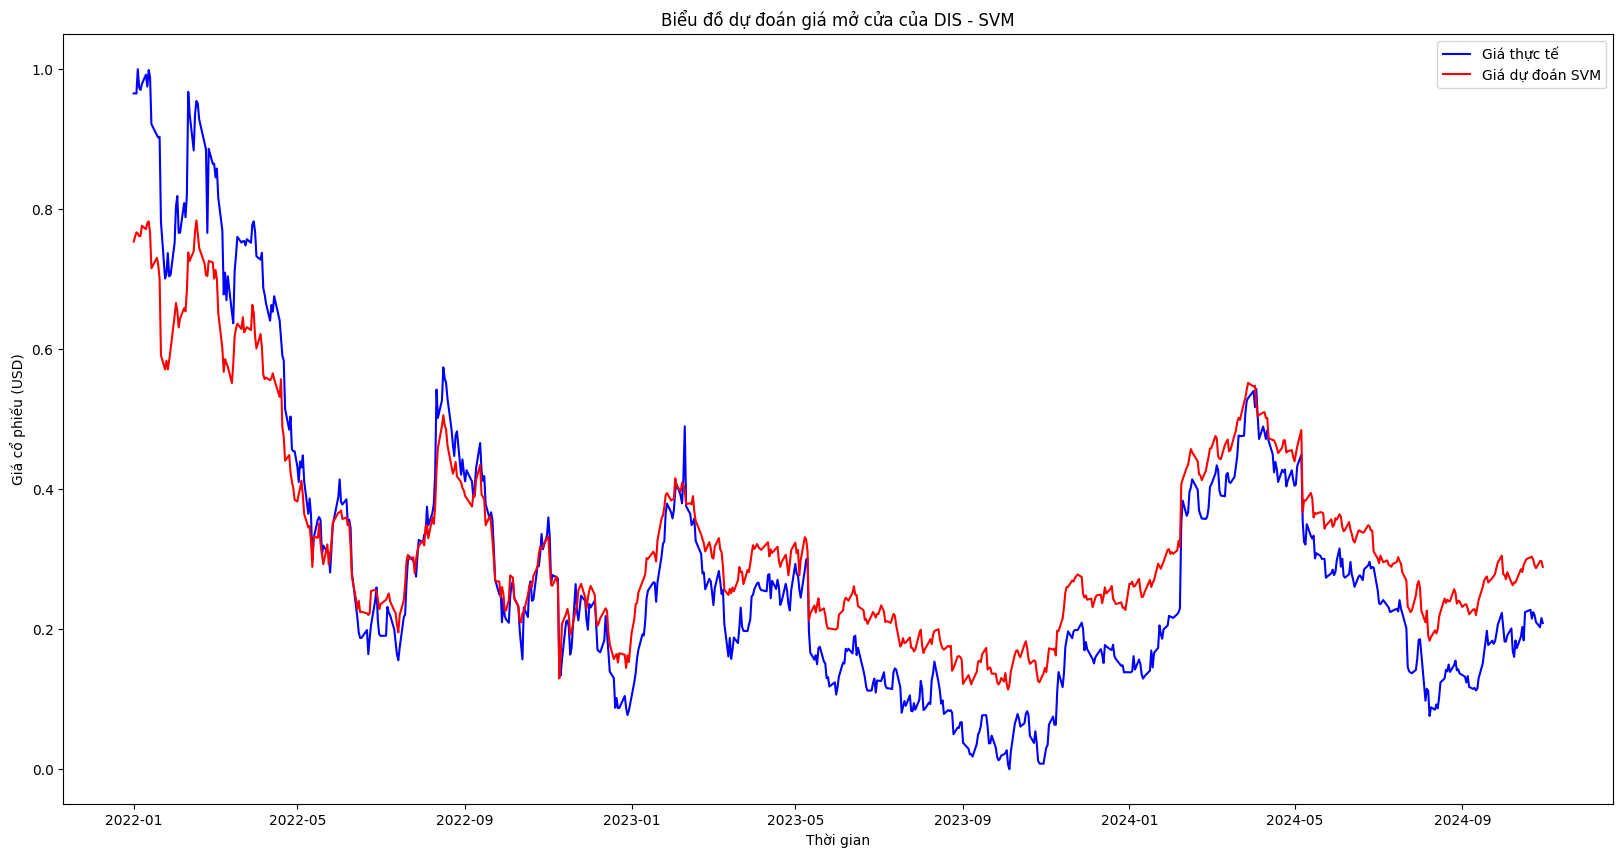

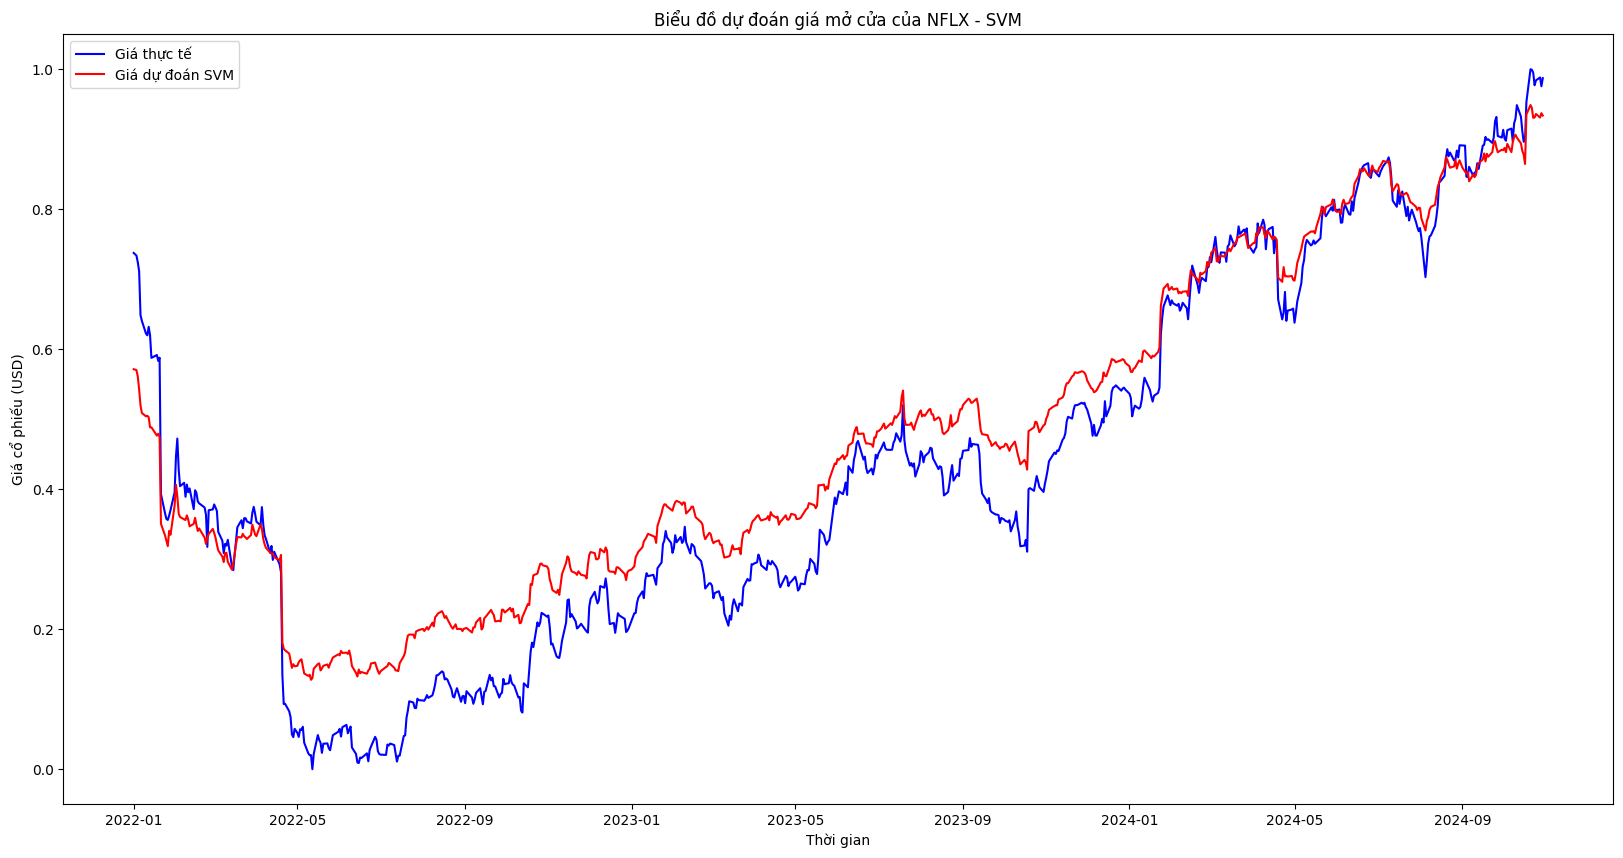

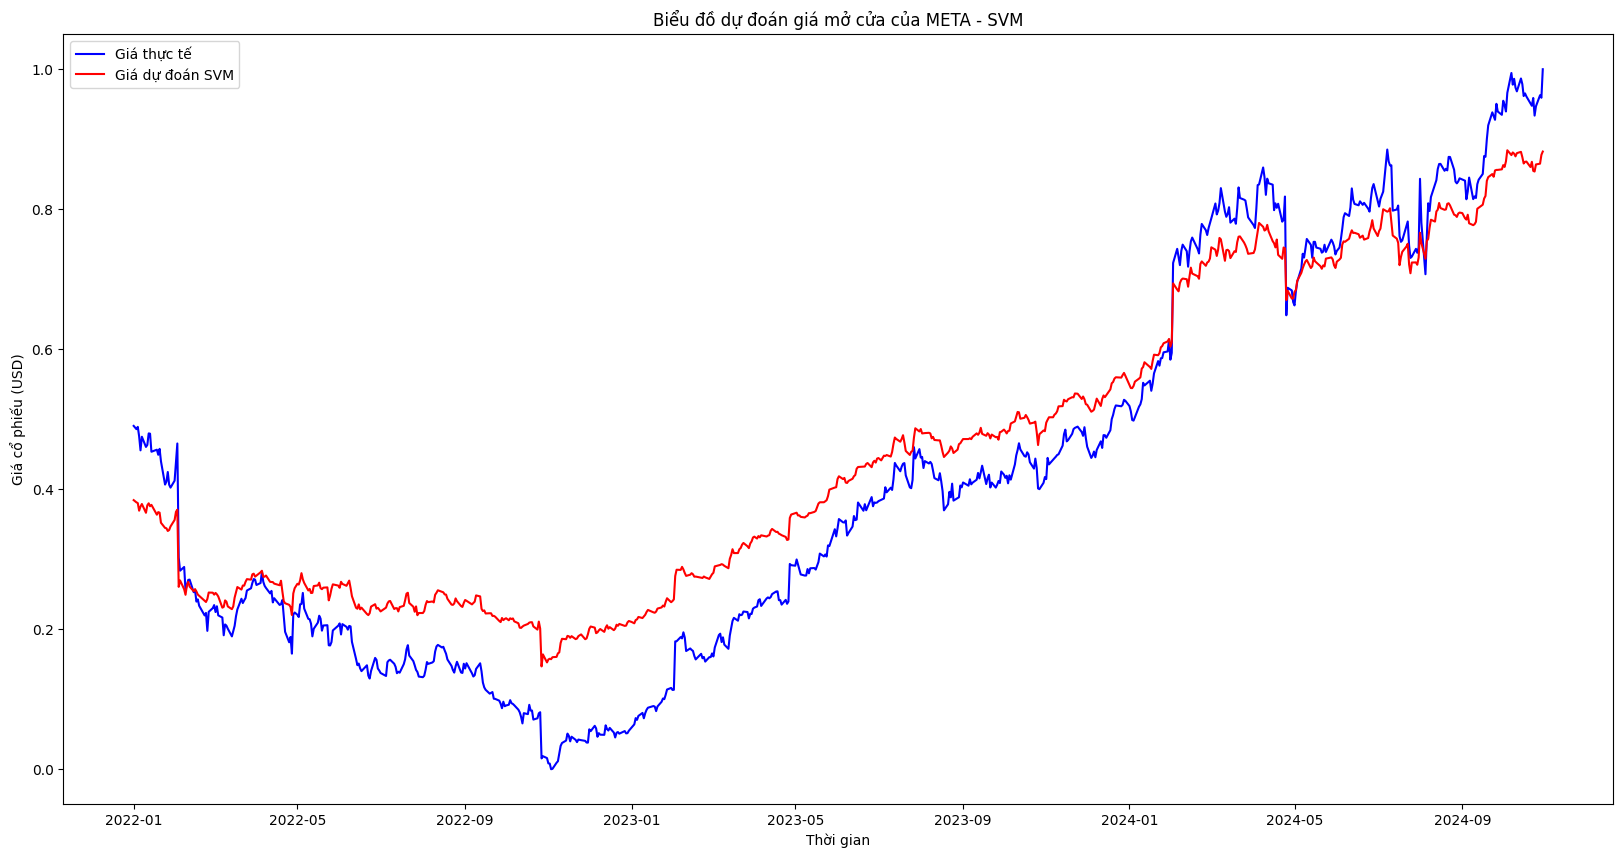

In [ ]:
# Vẽ biểu đồ dự đoán
for ticker in tickers:
  plt.figure(figsize=(20, 10))
  plt.plot(y_date[ticker], y_test[ticker], label='Giá thực tế', color='b')
  plt.plot(y_date[ticker], svm_model[ticker].predict(x_test_scaled[ticker]), label='Giá dự đoán SVM', color='r')
  plt.title(f'Biểu đồ dự đoán giá mở cửa của {ticker} - SVM')
  plt.xlabel('Thời gian')
  plt.ylabel('Giá cổ phiếu (USD)')
  plt.legend()
  plt.show()

In [ ]:
# Đánh giá mô hình
def evaluate_model_svm(ticker):
    y_pred = svm_model[ticker].predict(x_test_scaled[ticker])
    mae = mean_absolute_error(y_test[ticker], y_pred)
    mse = mean_squared_error(y_test[ticker], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[ticker], y_pred)
    print(f'Thông số đánh giá mô hình SVM cho mã cổ phiếu {ticker}:')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R^2: {r2}')
    return mae, mse, rmse, r2

In [ ]:
# Lưu lại các thang đo để đánh giá mô hình
evaluate_svm = {}
for ticker in tickers:
    evaluate_svm[ticker] = evaluate_model_svm(ticker)

Thông số đánh giá mô hình SVM cho mã cổ phiếu KO:
MAE: 0.032613636470096206
MSE: 0.0017507721385797033
RMSE: 0.04184222913014678
R^2: 0.9384584479697813
Thông số đánh giá mô hình SVM cho mã cổ phiếu NESN.SW:
MAE: 0.0925624851509325
MSE: 0.011809017746231653
RMSE: 0.10866930452630887
R^2: 0.755214596458846
Thông số đánh giá mô hình SVM cho mã cổ phiếu PEP:
MAE: 0.08087983249307364
MSE: 0.009186349827051713
RMSE: 0.09584544760734186
R^2: 0.7291962093938715
Thông số đánh giá mô hình SVM cho mã cổ phiếu DIS:
MAE: 0.06978110646488989
MSE: 0.0067063582124158375
RMSE: 0.08189235747257394
R^2: 0.8523918029615505
Thông số đánh giá mô hình SVM cho mã cổ phiếu NFLX:
MAE: 0.058648886226378406
MSE: 0.0047785861512365775
RMSE: 0.06912731841491161
R^2: 0.932207582161984
Thông số đánh giá mô hình SVM cho mã cổ phiếu META:
MAE: 0.06971582910539942
MSE: 0.006264202390520276
RMSE: 0.07914671433812193
R^2: 0.9181963492904034


### Random Forest Regressor

In [ ]:
# Khởi tạo mô hình
rf_model = {}
for ticker in tickers:
    rf_model[ticker] = RandomForestRegressor(n_estimators=10, random_state=42)

In [ ]:
# Huấn luyện mô hình
for ticker in tickers:
    rf_model[ticker].fit(x_train_scaled[ticker], y_train[ticker].values.ravel())

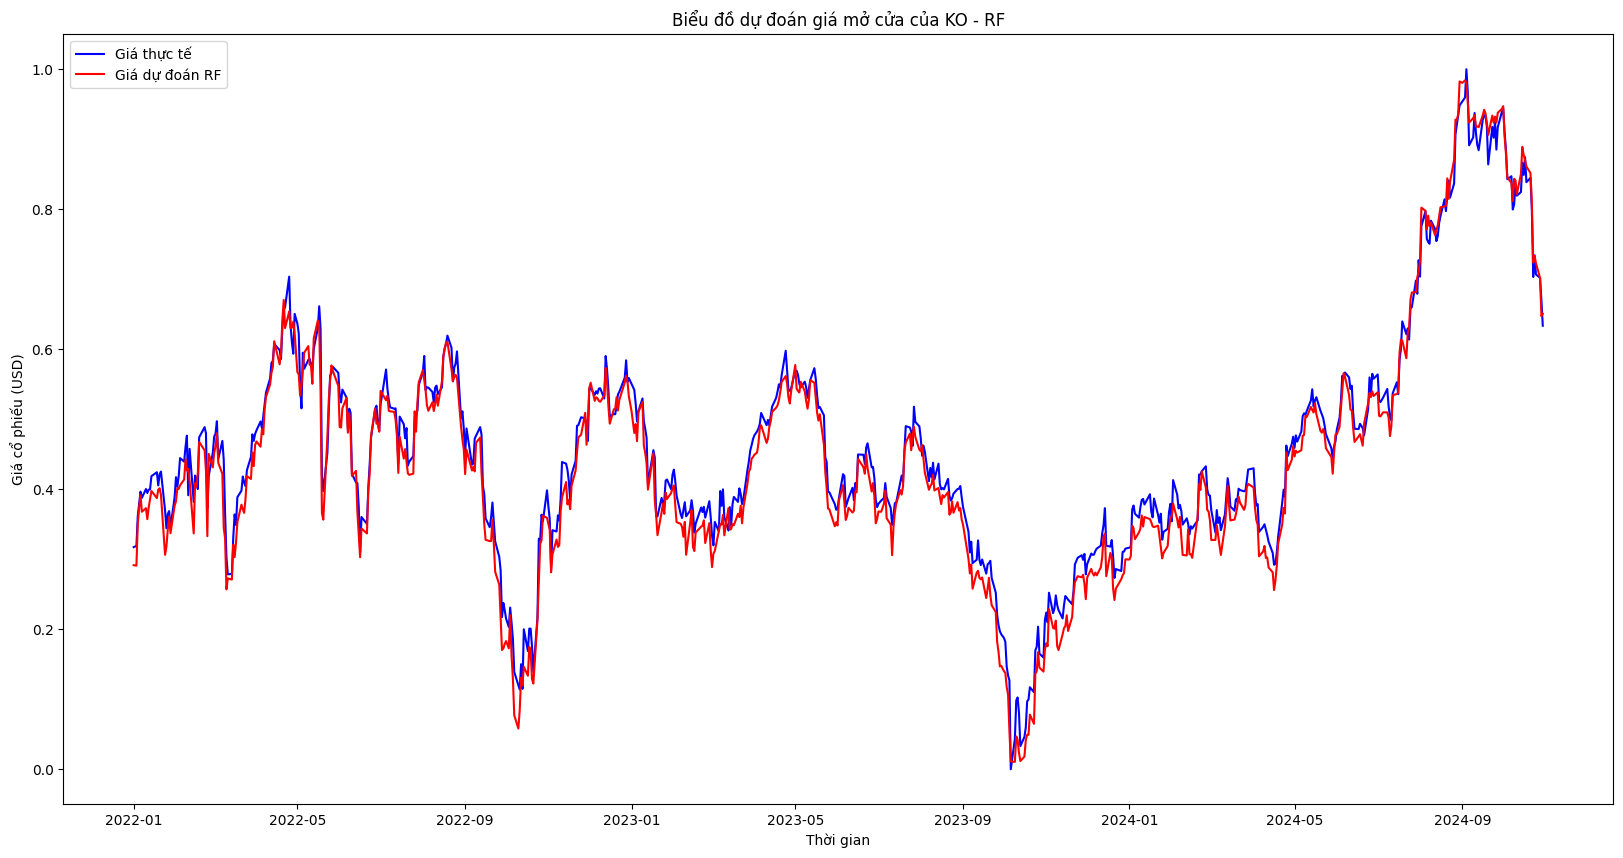

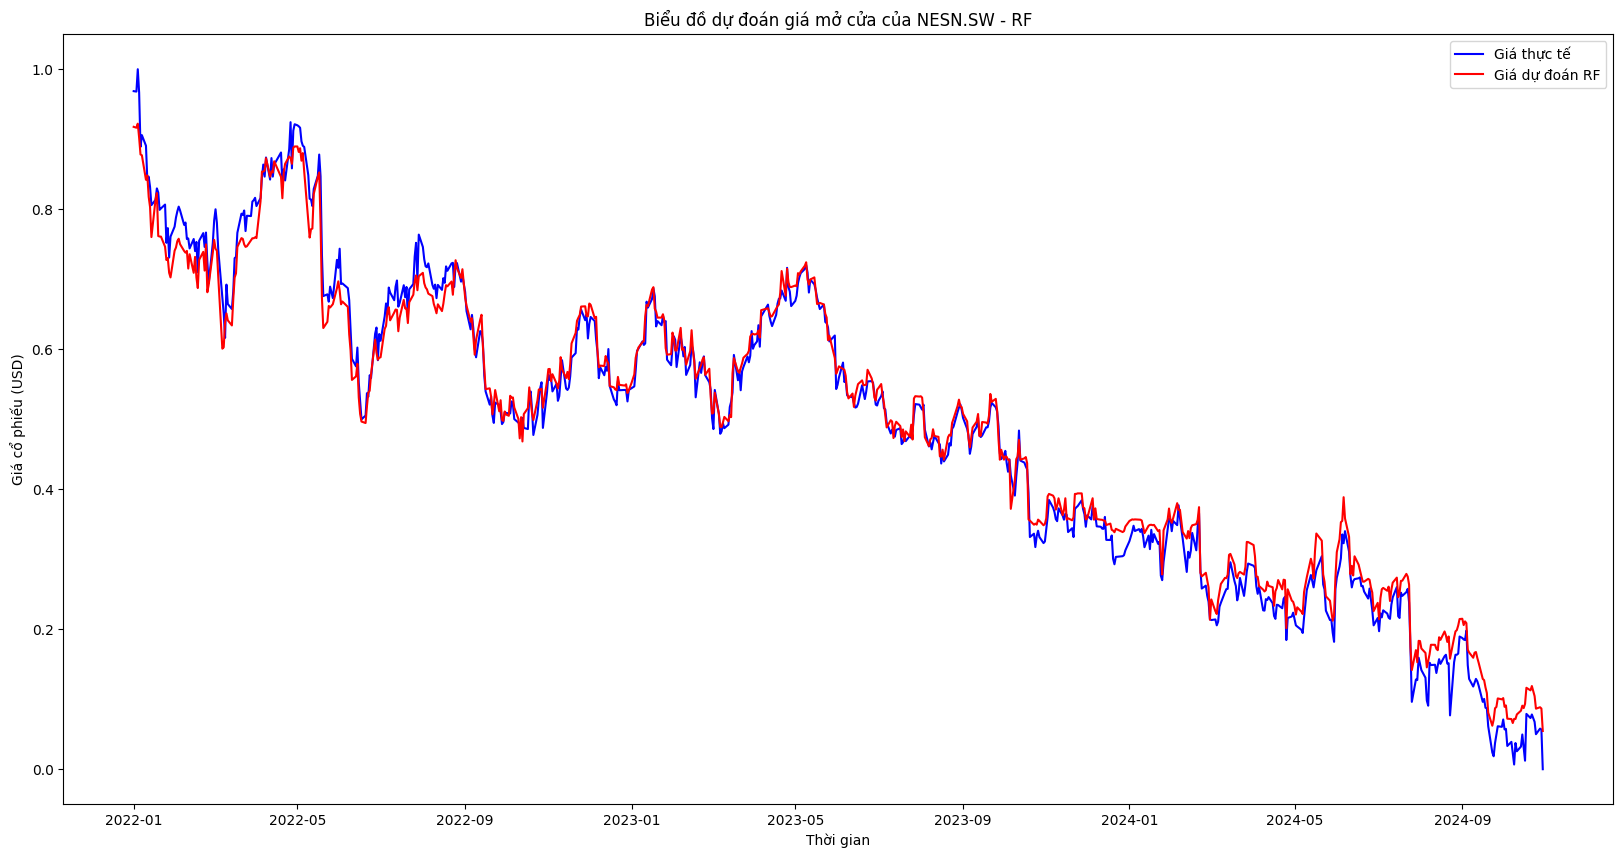

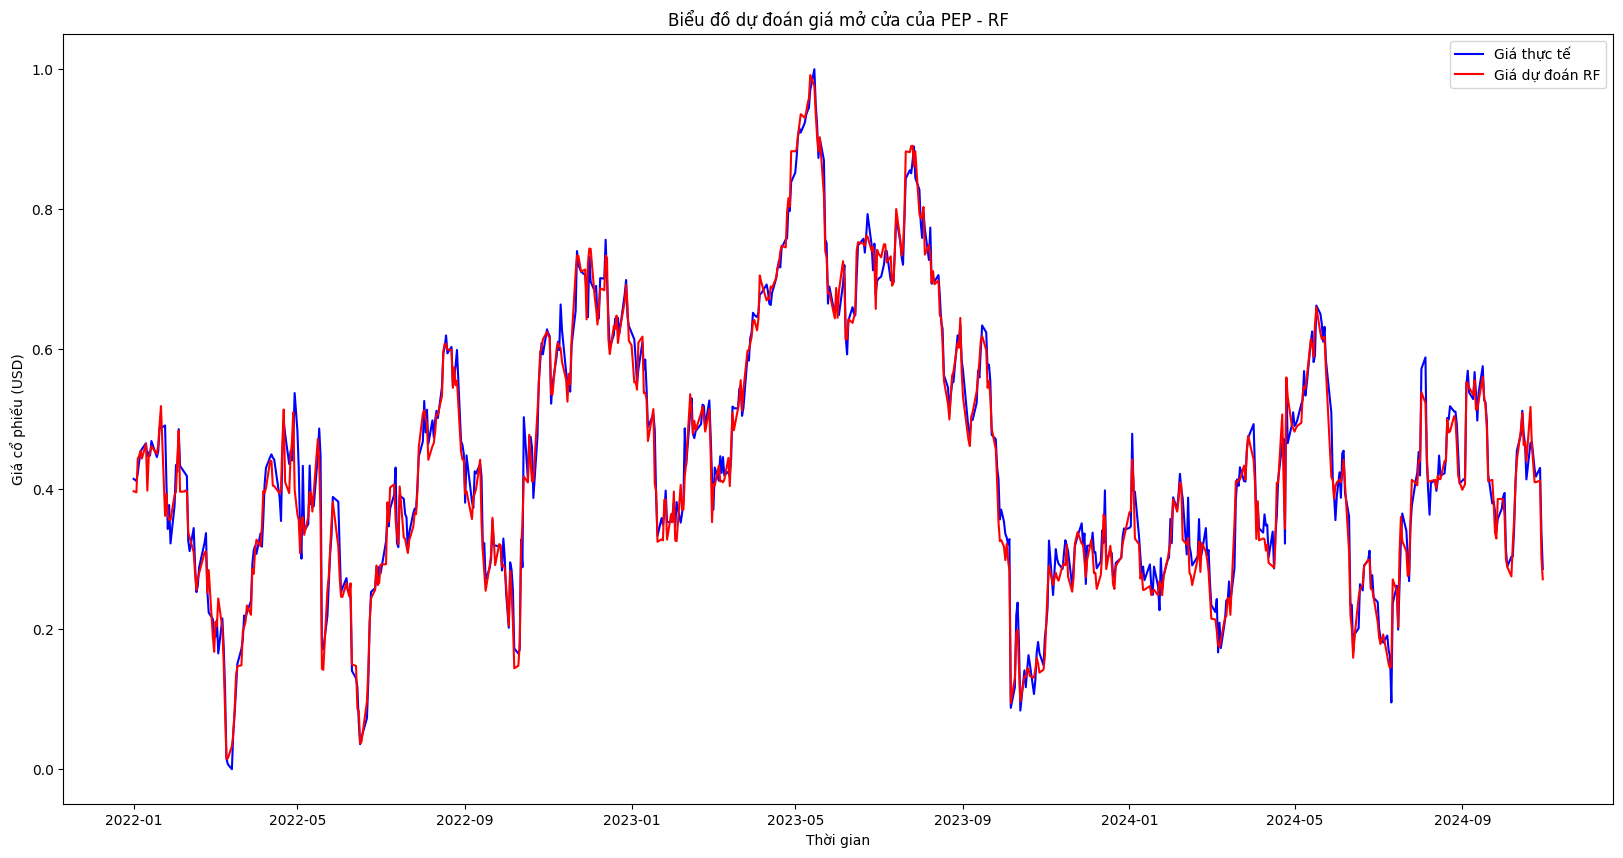

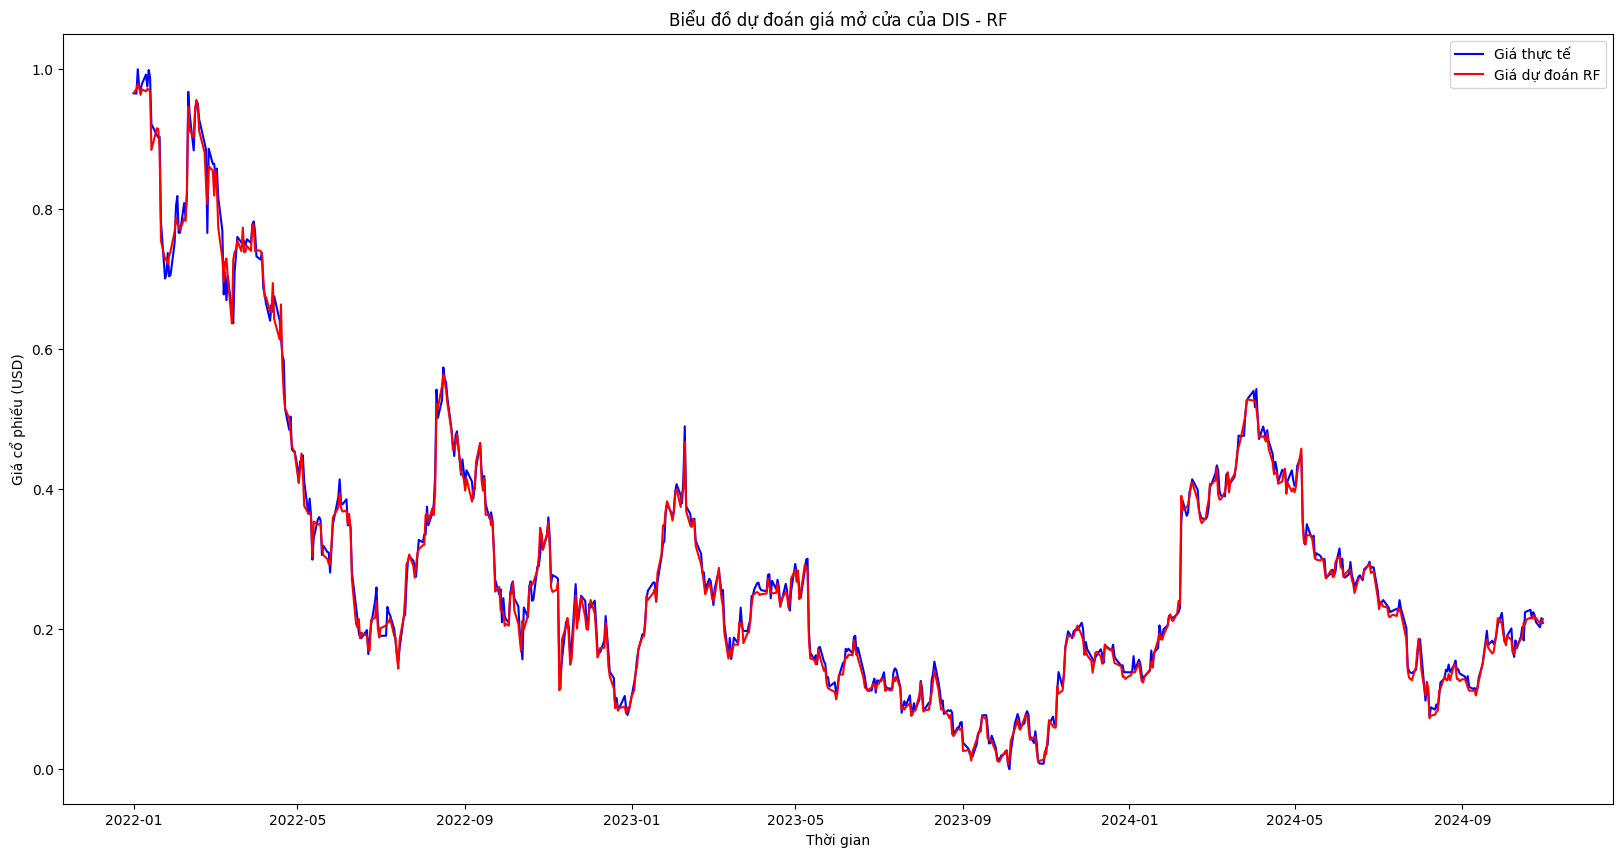

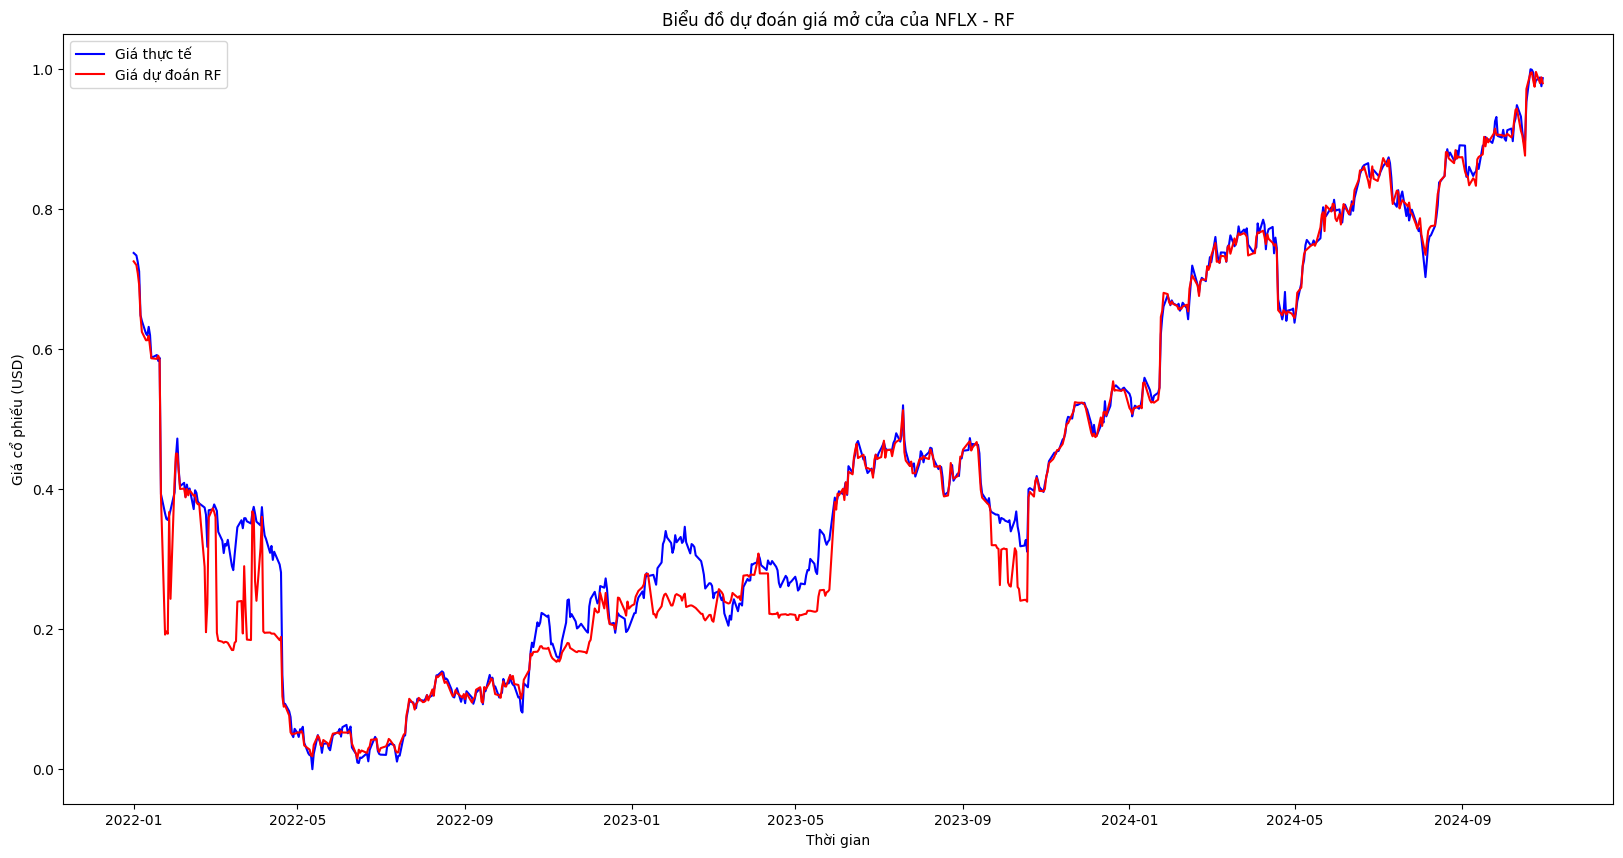

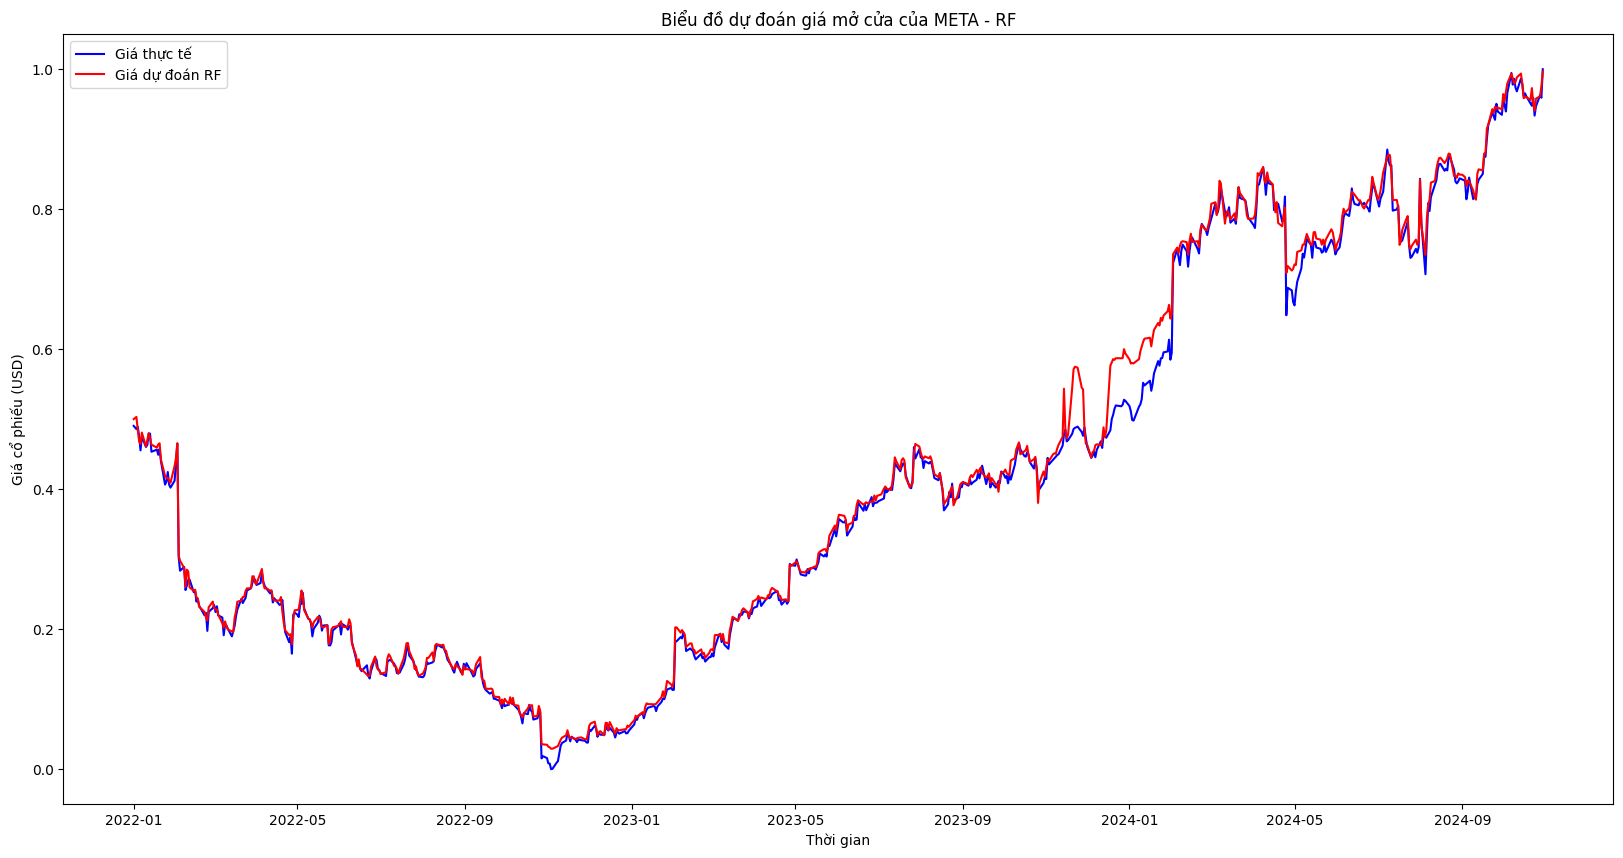

In [ ]:
# Vẽ biểu đồ dự đoán giá mở cổ phiếu
for ticker in tickers:
    plt.figure(figsize=(20, 10))
    plt.plot(y_date[ticker], y_test[ticker], label='Giá thực tế', color='b')
    plt.plot(y_date[ticker], rf_model[ticker].predict(x_test_scaled[ticker]), label='Giá dự đoán RF', color='r')
    plt.title(f'Biểu đồ dự đoán giá mở cửa của {ticker} - RF')
    plt.xlabel('Thời gian')
    plt.ylabel('Giá cổ phiếu (USD)')
    plt.legend()
    plt.show()


In [ ]:
# Đánh giá mô hình
def evaluate_model_rf(ticker):
    y_pred = rf_model[ticker].predict(x_test_scaled[ticker])
    mae = mean_absolute_error(y_test[ticker], y_pred)
    mse = mean_squared_error(y_test[ticker], y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test[ticker], y_pred)
    print(f'Thông số đánh giá mô hình RF cho mã cổ phiếu {ticker}:')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'R^2: {r2}')
    return mae, mse, rmse, r2

In [ ]:
evaluate_rf = {}
for ticker in tickers:
    evaluate_rf[ticker] = evaluate_model_rf(ticker)


Thông số đánh giá mô hình RF cho mã cổ phiếu KO:
MAE: 0.023096010595988124
MSE: 0.0007428894969399757
RMSE: 0.027255999283460067
R^2: 0.9738866231526146
Thông số đánh giá mô hình RF cho mã cổ phiếu NESN.SW:
MAE: 0.020649446647145728
MSE: 0.000645306857799095
RMSE: 0.025402890737061697
R^2: 0.9866236377157929
Thông số đánh giá mô hình RF cho mã cổ phiếu PEP:
MAE: 0.01994101230222908
MSE: 0.0007029319273792747
RMSE: 0.02651286343229027
R^2: 0.9792783168444312
Thông số đánh giá mô hình RF cho mã cổ phiếu DIS:
MAE: 0.010047005064322266
MSE: 0.00018369934362519297
RMSE: 0.013553573094398133
R^2: 0.9959567431308007
Thông số đánh giá mô hình RF cho mã cổ phiếu NFLX:
MAE: 0.021920890226280097
MSE: 0.0015582092641872362
RMSE: 0.039474159448774034
R^2: 0.9778941364299746
Thông số đánh giá mô hình RF cho mã cổ phiếu META:
MAE: 0.010851274778372772
MSE: 0.00035522007038261733
RMSE: 0.018847282838186978
R^2: 0.9953612133275591


## So sánh các model

In [ ]:
# Evaluation metrics cho META
print("Các thang đo đối với META")
print("----------------------------------------")

# FNN
print("FNN:")
mae_fnn, mse_fnn, rmse_fnn, r2_fnn = evaluate_fnn["META"]
print(f"  MAE: {mae_fnn:.4f}")
print(f"  MSE: {mse_fnn:.4f}")
print(f"  RMSE: {rmse_fnn:.4f}")
print(f"  R2: {r2_fnn:.4f}")

# RNN
print("----------------------------------------")
print("RNN:")
mae_rnn, mse_rnn, rmse_rnn, r2_rnn = evaluate_rnn["META"]
print(f"  MAE: {mae_rnn:.4f}")
print(f"  MSE: {mse_rnn:.4f}")
print(f"  RMSE: {rmse_rnn:.4f}")
print(f"  R2: {r2_rnn:.4f}")

# SVM
print("----------------------------------------")
print("SVM:")
mae_svm, mse_svm, rmse_svm, r2_svm = evaluate_svm["META"]
print(f"  MAE: {mae_svm:.4f}")
print(f"  MSE: {mse_svm:.4f}")
print(f"  RMSE: {rmse_svm:.4f}")
print(f"  R2: {r2_svm:.4f}")

# RF
print("----------------------------------------")
print("RF:")
mae_rf, mse_rf, rmse_rf, r2_rf = evaluate_rf["META"]
print(f"  MAE: {mae_rf:.4f}")
print(f"  MSE: {mse_rf:.4f}")
print(f"  RMSE: {rmse_rf:.4f}")
print(f"  R2: {r2_rf:.4f}")
print("----------------------------------------")

Các thang đo đối với META
----------------------------------------
FNN:
  MAE: 0.0100
  MSE: 0.0002
  RMSE: 0.0124
  R2: 0.9980
----------------------------------------
RNN:
  MAE: 0.0117
  MSE: 0.0003
  RMSE: 0.0182
  R2: 0.9957
----------------------------------------
SVM:
  MAE: 0.0697
  MSE: 0.0063
  RMSE: 0.0791
  R2: 0.9182
----------------------------------------
RF:
  MAE: 0.0109
  MSE: 0.0004
  RMSE: 0.0188
  R2: 0.9954
----------------------------------------


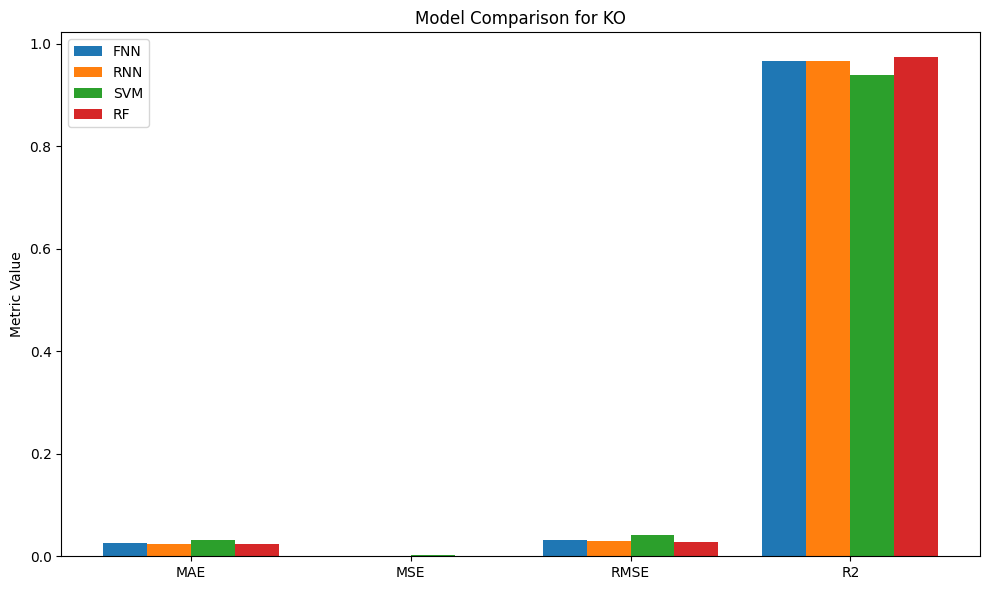

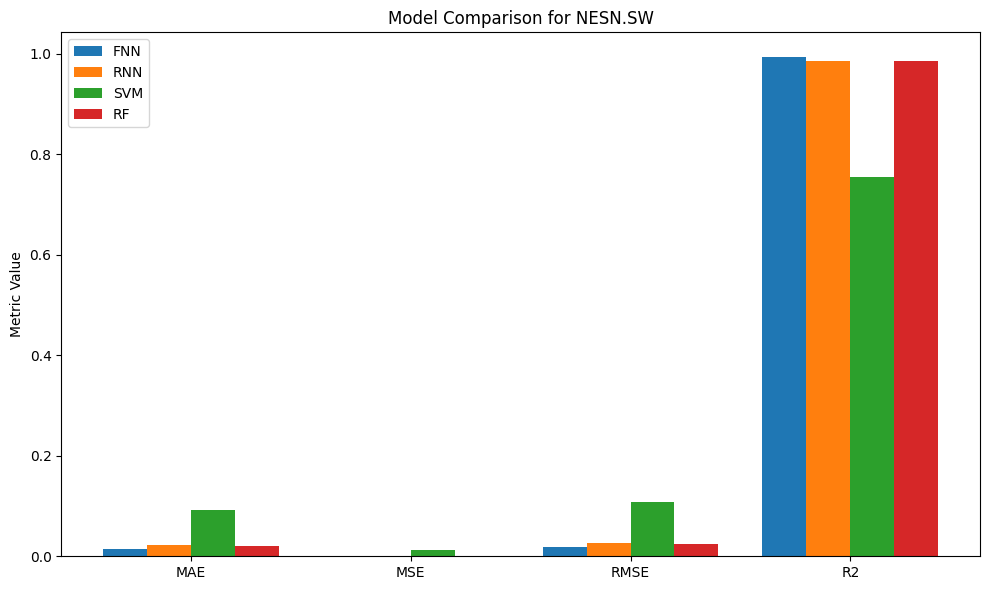

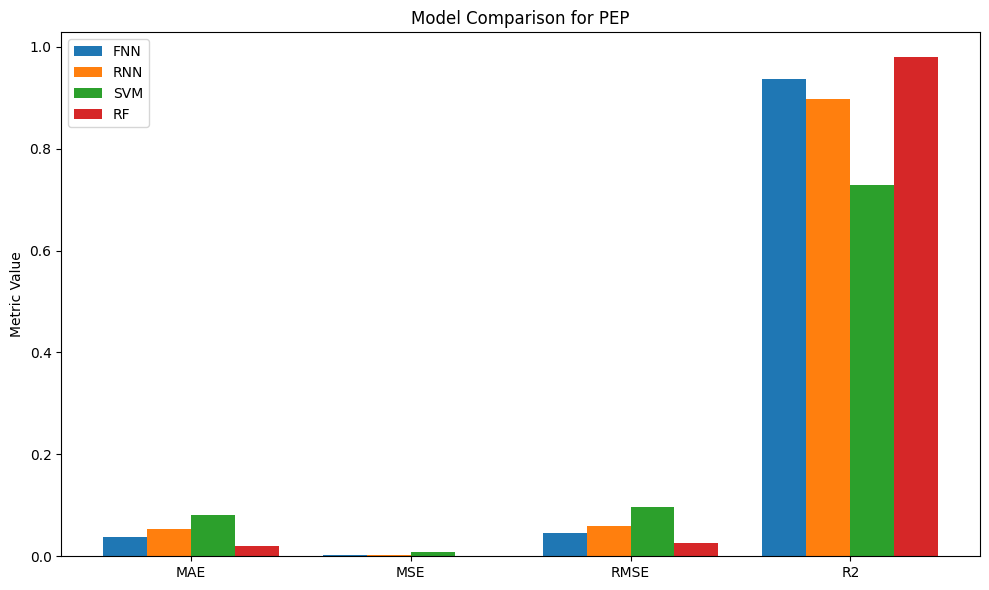

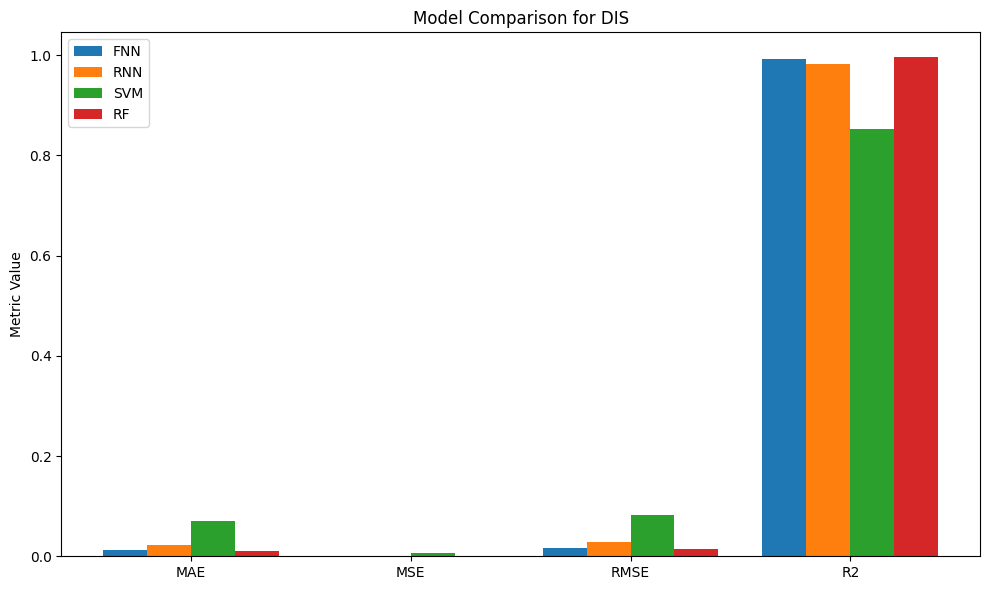

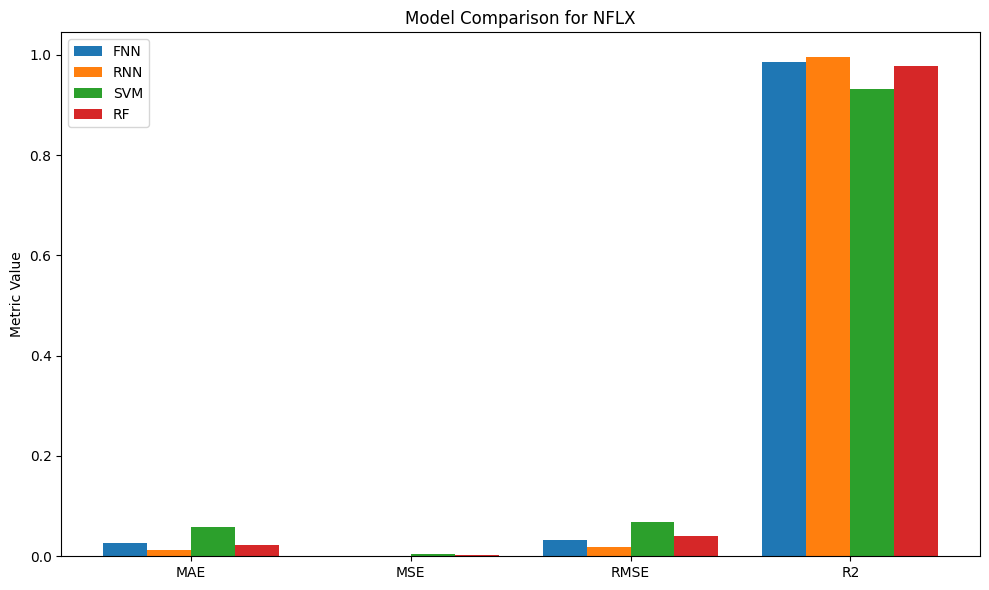

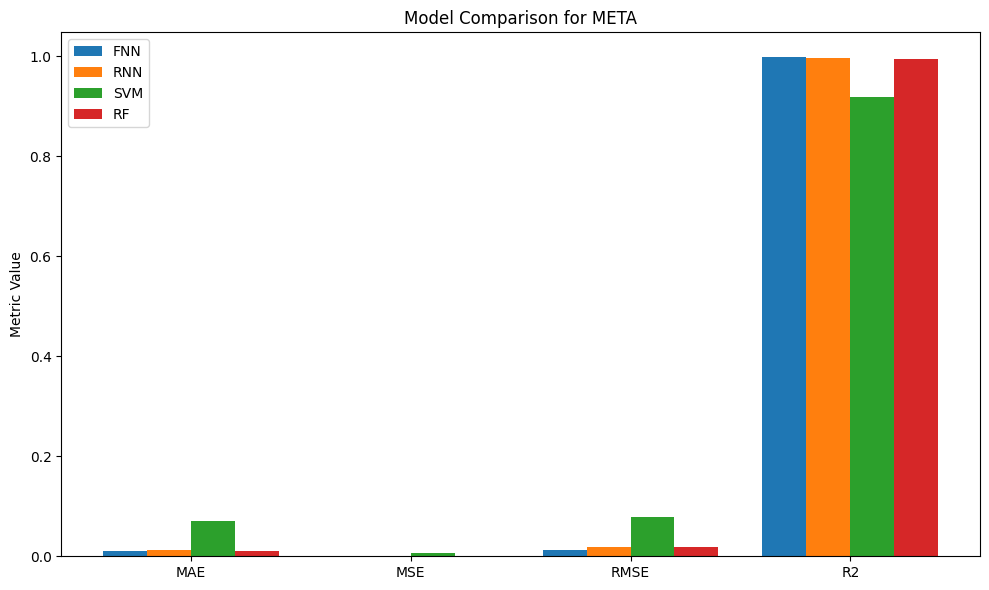

In [ ]:
# Gọi tới các evaluate đã lưu ở trên để vẽ biểu đồ so sánh
# So sánh theo từng loại điểm, tôi muốn so sánh cụm điểm

def plot_comparison(ticker, metrics, metric_names):
    models = ['FNN', 'RNN', 'SVM', 'RF']
    x = range(len(metric_names))
    width = 0.2

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, model in enumerate(models):
        ax.bar([xi + i * width for xi in x], [metric[i] for metric in metrics], width=width, label=model)


    ax.set_ylabel('Metric Value')
    ax.set_title(f'Model Comparison for {ticker}')
    ax.set_xticks([xi + width * (len(models) / 2 - 0.5) for xi in x])
    ax.set_xticklabels(metric_names)
    ax.legend()
    plt.tight_layout()
    plt.show()


for ticker in tickers:
    mae_values = [evaluate_fnn[ticker][0], evaluate_rnn[ticker][0], evaluate_svm[ticker][0], evaluate_rf[ticker][0]]
    mse_values = [evaluate_fnn[ticker][1], evaluate_rnn[ticker][1], evaluate_svm[ticker][1], evaluate_rf[ticker][1]]
    rmse_values = [evaluate_fnn[ticker][2], evaluate_rnn[ticker][2], evaluate_svm[ticker][2], evaluate_rf[ticker][2]]
    r2_values = [evaluate_fnn[ticker][3], evaluate_rnn[ticker][3], evaluate_svm[ticker][3], evaluate_rf[ticker][3]]
    plot_comparison(ticker, [mae_values, mse_values, rmse_values, r2_values], ["MAE", "MSE", "RMSE", "R2"])